In [1]:
import pandas as pd
import numpy as np
import requests
import os
import glob
import shutil
import string
import random
import pygad

from sklearn.preprocessing import MultiLabelBinarizer

In [2]:
def calc_target(kpis):
    return sum(5*(x_ref - x_ours) if x_ref > x_ours else x_ref - x_ours for x_ref, x_ours in kpis)

In [3]:
KPIS_WEIGHTS = [1, -1, -1]

### Helper functions

In [4]:
# Maximized (1)
def get_amount(solution):
    return solution[solution > 0].stack().sum()


def divide_amount_between_validators(solution):
    amounts = solution["amount"]
    solution_amountless = solution.drop(columns="amount")

    mask = solution_amountless == 1
    nominators_selected_validators_counts = mask.sum(axis=1)
    safe_selected_counts = nominators_selected_validators_counts.replace(0, 1)

    distributed_amounts = (amounts / safe_selected_counts).values[:, None] * mask

    validators_to_money = distributed_amounts.sum(axis=0)

    validators_to_money_dict = dict(zip(solution_amountless.columns, validators_to_money))

    return validators_to_money_dict


# Minimized (-1)
def get_standard_deviation(solution):
    return np.array(list(solution.sum(axis=0))).std()


# Minimized (-1)
def get_assignment(solution):
    nominatorsAssignments = (solution > 0).sum(axis=1)
    return ((nominatorsAssignments - 1) ** 2).sum()


def create_kpis(solution):
    solution_amount = get_amount(solution) * KPIS_WEIGHTS[0]
    solution_variance = get_standard_deviation(solution) * KPIS_WEIGHTS[1]
    solution_assignment = get_assignment(solution) * KPIS_WEIGHTS[2]

    return [solution_amount, solution_variance, solution_assignment]


def concatenate_solutions(sol1, sol2):
    result = []
    for s1, s2 in zip(sol1, sol2):
        result.append((s1, s2))

    return result


def compare_solutions(sol1, sol2):
    return calc_target(concatenate_solutions(create_kpis(sol1), create_kpis(sol2)))


def get_data_batches(nominators_filepath_pattern='data/polkadot_nominators_session_*.csv', batch_size=1, default_min=0):
    file_paths = glob.glob(nominators_filepath_pattern)
    num_batches = len(file_paths) // batch_size + (1 if len(file_paths) % batch_size != 0 else 0)
    data_batches = []
    for i in range(num_batches):
        nominators_batches = [pd.read_csv(file) for file in file_paths[i * batch_size: (i + 1) * batch_size]]
        all_data = pd.concat(nominators_batches, ignore_index=True)
        min_batch_amount = default_min if default_min == 0 else all_data["bonded_amount"].min()
        max_batch_amount = all_data["bonded_amount"].max()

        nominators_batches = list(map(lambda x: remove_empty_targets_row(x, min_batch_amount, max_batch_amount), nominators_batches))
        data_batches.append((nominators_batches, min_batch_amount, max_batch_amount))
    return data_batches


def remove_empty_targets_row(nominators_df, min_amount, max_amount):
    nominators_no_na = nominators_df[nominators_df["targets"].notna()]
    return normalize_amount_column(nominators_no_na, min_amount, max_amount)


def normalize_amount_column(nominators_df, min_amount, max_amount):
    nominators_df['bonded_amount'] = (nominators_df['bonded_amount'] - min_amount) / (max_amount - min_amount)
    return nominators_df


def flatten_solution(solution):
    indices = solution.index.to_numpy()
    data_matrix = solution.to_numpy()
    return np.concatenate(np.hstack([
        indices[:, None],
        data_matrix
    ]))


def create_binary_matrix(nominators):
    mlb = MultiLabelBinarizer()
    binary_matrix = mlb.fit_transform(nominators["targets"].str.split(','))
    binary_matrix = pd.DataFrame(binary_matrix, columns=mlb.classes_, index=nominators["stash_address"])
    binary_matrix["amount"] = nominators.set_index("stash_address")["bonded_amount"]
    return binary_matrix


def map_binary_matrix_to_solution(binary_matrix_solution):
    amounts = binary_matrix_solution["amount"]
    solution_amountless = binary_matrix_solution.drop(columns="amount")

    mask = solution_amountless == 1
    nominators_selected_validators_counts = mask.sum(axis=1)
    safe_selected_counts = nominators_selected_validators_counts.replace(0, 1)

    return (amounts / safe_selected_counts).values[:, None] * mask


def create_random_solution(nominators, number_of_validators):
    binary_matrix = create_binary_matrix(nominators)
    binary_matrix_dropped = binary_matrix.drop(columns="amount")
    random_solution = binary_matrix_dropped.sample(n=number_of_validators, axis=1)
    random_solution['amount'] = nominators.set_index('stash_address')['bonded_amount']
    return map_binary_matrix_to_solution(random_solution)

def create_ref_solution(validators, min_amount, max_amount):
    validators_data = validators[['stash_address', 'stakers']]
    validators_data['stakers'] = validators_data['stakers'].str.split(',')
    exploded = validators_data.explode('stakers')

    exploded[['nominator_stash', 'stake_amount']] = exploded['stakers'].str.split(';', expand=True)
    exploded['stake_amount'] = pd.to_numeric(exploded['stake_amount'], errors='coerce').fillna(0)

    amount_matrix = exploded.pivot_table(
        index='nominator_stash', columns='stash_address', values='stake_amount',
        aggfunc='sum', fill_value=0
    )

    amount_matrix = amount_matrix.iloc[:].applymap(
        lambda cell: (cell - min_amount) / (max_amount - min_amount)
    )

    return amount_matrix

def epic_solver_3000(nominators, num_of_vals, quantile_threshold = 0.999, stopping_criterion = 0.95, amount_fraction_matrix = None):
    binary_matrix = create_binary_matrix(nominators)
    if amount_fraction_matrix is None:    
        # step 1
        binary_matrix.sort_values(by='amount', inplace=True, ascending=False)
        
        # print("Step 1: binary_matrix")
        # display(binary_matrix)

        # step 2
        num_of_nominated_validators = binary_matrix.iloc[:, :-1].sum(axis=1)
        binary_matrix_divided = binary_matrix.iloc[:, :-1].div(num_of_nominated_validators, axis=0)
        amount_fraction_matrix = binary_matrix_divided.mul(binary_matrix['amount'], axis=0)

        # print("Step 2: amount_fraction_matrix")
        # display(amount_fraction_matrix)

        # step 3
        column_sums = amount_fraction_matrix.sum(axis=0)
        choosen_validators = column_sums.nlargest(num_of_vals).index

        # print("Step 3: choosen_validators")
        # display(choosen_validators)
    else:
        choosen_validators = amount_fraction_matrix.columns
    #step 4 
    sol = binary_matrix[choosen_validators]
    
    sol_filtered = sol[(sol != 0).any(axis=1)]

    sol_filtered_copy = sol_filtered.copy()

    sol_filtered_copy['amount'] = binary_matrix.loc[sol_filtered.index, 'amount']

    # print("Step 4: sol_filtered_copy")
    # display(sol_filtered_copy)

    percentile_95 = sol_filtered_copy['amount'].quantile(quantile_threshold)
    poors = sol_filtered_copy[sol_filtered_copy['amount'] <= percentile_95]
    rich = sol_filtered_copy[sol_filtered_copy['amount'] > percentile_95]

    poors_row_sums = poors.iloc[:, :-1].sum(axis=1)

    poors_sorted = poors.assign(poors_row_sums=poors_row_sums).sort_values(
        by=['poors_row_sums', 'amount'], 
        ascending=[True, False]
    ).drop(columns='poors_row_sums') 

    rich_row_sums = rich.iloc[:, :-1].sum(axis=1)

    rich_sorted = rich.assign(rich_row_sums=rich_row_sums).sort_values(
        by=['rich_row_sums', 'amount'], 
        ascending=[True, False]
    ).drop(columns='rich_row_sums') 

    # print("Step 4: poors_sorted")
    # display(poors_sorted)

    # print("Step 4: rich_sorted")
    # display(rich_sorted)

    solution = pd.DataFrame(0.0, index=sol.index, columns=sol.columns)
    validators_amount = pd.DataFrame([0.0] * len(sol.columns), index=sol.columns, columns=['amount']).T

    # print("Step 4: solution")
    # display(solution)

    # print("Step 4: validators_amount")
    # display(validators_amount)

    # print("~~~ LOOP ~~~ Step 4 POORS: index, amount, validators_selected, min_validator, validators_amount, solution")
    selection = poors_sorted.iloc[:, :-1]
    amount = poors_sorted.iloc[:, -1]
    validator_indices = np.array(poors_sorted.columns[:-1])
    validators_selected = (selection * validator_indices).to_numpy()
    validators_selected = [
        row[row != ''] for row in validators_selected
    ]

    # print(amount)
    # print(validators_selected

    for idx, selected_validators in enumerate(validators_selected):
        if not len(selected_validators):
            continue

        min_validator = validators_amount.loc['amount', selected_validators].idxmin()

        validators_amount.loc['amount', min_validator] += amount.iloc[idx]
        solution.loc[poors_sorted.index[idx], min_validator] = amount.iloc[idx]

        # print(min_validator)
        # display(validators_amount)
        # display(solution)


    # print("~~~ LOOP ~~~ Step 4 RICH: index, amount, validators_selected, validators_sum, total_sum, sum_divided, validators_amount, solution")
    selection = rich_sorted.iloc[:, :-1]
    amount = rich_sorted.iloc[:, -1]
    validator_indices = np.array(rich_sorted.columns[:-1])
    validators_selected = (selection * validator_indices).to_numpy()
    validators_selected = [
        row[row != ''] for row in validators_selected
    ]

    # print(amount)
    # print(validators_selected)

    for idx, selected_validators in enumerate(validators_selected):
        if not len(selected_validators):
            continue

        validators_sum = validators_amount.loc['amount', selected_validators].sum()
        total_sum = validators_sum + amount.iloc[idx]
        sum_divided = total_sum / len(selected_validators)

        # print(validators_sum)
        # print(total_sum)
        # print(sum_divided)

        remaining_amount = amount.iloc[idx]

        for validator in selected_validators:
            current_amount = validators_amount.loc['amount', validator]
            amount_to_add = sum_divided - current_amount
            amount_to_add = min(amount_to_add, remaining_amount)
            amount_to_add = max(amount_to_add, 0)

            validators_amount.loc['amount', validator] += amount_to_add
            solution.loc[rich_sorted.index[idx], validator] = amount_to_add

            remaining_amount -= amount_to_add

            if remaining_amount <= 0:
                break
        
        # display(validators_amount)
        # display(solution)


    # step 5, 6

    # print("Step 5,6 ##########################")

    prev_std = 1000000.0
    current_std = validators_amount.std(axis=1, ddof=0)['amount']

    while current_std < stopping_criterion * prev_std:
        print('Iteration')
        print(current_std)
        # print("~~~ LOOP ~~~ Step 5,6 POORS: index, amount, validators_selected, min_validator, validators_amount, solution")
        selection = poors_sorted.iloc[:, :-1]
        amount = poors_sorted.iloc[:, -1]
        validator_indices = np.array(poors_sorted.columns[:-1])
        validators_selected = (selection.to_numpy() * validator_indices).astype(str)
        validators_selected = [
            row[row != ''].tolist() for row in validators_selected
        ]

        # print(amount)
        # print(validators_selected)

        for idx, selected_validators in enumerate(validators_selected):
            if not selected_validators:
                continue

            solution_row = solution.loc[poors_sorted.index[idx]]
            prev_selected_validator = solution_row[solution_row != 0].index[0]

            validators_amount.loc['amount', prev_selected_validator] -= amount.iloc[idx]

            min_validator = validators_amount.loc['amount', selected_validators].idxmin()

            validators_amount.loc['amount', min_validator] += amount.iloc[idx]
            solution.loc[poors_sorted.index[idx], prev_selected_validator] = 0
            solution.loc[poors_sorted.index[idx], min_validator] = amount.iloc[idx]
            
            # print(min_validator)
            # display(validators_amount)
            # display(solution)

        # print("~~~ LOOP ~~~ Step 5,6 RICH: index, amount, validators_selected, validators_sum, total_sum, sum_divided, validators_amount, solution")

        for index, row in rich_sorted.iterrows():
            # print("~~~ LOOP ~~~ Step 5,6 RICH: index, amount, validators_selected, validators_sum, total_sum, sum_divided, validators_amount, solution")
            # print(index)
            selection = row.iloc[:-1]
            amount = row.iloc[-1]
            validators_selected = list(selection[selection == 1].index)

            # print(amount)
            # print(validators_selected)

            total_sum = validators_amount.loc['amount', validators_selected].sum()
            sum_divided = total_sum / len(validators_selected)

            validators_amount.loc['amount'] -= solution.loc[index]

            # print(validators_sum)
            # print(total_sum)
            # print(sum_divided)

            remaining_amount = amount
        
            for validator in validators_selected:
                current_amount = validators_amount.loc['amount', validator]
                amount_to_add = sum_divided - current_amount
                amount_to_add = min(amount_to_add, remaining_amount)
                amount_to_add = max(amount_to_add, 0)
                
                validators_amount.loc['amount', validator] += amount_to_add

                solution.loc[index, validator] = amount_to_add
                
                remaining_amount -= amount_to_add
                
                if remaining_amount <= 0:
                    break

            # display(validators_amount)
            # display(solution)


        # Optimized but something does not work (also speed up is not significant)
        # selection = rich_sorted.iloc[:, :-1]
        # amount = rich_sorted.iloc[:, -1]
        # validator_indices = np.array(rich_sorted.columns[:-1])

        # validators_selected = (selection.to_numpy() * validator_indices)
        # validators_selected = [
        #     row[row != ''] for row in validators_selected
        # ]

        # # print(amount)
        # # print(validators_selected)

        # validators_amount_values = np.array([
        #         validators_amount.loc['amount', selected_validators].values.sum() 
        #         for selected_validators in validators_selected
        # ])
        # sum_divided_values = validators_amount_values / np.array([len(validators) for validators in validators_selected])
        # # print(validators_amount_values)
        # # print(sum_divided_values)
        
        # for idx, (selected_validators, sum_divided, nominator_amount) in enumerate(zip(validators_selected, sum_divided_values, amount)):
        #     remaining_amount = nominator_amount

        #     validators_amount.loc['amount'] -= solution.iloc[idx]

        #     for validator in selected_validators:
        #         current_amount = validators_amount.loc['amount', validator]
        #         amount_to_add = sum_divided - current_amount
        #         amount_to_add = min(amount_to_add, remaining_amount)
        #         amount_to_add = max(amount_to_add, 0)

        #         validators_amount.loc['amount', validator] += amount_to_add
        #         solution.loc[rich_sorted.index[idx], validator] = amount_to_add

        #         remaining_amount -= amount_to_add

        #         if remaining_amount <= 0:
        #             break
            
        #     # display(validators_amount)
        #     # display(solution)

        prev_std = current_std
        current_std = validators_amount.std(axis=1, ddof=0)['amount']

    print('final std:')
    print(validators_amount.std(axis=1, ddof=0)['amount'])

    return solution

In [5]:
google_cloud_url = "https://storage.googleapis.com/watcher-csv-exporter/"
session_filename_template = string.Template("polkadot_nominators_session_$id.csv")
era_filename_template = string.Template("polkadot_validators_era_$id.csv")

Loading of data

In [6]:
def download_file(url, destination):
    response = requests.get(url, stream=True)
    response.raise_for_status()
    with open(destination, 'wb') as file:
            for chunk in response.iter_content(chunk_size=8192):
                file.write(chunk)

def download_batch(starting_era=1000, starting_session=6041, destinationFolder="data/", number_of_eras_to_download=1):
    if os.path.exists(destinationFolder):
         shutil.rmtree(destinationFolder)
         
    os.makedirs(destinationFolder, exist_ok=True)
    era_id = starting_era
    session_id = starting_session
    total_eras_downloaded = 0

    while total_eras_downloaded < number_of_eras_to_download:
        era_filename = era_filename_template.substitute({'id': era_id})

        try:
            download_file(
                google_cloud_url + era_filename,
                destinationFolder + era_filename
            )
        except Exception as e:
            era_id += 1
            session_id += 6
            continue
        
        session_filename = session_filename_template.substitute({'id': session_id})
        download_file(
            google_cloud_url + session_filename,
            destinationFolder + session_filename
        )

        total_eras_downloaded += 1
        era_id += 1
        session_id += 6

### Download of data and set basic variables

In [7]:
# STARTING_ERA = 165
# STARTING_SESSION = 1031
STARTING_ERA = 1000
STARTING_SESSION = 6041
download_batch(starting_era=STARTING_ERA, starting_session=STARTING_SESSION, number_of_eras_to_download=100)

In [8]:
nominators, min_amount, max_amount = get_data_batches()[0]

/tmp/ipykernel_6118/3094460721.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nominators_df['bonded_amount'] = (nominators_df['bonded_amount'] - min_amount) / (max_amount - min_amount)
/tmp/ipykernel_6118/3094460721.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nominators_df['bonded_amount'] = (nominators_df['bonded_amount'] - min_amount) / (max_amount - min_amount)
/tmp/ipykernel_6118/3094460721.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


In [9]:
nominators, min_amount, max_amount = get_data_batches()[0]
nominators = nominators[0]
validators = pd.read_csv(f"data/polkadot_validators_era_{STARTING_ERA}.csv")
number_of_validators = len(validators)
binary_matrix = create_binary_matrix(nominators)
val_pool = binary_matrix.columns
val_pool = val_pool[:-1]
val_pool = val_pool.to_list()

validators_data = validators[['stash_address', 'stakers']]
validators_data['stakers'] = validators_data['stakers'].str.split(',')
exploded = validators_data.explode('stakers')

exploded[['nominator_stash', 'stake_amount']] = exploded['stakers'].str.split(';', expand=True)
exploded['stake_amount'] = pd.to_numeric(exploded['stake_amount'], errors='coerce').fillna(0)

amount_matrix = exploded.pivot_table(
    index='nominator_stash', columns='stash_address', values='stake_amount',
    aggfunc='sum', fill_value=0
)

amount_matrix = amount_matrix.iloc[:].applymap(
    lambda cell: (cell - min_amount) / (max_amount - min_amount)
)

ref_sol = amount_matrix
ref_sol_kpis = create_kpis(ref_sol)

amount_matrix

/tmp/ipykernel_6118/3094460721.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nominators_df['bonded_amount'] = (nominators_df['bonded_amount'] - min_amount) / (max_amount - min_amount)
/tmp/ipykernel_6118/3094460721.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nominators_df['bonded_amount'] = (nominators_df['bonded_amount'] - min_amount) / (max_amount - min_amount)
/tmp/ipykernel_6118/3094460721.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


stash_address                                     111B8CxcmnWbuDLyGvgUmRezDCK1brRZmvUuQ6SrFdMyc3S  \
nominator_stash                                                                                     
111BmabW5wwTjz6VbKHD9jCwWQtNz2PugddS2orLRbdgMK                                                0.0   
1122baMYr18CfTKPqRerzM4Zthv7q6b3aJtEbugg32g39GK                                               0.0   
11233qXh9wqztw1H1FDMb6Ku3AAACnT4iVHdwcfasyKwSwrf                                              0.0   
11264h8MNuFYJeukdod1FAeRnUUvQpAfCjcya2f5K9ASRXkp                                              0.0   
1126CbWHdxj6zew9FSu4RX51iQEqmWBj6mWDCYMc8Hkd8j6o                                              0.0   
...                                                                                           ...   
1zwfwxuks38XbTUrUvyYapbczksLHQuFUpCtWeshgMn6E6w                                               0.0   
1zxV8irCMjKVrT7qTtRgYSsYCMFQvhCr5s56bHvZTYMTy2U                                               0.0   
1zy9Lwry57fdX6e4VEjiskhcQZsm8BGkPofv23qbTKwWBNr                                               0.0   
1zyzVjvWKcsJq6oK3r6a3XHYWXygV3m4aev8RmAX8bHKWE2                                               0.0   
1zzHPNrdcPdoZdnSTutmqEBGmxRWZDG4AXxBchDTpgQpBLm                                               0.0   

stash_address                                     1123RekaPHgWaPL5v9qfsikRemeZdYC4tvKXYuLXwhfT3NKy  \
nominator_stash                                                                                      
111BmabW5wwTjz6VbKHD9jCwWQtNz2PugddS2orLRbdgMK                                                 0.0   
1122baMYr18CfTKPqRerzM4Zthv7q6b3aJtEbugg32g39GK                                                0.0   
11233qXh9wqztw1H1FDMb6Ku3AAACnT4iVHdwcfasyKwSwrf                                               0.0   
11264h8MNuFYJeukdod1FAeRnUUvQpAfCjcya2f5K9ASRXkp                                               0.0   
1126CbWHdxj6zew9FSu4RX51iQEqmWBj6mWDCYMc8Hkd8j6o                                               0.0   
...                                                                                            ...   
1zwfwxuks38XbTUrUvyYapbczksLHQuFUpCtWeshgMn6E6w                                                0.0   
1zxV8irCMjKVrT7qTtRgYSsYCMFQvhCr5s56bHvZTYMTy2U                                                0.0   
1zy9Lwry57fdX6e4VEjiskhcQZsm8BGkPofv23qbTKwWBNr                                                0.0   
1zyzVjvWKcsJq6oK3r6a3XHYWXygV3m4aev8RmAX8bHKWE2                                                0.0   
1zzHPNrdcPdoZdnSTutmqEBGmxRWZDG4AXxBchDTpgQpBLm                                                0.0   

stash_address                                     114SUbKCXjmb9czpWTtS3JANSmNRwVa4mmsMrWYpRG1kDH5  \
nominator_stash                                                                                     
111BmabW5wwTjz6VbKHD9jCwWQtNz2PugddS2orLRbdgMK                                                0.0   
1122baMYr18CfTKPqRerzM4Zthv7q6b3aJtEbugg32g39GK                                               0.0   
11233qXh9wqztw1H1FDMb6Ku3AAACnT4iVHdwcfasyKwSwrf                                              0.0   
11264h8MNuFYJeukdod1FAeRnUUvQpAfCjcya2f5K9ASRXkp                                              0.0   
1126CbWHdxj6zew9FSu4RX51iQEqmWBj6mWDCYMc8Hkd8j6o                                              0.0   
...                                                                                           ...   
1zwfwxuks38XbTUrUvyYapbczksLHQuFUpCtWeshgMn6E6w                                               0.0   
1zxV8irCMjKVrT7qTtRgYSsYCMFQvhCr5s56bHvZTYMTy2U                                               0.0   
1zy9Lwry57fdX6e4VEjiskhcQZsm8BGkPofv23qbTKwWBNr                                               0.0   
1zyzVjvWKcsJq6oK3r6a3XHYWXygV3m4aev8RmAX8bHKWE2                                               0.0   
1zzHPNrdcPdoZdnSTutmqEBGmxRWZDG4AXxBchDTpgQpBLm                                               0.0   

stash_address                                

In [10]:
nominators

era  session  last_session      timestamp  block_number  \
0      1027     6203             1  1679843706016      14814942   
1      1027     6203             1  1679843706016      14814942   
2      1027     6203             1  1679843706016      14814942   
3      1027     6203             1  1679843706016      14814942   
4      1027     6203             1  1679843706016      14814942   
...     ...      ...           ...            ...           ...   
46073  1027     6203             1  1679843706016      14814942   
46074  1027     6203             1  1679843706016      14814942   
46075  1027     6203             1  1679843706016      14814942   
46076  1027     6203             1  1679843706016      14814942   
46077  1027     6203             1  1679843706016      14814942   

                                          stash_address  \
0       1vfh4WtfRERYNY9mkEyCpEPYXPqLqESFM8XuHFRELW6qhCB   
1      12zr2Sd7UvujakqUTJRxW3bT7bMQbn8iaRWxhN7RyAfhRPZY   
2      15Xn1yd7dwWe2ohcG8oyMY2u6LQsfDrVgj7cQdjL4KPAvBsy   
3       1MZ2PGw1z3tqWFTHy3W7gaZd9qPfconW5AY21QSC2SYQ4Dj   
4      14AaafgpW28dMWv4ESMd2TLMdejQR7TR5tUQkVqmwC4hNgoa   
...                                                 ...   
46073  16c5asNZWgjwKc1HUvVYKXsTqQ1mBRh1azeingM77G48qtip   
46074  16ipEr7ZAVpNZ6TPJK7ZzhBJYH2YJQ4kjPUvFLbgxoTvTyJW   
46075   1cdhsnffi25hyNyDkTTSL3HRGWKbELcEfJHGHimemYwYsUi   
46076  15XNV5xoBZYyH9xnLX1VUu7MA5XSD9139E1ZPY5dod9Te66i   
46077  14ajZ7XrZBfoENeY2YKvVc8wya84ck87GVUmjHbW91AsUwXr   

                                     controller_address  bonded_amount  \
0       1vfh4WtfRERYNY9mkEyCpEPYXPqLqESFM8XuHFRELW6qhCB   1.411597e-05   
1      12zr2Sd7UvujakqUTJRxW3bT7bMQbn8iaRWxhN7RyAfhRPZY   1.129135e-04   
2      15Xn1yd7dwWe2ohcG8oyMY2u6LQsfDrVgj7cQdjL4KPAvBsy   5.083039e-05   
3       1MZ2PGw1z3tqWFTHy3W7gaZd9qPfconW5AY21QSC2SYQ4Dj   2.435881e-05   
4      14AaafgpW28dMWv4ESMd2TLMdejQR7TR5tUQkVqmwC4hNgoa   2.690344e-05   
...                                                 ...            ...   
46073  16c5asNZWgjwKc1HUvVYKXsTqQ1mBRh1azeingM77G48qtip   2.238295e-06   
46074  16ipEr7ZAVpNZ6TPJK7ZzhBJYH2YJQ4kjPUvFLbgxoTvTyJW   2.783675e-07   
46075   1cdhsnffi25hyNyDkTTSL3HRGWKbELcEfJHGHimemYwYsUi   3.890566e-06   
46076  15XNV5xoBZYyH9xnLX1VUu7MA5XSD9139E1ZPY5dod9Te66i   3.029273e-06   
46077  14ajZ7XrZBfoENeY2YKvVc8wya84ck87GVUmjHbW91AsUwXr   5.370298e-07   

       num_targets                                            targets  
0                1   13uW7auWPX9WAtqwkBx7yagb78PLcv8FAcPZEVCovbXoNJK4  
1               10  14Y4s6V1PWrwBLvxW47gcYgZCGTYekmmzvFsK1kiqNH2d8...  
2                1    11uMPbeaEDJhUxzU4ZfWW9VQEsryP9XqFcNRfPdYda6aFWJ  
3               16  11uMPbeaEDJhUxzU4ZfWW9VQEsryP9XqFcNRfPdYda6aFW...  
4               16  13uW7auWPX9WAtqwkBx7yagb78PLcv8FAcPZEVCovbXoNJ...  
...            ...                                                ...  
46073           14  1BdoL1BP36SZGEKR4iX8ksou2GTnrDd5of99SWK82c3A4a...  
46074            5  1Wo6qcrh7wxc1kQY5nfixFuCAFuzkgiwau64SmrPXBE7vV...  
46075            6  1jqkeJhuoRudNTVL5dV1qZf8RQtyzcf6ZT4yyvUQbKFktr...  
46076            5  1342iFZNrBfCP9VWxqt5p39LiHp2ynyq85Ww9K7R8w6BUR...  
46077            1   14Y4s6V1PWrwBLvxW47gcYgZCGTYekmmzvFsK1kiqNH2d84t  

[46050 rows x 10 columns]

In [11]:
sum(validators['num_stakers'])

22096

## Gready Solution

In [12]:
## Focus On total amount
def solve_total_amount(nominators, num_of_vals):
    binary_matrix = create_binary_matrix(nominators)
    selected_validators = set()

    binary_matrix.sort_values(by='amount', inplace=True, ascending=False)
    i = 0

    while len(selected_validators) < num_of_vals:
        cols = binary_matrix.columns[binary_matrix.iloc[i] == 1].tolist()
        to_add = num_of_vals - len(selected_validators)
        if len(cols) <= to_add:
            selected_validators.update(cols)
        else:
            selected_validators.update(cols[:to_add])
        i += 1

    result = binary_matrix[list(selected_validators)]
    result['amount'] = nominators.set_index('stash_address')['bonded_amount']

    return map_binary_matrix_to_solution(result)

In [13]:
## Focus On total amount 2
def solve_total_amount_2(nominators, num_of_vals):
    nominators_copy = nominators.copy(deep=True)

    nominators_copy['targets'] = nominators_copy['targets'].apply(lambda x: x.split(','))
    
    expanded_nominators = nominators_copy.explode('targets')
    
    validator_stakes = expanded_nominators.groupby('targets')['bonded_amount'].sum().reset_index()
    validator_stakes = validator_stakes.rename(columns={'targets': 'validator_id', 'bonded_amount': 'total_stake'})
    validator_stakes_sorted = validator_stakes.sort_values(by='total_stake', ascending=False)
    selected_validators_df = validator_stakes_sorted.head(num_of_vals)
    
    binary_matrix = binary_matrix = create_binary_matrix(nominators)

    return map_binary_matrix_to_solution(binary_matrix[list(selected_validators_df['validator_id']) + ['amount']])

In [14]:
## Focus on amount variance
def solve_variance_only(nominators, num_of_vals):
    nominators_copy = nominators.copy(deep=True)
    nominators_copy['targets'] = nominators_copy['targets'].apply(lambda x: x.split(','))
    expanded_nominators = nominators_copy.explode('targets')

    validator_stakes = expanded_nominators.groupby('targets')['bonded_amount'].sum().reset_index()
    validator_stakes = validator_stakes.rename(columns={'targets': 'validator_id', 'bonded_amount': 'total_stake'})
    validator_stakes_sorted = validator_stakes.sort_values(by='total_stake', ascending=False)

    selected_validators = []

    for _, validator in validator_stakes_sorted.iterrows():
        stakes = [v['total_stake'] for v in selected_validators] + [validator['total_stake']]
        variance = np.var(stakes)

        if len(selected_validators) < num_of_vals or variance < np.var(stakes[:-1]):
            selected_validators.append(validator)

        if len(selected_validators) >= num_of_vals:
            break

    selected_validators_df = pd.DataFrame(selected_validators)

    binary_matrix = binary_matrix = create_binary_matrix(nominators)

    return map_binary_matrix_to_solution(binary_matrix[list(selected_validators_df['validator_id']) + ['amount']])

In [15]:
## Focus on assignments
def solve_assignments_only(nominators, num_of_vals):
    nominators_copy = nominators.copy(deep=True)
    nominators_copy['targets'] = nominators_copy['targets'].str.split(',')
    nominators_copy_sorted = nominators_copy.sort_values(by=['num_targets', 'bonded_amount'], ascending=[False, False])

    selected_validators = set()
    encountered_validators = set()

    for _, nominator in nominators_copy_sorted.iterrows():

        if np.any([target in encountered_validators for target in nominator['targets']]):
            continue
        
        if nominator['targets']:
            chosen_validator = nominator['targets'][0]
            selected_validators.add(chosen_validator)
            encountered_validators.update(nominator['targets'])

        if len(selected_validators) >= num_of_vals:
            break

    
    if len(selected_validators) < num_of_vals:
        nominators_copy_sorted = nominators_copy.sort_values(by=['num_targets', 'bonded_amount'], ascending=[True, False])
        for _, nominator in nominators_copy_sorted.iterrows():
            available_targets = [validator for validator in nominator['targets'] if validator not in selected_validators]
            
            if available_targets:
                chosen_validator = available_targets[0]
                selected_validators.add(chosen_validator)

            if len(selected_validators) >= num_of_vals:
                break

    binary_matrix = binary_matrix = create_binary_matrix(nominators)

    return map_binary_matrix_to_solution(binary_matrix[list(selected_validators) + ['amount']])

In [84]:
## Custom Greedy
def solve(nominators, num_of_vals):
    nominators_copy = nominators.copy(deep=True)

    nominators_copy['targets'] = nominators_copy['targets'].apply(lambda x: x.split(','))
    
    expanded_nominators = nominators_copy.explode('targets')
    expanded_nominators['bonded_amount'] = expanded_nominators['bonded_amount'].astype(float)
    
    validator_stakes = expanded_nominators.groupby('targets')['bonded_amount'].sum().reset_index()
    validator_stakes = validator_stakes.rename(columns={'targets': 'validator_id', 'bonded_amount': 'total_stake'})
    validator_stakes_sorted = validator_stakes.sort_values(by='total_stake', ascending=False)

    selected_validators = []
    selected_nominators = set()

    for _, validator in validator_stakes_sorted.iterrows():
        validator_id = validator['validator_id']
        validator_nominators = set(expanded_nominators[expanded_nominators['targets'] == validator_id]['stash_address'])
        overlap = len(validator_nominators & selected_nominators)
        
        stakes = [v['total_stake'] for v in selected_validators] + [validator['total_stake']]
        variance = np.var(stakes)
        variance_tolerance = 0.009

        if len(selected_validators) < num_of_vals or (overlap < 2 and variance - variance_tolerance < np.var(stakes[:-1])):
            selected_validators.append(validator)
            selected_nominators.update(validator_nominators)
        
        if len(selected_validators) >= num_of_vals:
            break

    selected_validators_df = pd.DataFrame(selected_validators)
    
    binary_matrix = create_binary_matrix(nominators)

    return map_binary_matrix_to_solution(binary_matrix[list(selected_validators_df['validator_id']) + ['amount']])

## Genetic Solution

### Helper functions

In [ ]:
def encode_solution(sol, val_pool=val_pool):
    sol = sol.columns[:-1].tolist()
    binary_vector = [0] * len(val_pool)
    for validator in sol:
        if validator in val_pool:
            index = val_pool.index(validator)
            binary_vector[index] = 1
    
    return binary_vector


def decode_solution(encoded_sol):
    global val_pool
    global binary_matrix

    decoded_list = []
    for i, value in enumerate(encoded_sol):
        if value == 1:
            decoded_list.append(val_pool[i])

    matching_columns = [col for col in decoded_list if col in binary_matrix.columns]
    return binary_matrix[matching_columns + [binary_matrix.columns[-1]]]


def fitness_func(ga_instance, solution, solution_idx):
    decoded_solution = map_binary_matrix_to_solution(decode_solution(solution))
    sol_kpis = create_kpis(decoded_solution)
    sol_kpis[1], sol_kpis[2]
    
    fitness = calc_target(concatenate_solutions(ref_sol_kpis, sol_kpis))

    return fitness * -1


def mutate(solutions, ga_instance):
    n = 5
    offspring = []
    for solution in solutions:
        binary_vector = solution.copy()
        ones_indices = [i for i, bit in enumerate(binary_vector) if bit == 1]
        zeros_indices = [i for i, bit in enumerate(binary_vector) if bit == 0]

        for _ in range(n):
            one_to_zero = random.choice(ones_indices)
            zero_to_one = random.choice(zeros_indices)

            binary_vector[one_to_zero], binary_vector[zero_to_one] = 0, 1

            ones_indices.remove(one_to_zero)
            zeros_indices.append(one_to_zero)
            zeros_indices.remove(zero_to_one)
            ones_indices.append(zero_to_one)

        offspring.append(binary_vector)
    
    return np.array(offspring)


def crossover(parents, offspring_size, ga_instance):
    offspring = []
    while len(offspring) != offspring_size[0]:
        temp_len = len(parents[0])
        ones_p1 = [i for i, bit in enumerate(parents[0]) if bit == 1]
        ones_p2 = [i for i, bit in enumerate(parents[1]) if bit == 1]
        temp = len(ones_p1)
        crossover_point = random.randint(1, temp - 1)
        offspring1 = [0 for _ in range(temp_len)]
        offspring2 = [0 for _ in range(temp_len)]

        for i in range(crossover_point):
            offspring1[ones_p1[i]] = 1
            offspring2[ones_p2[i]] = 1

        for i in range(crossover_point, temp):
            if offspring1[ones_p2[i]] == 1 or offspring2[ones_p1[i]] == 1:
                offspring1[ones_p1[i]] = 1
                offspring2[ones_p2[i]] = 1
            else:
                offspring1[ones_p2[i]] = 1
                offspring2[ones_p1[i]] = 1

        offspring.append(offspring1)
    

    return np.array(offspring)


def get_greedy_solutions(n, num_of_val, val_pool):
    population = [
        encode_solution(solve(n, num_of_val), val_pool),
        encode_solution(solve_assignments_only(n, num_of_val), val_pool),
        encode_solution(solve_total_amount(n, num_of_val), val_pool),
        encode_solution(solve_total_amount_2(n, num_of_val), val_pool),
        encode_solution(solve_variance_only(n, num_of_val), val_pool)
    ]
    return population

### Parameters

In [18]:
initial_population_size = 10
num_generations = 10
num_parents_mating = 2
keep_elitssm = 5

### Genetic Algorith


In [104]:
def solve_genetic_solution(nominator_list,
                     num_of_vals,
                     val_pool,
                     initial_pop_size=initial_population_size, 
                     num_gens=num_generations, 
                     num_pars_mating=num_parents_mating, 
                     keep_eli=keep_elitssm, 
                     fitness=fitness_func, crossover=crossover, mutate=mutate):

    initial_population = get_greedy_solutions(nominator_list, num_of_vals, val_pool)

    for _ in range(initial_pop_size - len(initial_population)):
        initial_population.append(encode_solution(create_random_solution(nominator_list, num_of_vals), val_pool))

    ga_instance = pygad.GA(num_generations=num_gens,
                        num_parents_mating=num_pars_mating,
                        fitness_func=fitness,
                        initial_population=initial_population,
                        crossover_type=crossover,
                        mutation_type=mutate,
                        keep_elitism=keep_eli
                        )

    ga_instance.run()

    ga_solution, ga_solution_fitness, solution_idx = ga_instance.best_solution()

    ga_instance.plot_fitness()

    return decode_solution(ga_solution)

In [20]:
import matplotlib.pyplot as plt

def plot_kpis_separately(solutions, method_names):
    num_solutions = len(solutions)
    num_methods = len(method_names)
    kpis = [
        [create_kpis(solution) for solution in row]
        for row in solutions
    ]
    kpis = np.array(kpis)  # Shape: (num_solutions, num_methods, 3)

    amounts = kpis[:, :, 0]
    variances = kpis[:, :, 1]
    assignments = kpis[:, :, 2]

    x = np.arange(num_solutions)

    fig, axes = plt.subplots(3, num_methods, figsize=(15, 12), sharex=True)
    kpi_names = ["Amount KPI", "Variance KPI", "Assignment KPI"]
    kpi_data = [amounts, variances, assignments]

    for i, kpi in enumerate(kpi_data):
        for j, method_name in enumerate(method_names):
            axes[i, j].plot(x, kpi[:, j], label=method_name, marker='o')
            axes[i, j].set_title(f"{kpi_names[i]} - {method_name}")
            axes[i, j].set_ylabel("KPI Value")
            axes[i, j].set_xlabel("Solution Index")
            axes[i, j].grid()
    
    plt.tight_layout()
    plt.show()

In [ ]:
def get_solutions(n):
    column_names = [
        "random solution", "solve total amount v1", "solve total amount v2", "solve variance only", "solve assignment only", "solve custom greedy", "solve genetic"
    ]
    solutions = []
    solutions_kpis = []
    plot_solutions = []

    ta_solution = epic_solver_3000(nominators, number_of_validators, amount_fraction_matrix=solve_total_amount(nominators, number_of_validators))
    ta2_solution = epic_solver_3000(nominators, number_of_validators, amount_fraction_matrix=solve_total_amount_2(nominators, number_of_validators))
    var_solution = epic_solver_3000(nominators, number_of_validators, amount_fraction_matrix=solve_variance_only(nominators, number_of_validators))
    ass_solution = epic_solver_3000(nominators, number_of_validators, amount_fraction_matrix=solve_assignments_only(nominators, number_of_validators))
    custom_solution = epic_solver_3000(nominators, number_of_validators, amount_fraction_matrix=solve(nominators, number_of_validators))

    ref_sol_epic = ref_sol

    for _ in range(n):
        random_solution = epic_solver_3000(nominators, number_of_validators, amount_fraction_matrix=create_random_solution(nominators, number_of_validators))
        gen_solution = epic_solver_3000(nominators, number_of_validators, amount_fraction_matrix=map_binary_matrix_to_solution(solve_genetic_solution(nominators, number_of_validators, val_pool)))

        random = compare_solutions(ref_sol_epic, random_solution)
        ta = compare_solutions(ref_sol_epic, ta_solution)
        ta2 = compare_solutions(ref_sol_epic, ta2_solution)
        var = compare_solutions(ref_sol_epic, var_solution)
        ass = compare_solutions(ref_sol_epic, ass_solution)
        custom = compare_solutions(ref_sol_epic, custom_solution)
        gen = compare_solutions(ref_sol_epic, gen_solution)

        solutions.append([random, ta, ta2, var, ass, custom, gen])
        solutions_kpis.append([create_kpis(random_solution), create_kpis(ta_solution), create_kpis(ta2_solution), create_kpis(var_solution), create_kpis(ass_solution), create_kpis(custom_solution), create_kpis(gen_solution)])
        plot_solutions.append([random_solution, ta_solution, ta2_solution, var_solution, ass_solution, custom_solution, gen_solution])

    solutions_df = pd.DataFrame(solutions, columns=column_names)
    return solutions_df, solutions_kpis, plot_solutions

In [ ]:
def get_solutionsx():
    random = compare_solutions(ref_sol, create_random_solution(nominators, number_of_validators))
    ta = compare_solutions(ref_sol, solve_total_amount(nominators, number_of_validators))
    ta2 =compare_solutions(ref_sol, solve_total_amount_2(nominators, number_of_validators))
    var = compare_solutions(ref_sol, solve_variance_only(nominators, number_of_validators))
    ass = compare_solutions(ref_sol, solve_assignments_only(nominators, number_of_validators))
    custom = compare_solutions(ref_sol, solve(nominators, number_of_validators))
    gen = compare_solutions(ref_sol, solve_genetic_solution(nominators, number_of_validators, val_pool))
                                         
    return [random, ta, ta2, var, ass, custom, gen]

/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.016316137244797916
Iteration
0.015030692309501121
final std:
0.015179990484435336
Iteration
0.013534648095003734
Iteration
0.009112656583314406
final std:
0.0089540705523373
Iteration
0.013534648095003734
Iteration
0.009112656583314406
final std:
0.0089540705523373
Iteration
0.11383628565871373
final std:
0.11313758965117535
Iteration
0.013534648095003734
Iteration
0.009112656583314406
final std:
0.0089540705523373
Iteration
0.07116810371008479
final std:
0.07046390570936875


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")
No artists with labels found to put in legend.  Note that

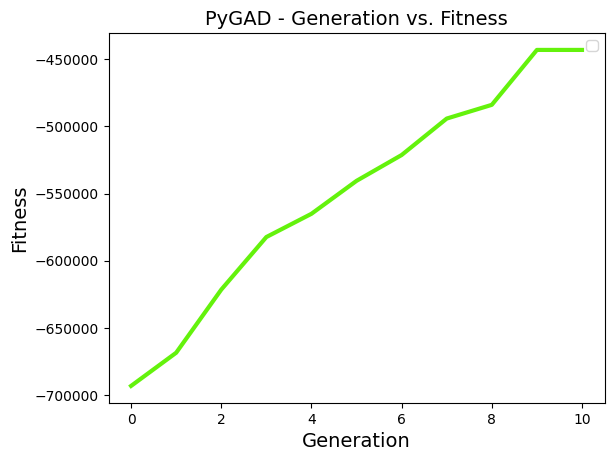

Iteration
0.0728870942404113
final std:
0.07222630884693713


In [23]:
solutions, solutions_kpis, plot_solutions = get_solutions(1)

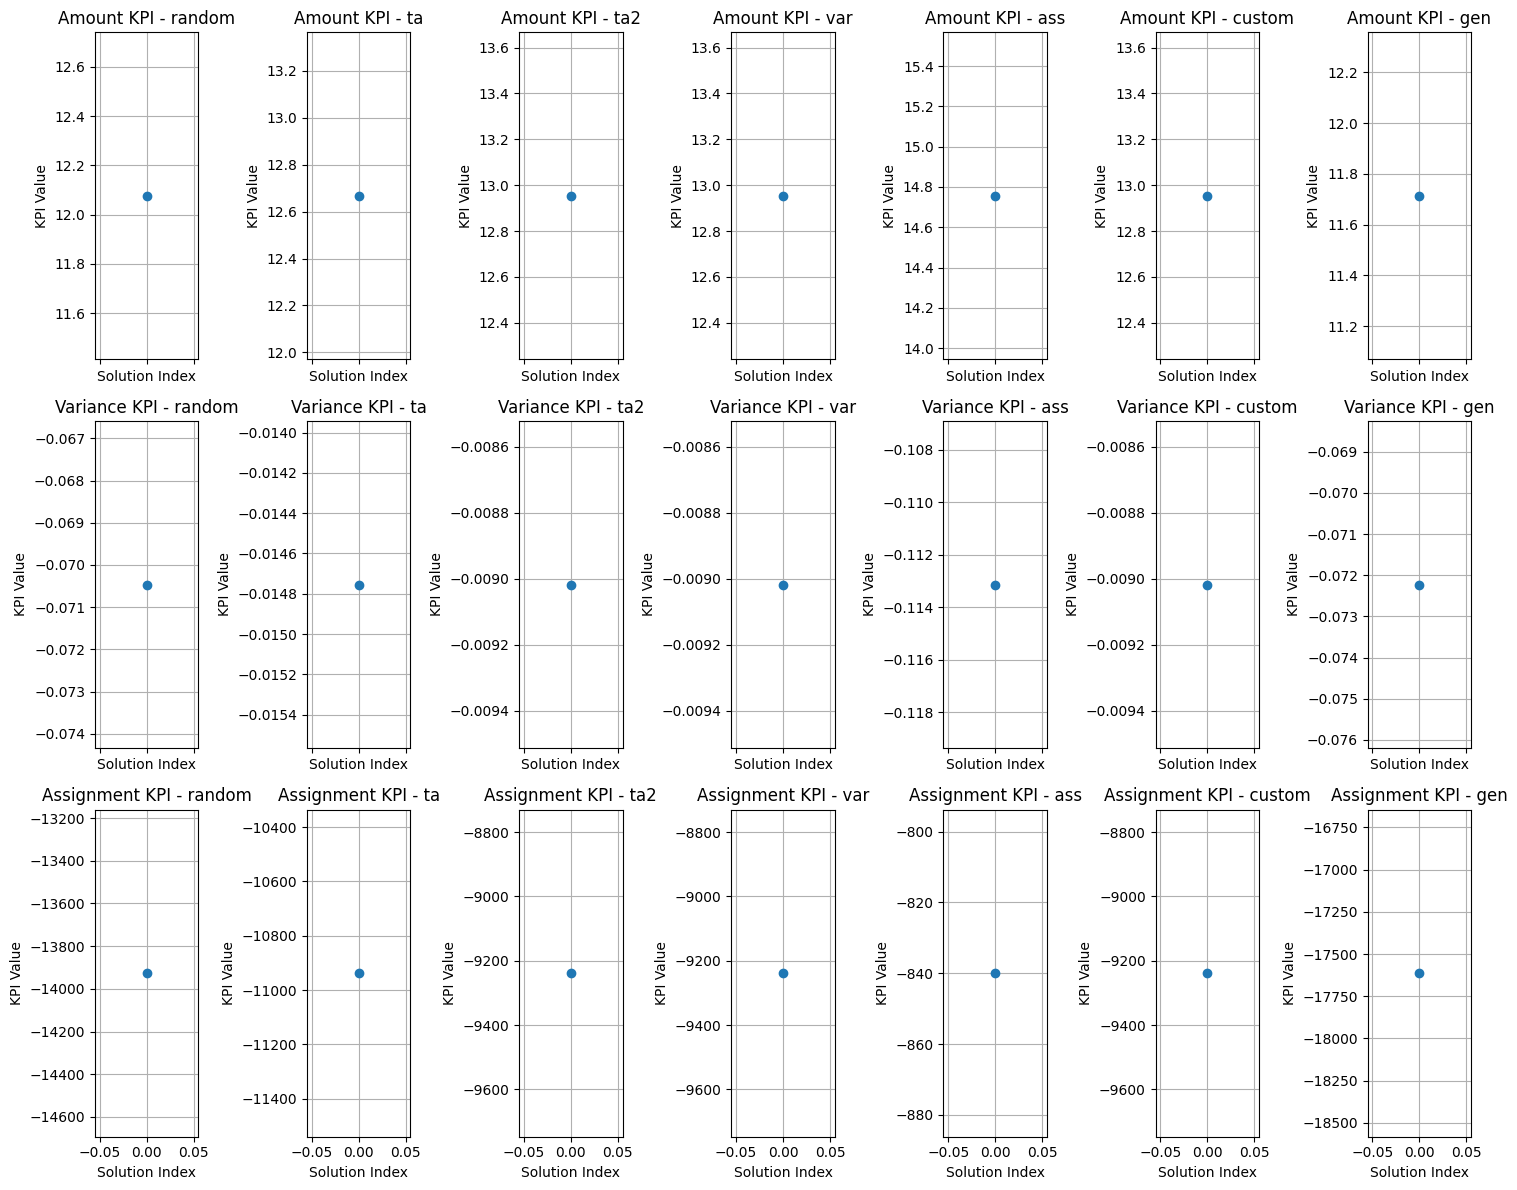

In [24]:
plot_kpis_separately(plot_solutions, ['random', 'ta', 'ta2', 'var', 'ass', 'custom', 'gen'])

In [25]:
solutions_kpis_array = np.array(solutions_kpis)
averaged_kpis = solutions_kpis_array.mean(axis=0)

columns = ['Amount', 'STD Dev', 'Assignment']
method_names = ['Random', 'Total Amount', 'Total Amount 2', 'STD Dev', 'Assignment', 'Combined', 'Genentic']

solutions_kpis_df = pd.DataFrame(
    averaged_kpis, 
    columns=columns, 
    index=method_names
)

solutions_kpis_df.loc['Reference'] = ref_sol_kpis

solutions_kpis_df[['STD Dev', 'Assignment']] *= -1

solutions_kpis_df

Amount   STD Dev  Assignment
Random          12.076549  0.070464     13927.0
Total Amount    12.667210  0.014754     10938.0
Total Amount 2  12.953711  0.009017      9239.0
STD Dev         12.953711  0.009017      9239.0
Assignment      14.756032  0.113135       840.0
Combined        12.953711  0.009017      9239.0
Genentic        11.713312  0.072226     17614.0
Reference       13.726484  0.019211      1146.0

In [26]:
solutions/1000

random solution  solve total amount v1  solve total amount v2  \
0        63.913506              48.965292              40.468854   

   solve variance only  solve assignment only  solve custom greedy  \
0            40.468854               -0.30656            40.468854   

   solve genetic  
0      82.350331

# EPIC SOLVER 3000

In [27]:
def epic_solver_3000(nominators, num_of_vals, quantile_threshold = 0.99, stopping_criterion = 0.95, amount_fraction_matrix = None):
    binary_matrix = create_binary_matrix(nominators)
    if amount_fraction_matrix is None:    
        # step 1
        binary_matrix.sort_values(by='amount', inplace=True, ascending=False)
        
        # print("Step 1: binary_matrix")
        # display(binary_matrix)

        # step 2
        num_of_nominated_validators = binary_matrix.iloc[:, :-1].sum(axis=1)
        binary_matrix_divided = binary_matrix.iloc[:, :-1].div(num_of_nominated_validators, axis=0)
        amount_fraction_matrix = binary_matrix_divided.mul(binary_matrix['amount'], axis=0)

        # print("Step 2: amount_fraction_matrix")
        # display(amount_fraction_matrix)

        # step 3
        column_sums = amount_fraction_matrix.sum(axis=0)
        choosen_validators = column_sums.nlargest(num_of_vals).index

        # print("Step 3: choosen_validators")
        # display(choosen_validators)
    else:
        choosen_validators = amount_fraction_matrix.columns
    #step 4 
    sol = binary_matrix[choosen_validators]
    
    sol_filtered = sol[(sol != 0).any(axis=1)]

    sol_filtered_copy = sol_filtered.copy()

    sol_filtered_copy['amount'] = binary_matrix.loc[sol_filtered.index, 'amount']

    # print("Step 4: sol_filtered_copy")
    # display(sol_filtered_copy)

    percentile_95 = sol_filtered_copy['amount'].quantile(quantile_threshold)
    poors = sol_filtered_copy[sol_filtered_copy['amount'] <= percentile_95]
    rich = sol_filtered_copy[sol_filtered_copy['amount'] > percentile_95]

    poors_row_sums = poors.iloc[:, :-1].sum(axis=1)

    poors_sorted = poors.assign(poors_row_sums=poors_row_sums).sort_values(
        by=['poors_row_sums', 'amount'], 
        ascending=[True, False]
    ).drop(columns='poors_row_sums') 

    rich_row_sums = rich.iloc[:, :-1].sum(axis=1)

    rich_sorted = rich.assign(rich_row_sums=rich_row_sums).sort_values(
        by=['rich_row_sums', 'amount'], 
        ascending=[True, False]
    ).drop(columns='rich_row_sums') 

    # print("Step 4: poors_sorted")
    # display(poors_sorted)

    # print("Step 4: rich_sorted")
    # display(rich_sorted)

    solution = pd.DataFrame(0.0, index=sol.index, columns=sol.columns)
    validators_amount = pd.DataFrame([0.0] * len(sol.columns), index=sol.columns, columns=['amount']).T

    # print("Step 4: solution")
    # display(solution)

    # print("Step 4: validators_amount")
    # display(validators_amount)

    # print("~~~ LOOP ~~~ Step 4 POORS: index, amount, validators_selected, min_validator, validators_amount, solution")
    selection = poors_sorted.iloc[:, :-1]
    amount = poors_sorted.iloc[:, -1]
    validator_indices = np.array(poors_sorted.columns[:-1])
    validators_selected = (selection * validator_indices).to_numpy()
    validators_selected = [
        row[row != ''] for row in validators_selected
    ]

    # print(amount)
    # print(validators_selected

    for idx, selected_validators in enumerate(validators_selected):
        if not len(selected_validators):
            continue

        min_validator = validators_amount.loc['amount', selected_validators].idxmin()

        validators_amount.loc['amount', min_validator] += amount.iloc[idx]
        solution.loc[poors_sorted.index[idx], min_validator] = amount.iloc[idx]

        # print(min_validator)
        # display(validators_amount)
        # display(solution)


    # print("~~~ LOOP ~~~ Step 4 RICH: index, amount, validators_selected, validators_sum, total_sum, sum_divided, validators_amount, solution")
    selection = rich_sorted.iloc[:, :-1]
    amount = rich_sorted.iloc[:, -1]
    validator_indices = np.array(rich_sorted.columns[:-1])
    validators_selected = (selection * validator_indices).to_numpy()
    validators_selected = [
        row[row != ''] for row in validators_selected
    ]

    # print(amount)
    # print(validators_selected)

    for idx, selected_validators in enumerate(validators_selected):
        if not len(selected_validators):
            continue

        validators_sum = validators_amount.loc['amount', selected_validators].sum()
        total_sum = validators_sum + amount.iloc[idx]
        sum_divided = total_sum / len(selected_validators)

        # print(validators_sum)
        # print(total_sum)
        # print(sum_divided)

        remaining_amount = amount.iloc[idx]

        for validator in selected_validators:
            current_amount = validators_amount.loc['amount', validator]
            amount_to_add = sum_divided - current_amount
            amount_to_add = min(amount_to_add, remaining_amount)
            amount_to_add = max(amount_to_add, 0)

            validators_amount.loc['amount', validator] += amount_to_add
            solution.loc[rich_sorted.index[idx], validator] = amount_to_add

            remaining_amount -= amount_to_add

            if remaining_amount <= 0:
                break
        
        # display(validators_amount)
        # display(solution)


    # step 5, 6

    # print("Step 5,6 ##########################")

    prev_std = 1000000.0
    current_std = validators_amount.std(axis=1, ddof=0)['amount']

    while current_std < stopping_criterion * prev_std:
        print('Iteration')
        print(current_std)
        # print("~~~ LOOP ~~~ Step 5,6 POORS: index, amount, validators_selected, min_validator, validators_amount, solution")
        selection = poors_sorted.iloc[:, :-1]
        amount = poors_sorted.iloc[:, -1]
        validator_indices = np.array(poors_sorted.columns[:-1])
        validators_selected = (selection.to_numpy() * validator_indices).astype(str)
        validators_selected = [
            row[row != ''].tolist() for row in validators_selected
        ]

        # print(amount)
        # print(validators_selected)

        for idx, selected_validators in enumerate(validators_selected):
            if not selected_validators:
                continue

            solution_row = solution.loc[poors_sorted.index[idx]]
            prev_selected_validator = solution_row[solution_row != 0].index[0]

            validators_amount.loc['amount', prev_selected_validator] -= amount.iloc[idx]

            min_validator = validators_amount.loc['amount', selected_validators].idxmin()

            validators_amount.loc['amount', min_validator] += amount.iloc[idx]
            solution.loc[poors_sorted.index[idx], prev_selected_validator] = 0
            solution.loc[poors_sorted.index[idx], min_validator] = amount.iloc[idx]
            
            # print(min_validator)
            # display(validators_amount)
            # display(solution)

        # print("~~~ LOOP ~~~ Step 5,6 RICH: index, amount, validators_selected, validators_sum, total_sum, sum_divided, validators_amount, solution")

        for index, row in rich_sorted.iterrows():
            # print("~~~ LOOP ~~~ Step 5,6 RICH: index, amount, validators_selected, validators_sum, total_sum, sum_divided, validators_amount, solution")
            # print(index)
            selection = row.iloc[:-1]
            amount = row.iloc[-1]
            validators_selected = list(selection[selection == 1].index)

            # print(amount)
            # print(validators_selected)

            total_sum = validators_amount.loc['amount', validators_selected].sum()
            sum_divided = total_sum / len(validators_selected)

            validators_amount.loc['amount'] -= solution.loc[index]

            # print(validators_sum)
            # print(total_sum)
            # print(sum_divided)

            remaining_amount = amount
        
            for validator in validators_selected:
                current_amount = validators_amount.loc['amount', validator]
                amount_to_add = sum_divided - current_amount
                amount_to_add = min(amount_to_add, remaining_amount)
                amount_to_add = max(amount_to_add, 0)
                
                validators_amount.loc['amount', validator] += amount_to_add

                solution.loc[index, validator] = amount_to_add
                
                remaining_amount -= amount_to_add
                
                if remaining_amount <= 0:
                    break

            # display(validators_amount)
            # display(solution)


        # Optimized but something does not work (also speed up is not significant)
        # selection = rich_sorted.iloc[:, :-1]
        # amount = rich_sorted.iloc[:, -1]
        # validator_indices = np.array(rich_sorted.columns[:-1])

        # validators_selected = (selection.to_numpy() * validator_indices)
        # validators_selected = [
        #     row[row != ''] for row in validators_selected
        # ]

        # # print(amount)
        # # print(validators_selected)

        # validators_amount_values = np.array([
        #         validators_amount.loc['amount', selected_validators].values.sum() 
        #         for selected_validators in validators_selected
        # ])
        # sum_divided_values = validators_amount_values / np.array([len(validators) for validators in validators_selected])
        # # print(validators_amount_values)
        # # print(sum_divided_values)
        
        # for idx, (selected_validators, sum_divided, nominator_amount) in enumerate(zip(validators_selected, sum_divided_values, amount)):
        #     remaining_amount = nominator_amount

        #     validators_amount.loc['amount'] -= solution.iloc[idx]

        #     for validator in selected_validators:
        #         current_amount = validators_amount.loc['amount', validator]
        #         amount_to_add = sum_divided - current_amount
        #         amount_to_add = min(amount_to_add, remaining_amount)
        #         amount_to_add = max(amount_to_add, 0)

        #         validators_amount.loc['amount', validator] += amount_to_add
        #         solution.loc[rich_sorted.index[idx], validator] = amount_to_add

        #         remaining_amount -= amount_to_add

        #         if remaining_amount <= 0:
        #             break
            
        #     # display(validators_amount)
        #     # display(solution)

        prev_std = current_std
        current_std = validators_amount.std(axis=1, ddof=0)['amount']

    print('final std:')
    print(validators_amount.std(axis=1, ddof=0)['amount'])

    return solution

#

In [28]:
test_data_validators = ['val_A', 'val_B', 'val_C', 'val_D', 'val_E', 'val_F', 'val_G', 'val_H', 'val_I', 'val_J', 'val_K']
test_data_nominators_cols = ['stash_address', 'bonded_amount', 'targets']
test_data_nominators_names = ['nom_A', 'nom_B', 'nom_C', 'nom_D', 'nom_E', 'nom_F', 'nom_G', 'nom_H', 'nom_I', 'nom_J', 'nom_K', 'nom_L', 'nom_M', 'nom_N', 'nom_O', 'nom_P', 'nom_Q', 'nom_R', 'nom_S', 'nom_T']

test_data_df = pd.DataFrame({
    'stash_address': test_data_nominators_names,
    'bonded_amount': [random.uniform(1, 50) for _ in range(len(test_data_nominators_names))],
    'targets': [','.join(random.sample(test_data_validators, random.randint(1, 3))) for _ in range(len(test_data_nominators_names))]
})

test_data_df

test_data_2_validators = ['val_A', 'val_B', 'val_C', 'val_D', 'val_E']
test_data_2 = pd.DataFrame({
    'stash_address': ['A', 'B', 'C', 'D', 'E', 'F'],
    'bonded_amount': [10.0, 3.0, 8.0, 2.0, 1.0, 5.0],
    'targets': ['val_A', 'val_B,val_D', 'val_A,val_C,val_E', 'val_C,val_D', 'val_B', 'val_A,val_B,val_E']
})

test_data_2
test_data_2_binary = create_binary_matrix(test_data_2)
test_data_2_binary

val_A  val_B  val_C  val_D  val_E  amount
stash_address                                           
A                  1      0      0      0      0    10.0
B                  0      1      0      1      0     3.0
C                  1      0      1      0      1     8.0
D                  0      0      1      1      0     2.0
E                  0      1      0      0      0     1.0
F                  1      1      0      0      1     5.0

In [29]:
epic_result = epic_solver_3000(test_data_2, 3, 0.6)

Iteration
4.546060565661952
Iteration
0.816496580927726
final std:
0.816496580927726


In [30]:
epic_result_real = epic_solver_3000(nominators, 297, stopping_criterion=0.99)

Iteration
0.012149654872980972
Iteration
0.011020348620199743
Iteration
0.010599391653749568
Iteration
0.010311735804443613
Iteration
0.010071482721658026
Iteration
0.009817745778742096
Iteration
0.009556481624349439
Iteration
0.009275369149568361
Iteration
0.009021879469027242
Iteration
0.008802501453583876
Iteration
0.008621699505631852
Iteration
0.008490737467826448
final std:
0.008411642965852218


In [31]:
some_greedy_solution = solve_total_amount(nominators, 297)
some_greedy_result = epic_solver_3000(nominators, 297, amount_fraction_matrix=some_greedy_solution)

/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.013536301295276951
Iteration
0.012357530154568145
final std:
0.011907006146608003


In [32]:
create_kpis(epic_result_real)

[14.381038727418044, -0.015509025775009984, -16356]

In [33]:
create_kpis(some_greedy_result)

[12.756673034972817, -0.013012334605666694, -19248]

### Check how it works on many era's

In [105]:
def get_anaysis_data():
    global binary_matrix
    global val_pool

    batches = get_data_batches()
    column_names = [
        "random solution", "solve total amount v1", "solve total amount v2", "solve variance only", "solve assignment only", "solve custom greedy", "solve genetic", 'ref solution'
    ]
    solutions = []
    solutions_kpis = []

    for nominators, min_amount, max_amount in batches:

        nominators = nominators[0]
        validators = pd.read_csv(f"data/polkadot_validators_era_{STARTING_ERA}.csv")
        number_of_validators = len(validators)
        ref_sol_epic = create_ref_solution(validators, min_amount, max_amount)
        
        binary_matrix = create_binary_matrix(nominators)
        val_pool = binary_matrix.columns
        val_pool = val_pool[:-1]
        val_pool = val_pool.to_list()

        ta_solution = epic_solver_3000(nominators, number_of_validators, amount_fraction_matrix=solve_total_amount(nominators, number_of_validators))
        ta2_solution = epic_solver_3000(nominators, number_of_validators, amount_fraction_matrix=solve_total_amount_2(nominators, number_of_validators))
        var_solution = epic_solver_3000(nominators, number_of_validators, amount_fraction_matrix=solve_variance_only(nominators, number_of_validators))
        ass_solution = epic_solver_3000(nominators, number_of_validators, amount_fraction_matrix=solve_assignments_only(nominators, number_of_validators))
        custom_solution = epic_solver_3000(nominators, number_of_validators, amount_fraction_matrix=solve(nominators, number_of_validators))
        random_solution = epic_solver_3000(nominators, number_of_validators, amount_fraction_matrix=create_random_solution(nominators, number_of_validators))
        gen_solution = epic_solver_3000(nominators, number_of_validators, amount_fraction_matrix=map_binary_matrix_to_solution(solve_genetic_solution(nominators, number_of_validators, val_pool)))

        random = compare_solutions(ref_sol_epic, random_solution)
        ta = compare_solutions(ref_sol_epic, ta_solution)
        ta2 = compare_solutions(ref_sol_epic, ta2_solution)
        var = compare_solutions(ref_sol_epic, var_solution)
        ass = compare_solutions(ref_sol_epic, ass_solution)
        custom = compare_solutions(ref_sol_epic, custom_solution)
        gen = compare_solutions(ref_sol_epic, gen_solution)
        ref = compare_solutions(ref_sol_epic, ref_sol_epic)

        solutions.append([random, ta, ta2, var, ass, custom, gen, ref])
        solutions_kpis.append([create_kpis(random_solution), create_kpis(ta_solution), create_kpis(ta2_solution), create_kpis(var_solution), create_kpis(ass_solution), create_kpis(custom_solution), create_kpis(gen_solution), create_kpis(ref_sol_epic)])

    solutions_df = pd.DataFrame(solutions, columns=column_names)
    return solutions_df, solutions_kpis

/tmp/ipykernel_6118/3094460721.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nominators_df['bonded_amount'] = (nominators_df['bonded_amount'] - min_amount) / (max_amount - min_amount)
/tmp/ipykernel_6118/3094460721.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nominators_df['bonded_amount'] = (nominators_df['bonded_amount'] - min_amount) / (max_amount - min_amount)
/tmp/ipykernel_6118/3094460721.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


Iteration
0.013536301295276951
Iteration
0.012357530154568145
final std:
0.011907006146608003
Iteration
0.010773628624740655
Iteration
0.008725076862329853
final std:
0.008573740550905158
Iteration
0.010773628624740655
Iteration
0.008725076862329853
final std:
0.008573740550905158
Iteration
0.11362875854565337
final std:
0.11312521128687733
Iteration
0.010773628624740655
Iteration
0.008725076862329853
final std:
0.008573740550905158
Iteration
0.09209123142903164
final std:
0.09163478382364552


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


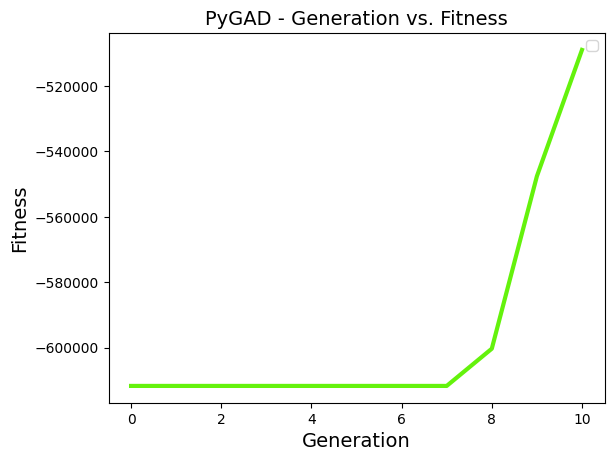

1350
1350
Iteration
0.07299985184586533
final std:
0.0715896717423082


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.01378956773626008
Iteration
0.012750938021583664
final std:
0.012146444802189653
Iteration
0.016996430207954064
Iteration
0.015737446675900008
final std:
0.015701790905087942
Iteration
0.016996430207954064
Iteration
0.015737446675900008
final std:
0.015701790905087942
Iteration
0.11368219225064224
final std:
0.11325736004603751
Iteration
0.016996430207954064
Iteration
0.015737446675900008
final std:
0.015701790905087942
Iteration
0.07506175252622155
final std:
0.07406149743868141


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


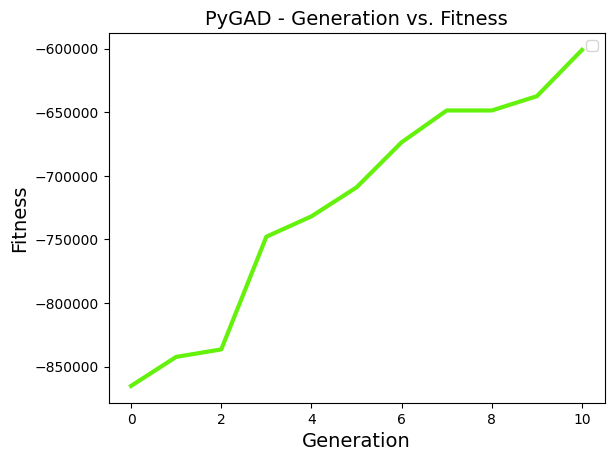

1353
1353
Iteration
0.06524556012434263
final std:
0.06462717906723008


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.018836456685409435
Iteration
0.016971951023577337
final std:
0.01656065223170547
Iteration
0.01552513575645195
Iteration
0.013497873617904105
final std:
0.013403195343698238
Iteration
0.01552513575645195
Iteration
0.013497873617904105
final std:
0.013403195343698238
Iteration
0.11317077655095903
final std:
0.11204051191661268
Iteration
0.01552513575645195
Iteration
0.013497873617904105
final std:
0.013403195343698238
Iteration
0.08795298230925201
final std:
0.08704158722718497


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


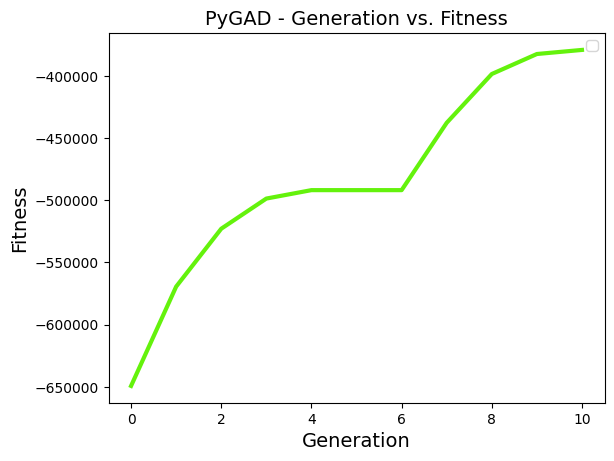

1363
1363
Iteration
0.09516397619028966
final std:
0.09459216203168014


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.013578976105288599
Iteration
0.01245293778245173
final std:
0.01199251774879024
Iteration
0.012643081205078514
Iteration
0.011525218247052563
final std:
0.011453618212543685
Iteration
0.012643081205078514
Iteration
0.011525218247052563
final std:
0.011453618212543685
Iteration
0.11434931444691758
final std:
0.1138498637844817
Iteration
0.012643081205078514
Iteration
0.011525218247052563
final std:
0.011453618212543685
Iteration
0.07216260143718817
final std:
0.07134002679293741


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


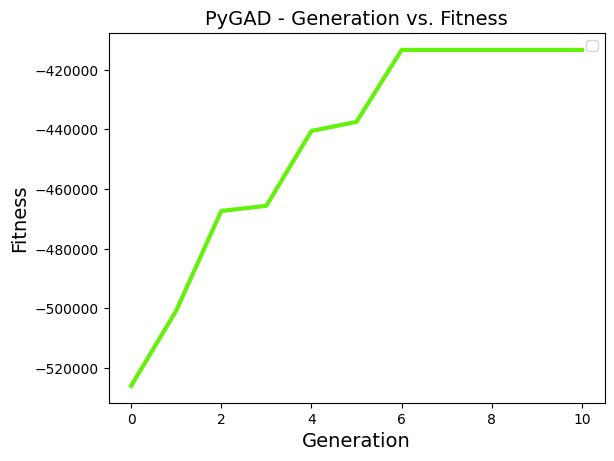

1357
1357
Iteration
0.0694485055004924
final std:
0.06906365965346196


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.01658278447286631
Iteration
0.014865260972126483
final std:
0.014670568910473374
Iteration
0.016730669364230327
Iteration
0.014713272848752111
final std:
0.01450390428915143
Iteration
0.016730669364230327
Iteration
0.014713272848752111
final std:
0.01450390428915143
Iteration
0.12179123517640539
final std:
0.12080991449122203
Iteration
0.016730669364230327
Iteration
0.014713272848752111
final std:
0.01450390428915143
Iteration
0.10171658479457264
final std:
0.10111381559110572


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


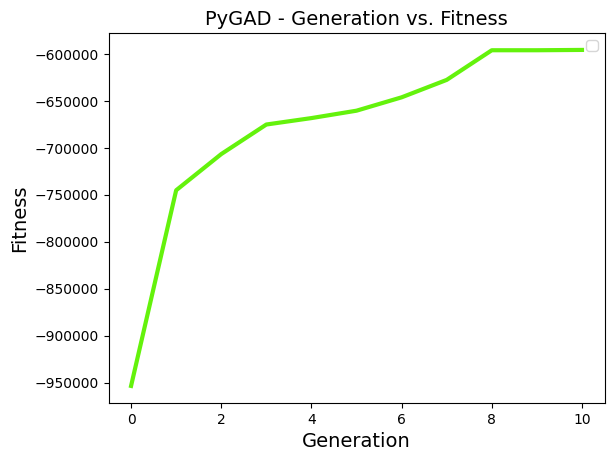

1377
1377
Iteration
0.10373141369161755
final std:
0.10311861963914859


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.013921619414544058
Iteration
0.012483110034276306
final std:
0.012327222383252383
Iteration
0.010960641537078104
Iteration
0.009184632747001337
final std:
0.009206984247388332
Iteration
0.010960641537078104
Iteration
0.009184632747001337
final std:
0.009206984247388332
Iteration
0.11345252522805124
final std:
0.11287305953010064
Iteration
0.010960641537078104
Iteration
0.009184632747001337
final std:
0.009206984247388332
Iteration
0.07991586395775167
final std:
0.0785649935574925


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


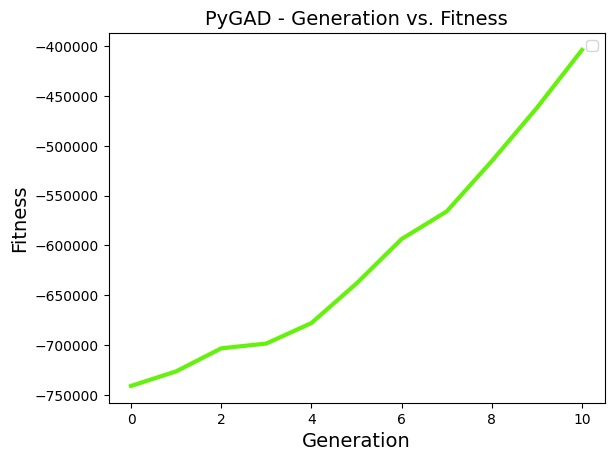

1351
1351
Iteration
0.07870460878512182
final std:
0.07821343279459808


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.015972118073080795
Iteration
0.01405125339386563
final std:
0.013671641039201429
Iteration
0.02041486320072242
Iteration
0.018824530110209764
final std:
0.018630384449193786
Iteration
0.02041486320072242
Iteration
0.018824530110209764
final std:
0.018630384449193786
Iteration
0.11090251635871365
final std:
0.10987683994873255
Iteration
0.02041486320072242
Iteration
0.018824530110209764
final std:
0.018630384449193786
Iteration
0.08660468617633221
final std:
0.085308828774447


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370
1370


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


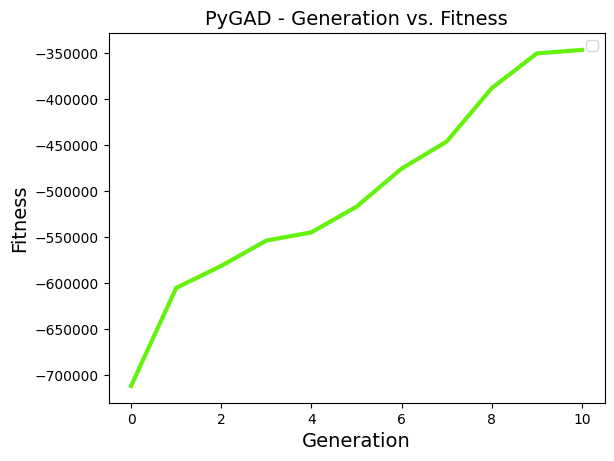

1370
1370
Iteration
0.09728823294429867
final std:
0.09647865398926676


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.014346690665397859
Iteration
0.013414910257040415
final std:
0.01301355396388857
Iteration
0.00963771315039496
Iteration
0.00847678336996586
final std:
0.00835141287260456
Iteration
0.00963771315039496
Iteration
0.00847678336996586
final std:
0.00835141287260456
Iteration
0.11517818106929743
final std:
0.1146378904901582
Iteration
0.00963771315039496
Iteration
0.00847678336996586
final std:
0.00835141287260456
Iteration
0.07914215163227856
final std:
0.07788764383150414


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


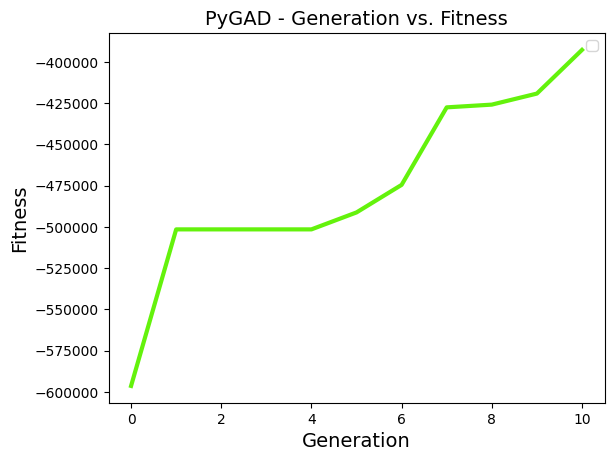

1353
1353
Iteration
0.07867549915990847
final std:
0.07821307306607951


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.012878176744886697
Iteration
0.011486641227394099
final std:
0.011056364208672086
Iteration
0.011038267589138243
Iteration
0.00911577977786917
final std:
0.009006230250088369
Iteration
0.011038267589138243
Iteration
0.00911577977786917
final std:
0.009006230250088369
Iteration
0.1153689231663818
final std:
0.1148327771319372
Iteration
0.011038267589138243
Iteration
0.00911577977786917
final std:
0.009006230250088369
Iteration
0.0920444924387574
final std:
0.09132809355167744


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


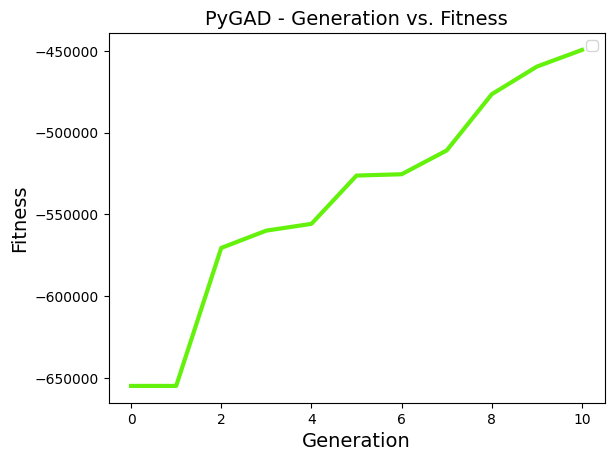

1348
1348
Iteration
0.07778476339248742
final std:
0.07723830725759649


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.02256244206495053
Iteration
0.021114086429712964
final std:
0.020786502923683496
Iteration
0.017476609976034892
Iteration
0.015541549603040748
final std:
0.015392266725800664
Iteration
0.017476609976034892
Iteration
0.015541549603040748
final std:
0.015392266725800664
Iteration
0.11386667061542026
final std:
0.11288533432364678
Iteration
0.017476609976034892
Iteration
0.015541549603040748
final std:
0.015392266725800664
Iteration
0.08734564613529197
final std:
0.08617710427010516


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


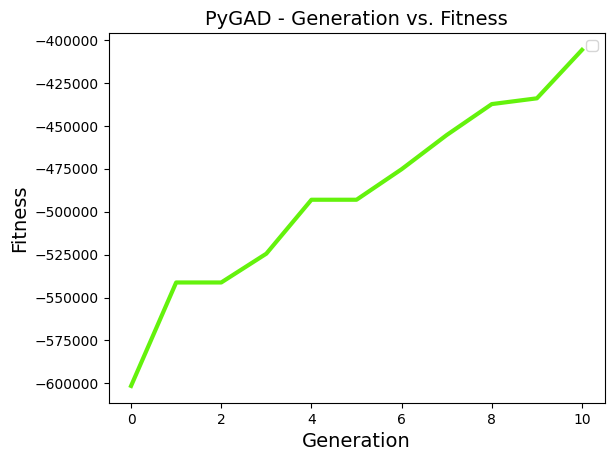

1363
1363
Iteration
0.09429560578909242
final std:
0.09367244377627801


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.013928820812717862
Iteration
0.012872475340829964
final std:
0.012443852206328935
Iteration
0.010227879409795807
Iteration
0.008378242488893987
final std:
0.008260886144365692
Iteration
0.010227879409795807
Iteration
0.008378242488893987
final std:
0.008260886144365692
Iteration
0.11436520161580116
final std:
0.1138973006181332
Iteration
0.010227879409795807
Iteration
0.008378242488893987
final std:
0.008260886144365692
Iteration
0.07368354572102834
final std:
0.07298807948285217


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


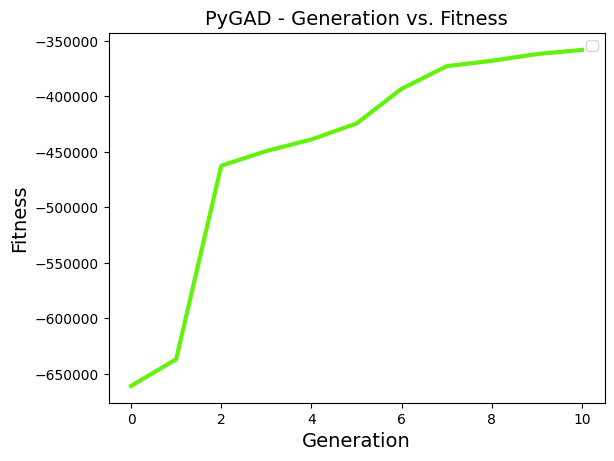

1349
1349
Iteration
0.07754054161729089
final std:
0.07707868892019214


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.01397046989871588
Iteration
0.012388684397711734
final std:
0.012179388171488599
Iteration
0.014058062847203458
Iteration
0.011800928105452914
final std:
0.011691115672444826
Iteration
0.014058062847203458
Iteration
0.011800928105452914
final std:
0.011691115672444826
Iteration
0.11652168854257643
final std:
0.11602973778538155
Iteration
0.014058062847203458
Iteration
0.011800928105452914
final std:
0.011691115672444826
Iteration
0.09160616057836668
final std:
0.09116443836554204


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


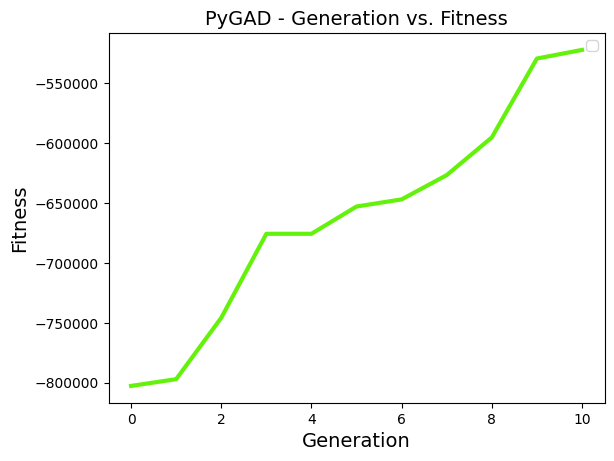

1350
1350
Iteration
0.08195523320352217
final std:
0.08158940768470141


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.016630433073723274
Iteration
0.014861080125747625
final std:
0.014581236661243564
Iteration
0.013558140377045934
Iteration
0.012145892324978523
final std:
0.011991773106480226
Iteration
0.013558140377045934
Iteration
0.012145892324978523
final std:
0.011991773106480226
Iteration
0.12347718773039726
final std:
0.12240891724078881
Iteration
0.013558140377045934
Iteration
0.012145892324978523
final std:
0.011991773106480226
Iteration
0.1026463185310438
final std:
0.10164784273841217


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


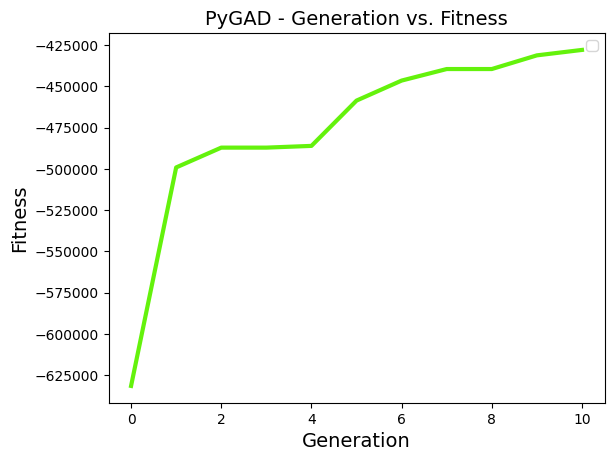

1376
1376
Iteration
0.09312970237696475
final std:
0.09252973848064859


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.01624753685254061
Iteration
0.014252518750855593
final std:
0.013905503416339442
Iteration
0.016473308119160694
Iteration
0.014048153872118743
final std:
0.013965594073260427
Iteration
0.016473308119160694
Iteration
0.014048153872118743
final std:
0.013965594073260427
Iteration
0.1113773530078254
final std:
0.11032073616334213
Iteration
0.016473308119160694
Iteration
0.014048153872118743
final std:
0.013965594073260427
Iteration
0.0836398376722501
final std:
0.08248065281883574


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


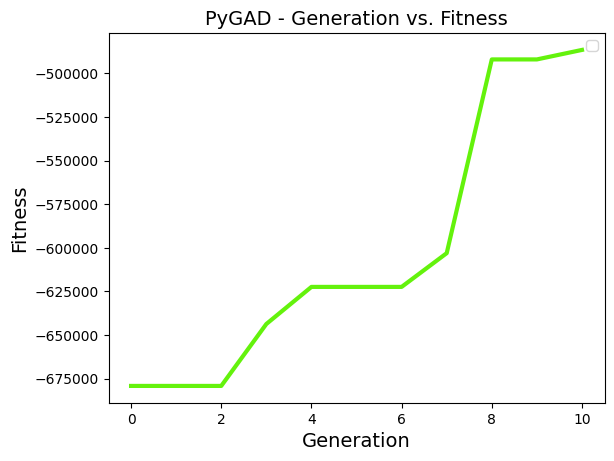

1352
1352
Iteration
0.07088779475525352
final std:
0.06999223998462992


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.01618208025242255
Iteration
0.014254008851280356
final std:
0.013971539325051907
Iteration
0.015530765805655695
Iteration
0.013589591751589365
final std:
0.013349065748979335
Iteration
0.015530765805655695
Iteration
0.013589591751589365
final std:
0.013349065748979335
Iteration
0.113540220713097
final std:
0.11251401264903187
Iteration
0.015530765805655695
Iteration
0.013589591751589365
final std:
0.013349065748979335
Iteration
0.08375084889306449
final std:
0.08247642752514309


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


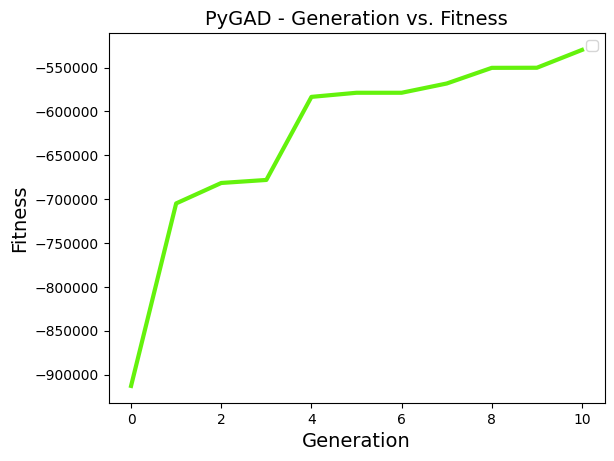

1364
1364
Iteration
0.08813519302051076
final std:
0.08749993415094805


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.01292189950175331
Iteration
0.011869782979672474
final std:
0.011438930246139239
Iteration
0.012901655657951311
Iteration
0.010698343968629044
final std:
0.01066143957034844
Iteration
0.012901655657951311
Iteration
0.010698343968629044
final std:
0.01066143957034844
Iteration
0.11492498586979416
final std:
0.11438412999215115
Iteration
0.012901655657951311
Iteration
0.010698343968629044
final std:
0.01066143957034844
Iteration
0.07400934662840264
final std:
0.07330946980397618


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


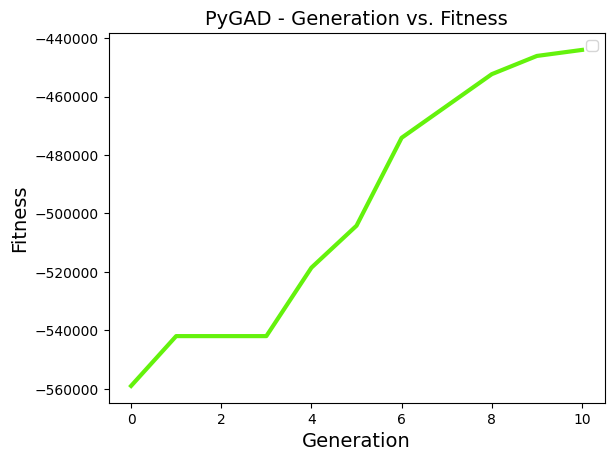

1350
1350
Iteration
0.07776940455951366
final std:
0.07745793489671061


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.0164645747609459
Iteration
0.014338339038015001
final std:
0.013938127145893943
Iteration
0.014729184245069723
Iteration
0.01299556919470083
final std:
0.012814055497796252
Iteration
0.014729184245069723
Iteration
0.01299556919470083
final std:
0.012814055497796252
Iteration
0.11330270740810908
final std:
0.11223261406142995
Iteration
0.014729184245069723
Iteration
0.01299556919470083
final std:
0.012814055497796252
Iteration
0.0807552864042927
final std:
0.07864399667886661


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359
1359


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


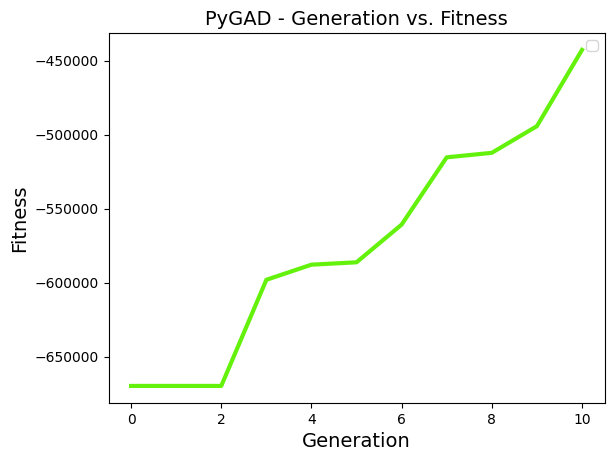

1359
1359
Iteration
0.10579020170813573
final std:
0.1047166965179033


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.016067499388257914
Iteration
0.014163455104756606
final std:
0.013845074631951289
Iteration
0.01454352372044674
Iteration
0.012801032620828287
final std:
0.012632968122957
Iteration
0.01454352372044674
Iteration
0.012801032620828287
final std:
0.012632968122957
Iteration
0.11647999105960008
final std:
0.11547111217189177
Iteration
0.01454352372044674
Iteration
0.012801032620828287
final std:
0.012632968122957
Iteration
0.09715037391650322
final std:
0.09634823426836849


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


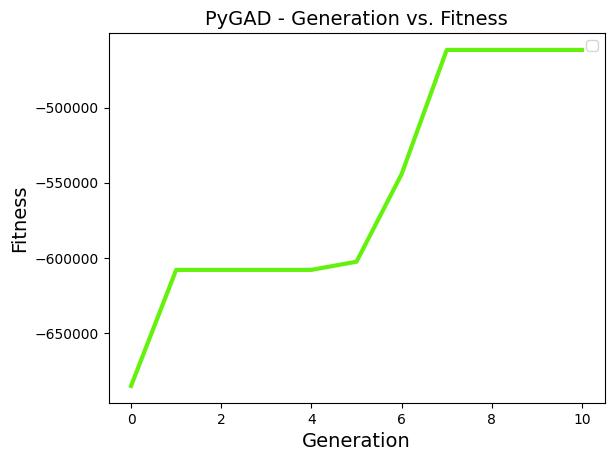

1365
1365
Iteration
0.09483890022882563
final std:
0.09413496231711638


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.0166172723654288
Iteration
0.014651978147578603
final std:
0.014393463476763848
Iteration
0.0140780868032125
Iteration
0.012540433970277402
final std:
0.012325018346021744
Iteration
0.0140780868032125
Iteration
0.012540433970277402
final std:
0.012325018346021744
Iteration
0.1208326544729902
final std:
0.11986564394603472
Iteration
0.0140780868032125
Iteration
0.012540433970277402
final std:
0.012325018346021744
Iteration
0.10304561088826363
final std:
0.10208204035079682


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379
1379


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


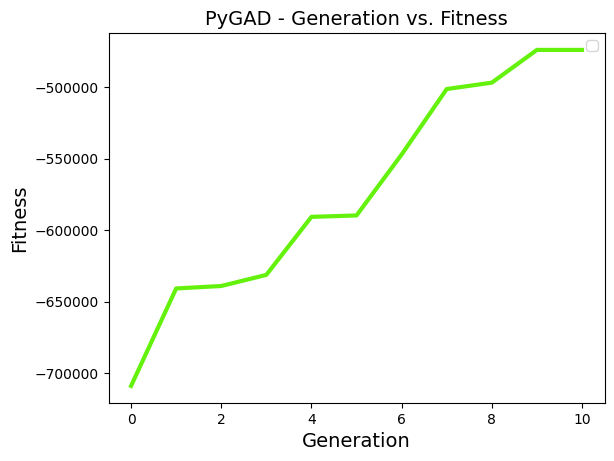

1379
1379
Iteration
0.09944863513328943
final std:
0.0987456710885896


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.013671480614641136
Iteration
0.012030128183879525
final std:
0.011724664561384813
Iteration
0.011124737451575247
Iteration
0.008483538525145521
final std:
0.008337475205081223
Iteration
0.011124737451575247
Iteration
0.008483538525145521
final std:
0.008337475205081223
Iteration
0.11335442618449425
final std:
0.11279293469175652
Iteration
0.011124737451575247
Iteration
0.008483538525145521
final std:
0.008337475205081223
Iteration
0.07287375352351945
final std:
0.07092012780677813


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346
1346


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


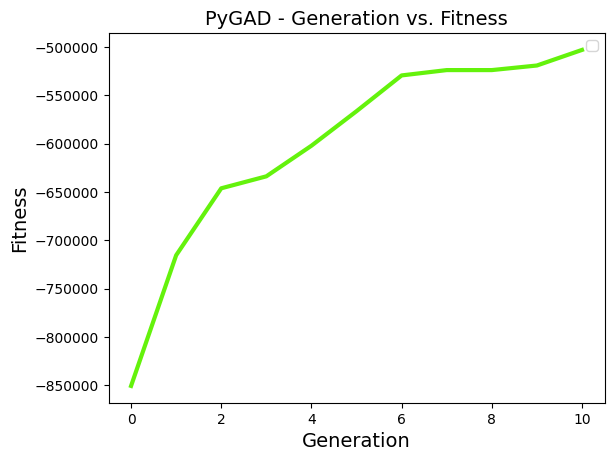

1346
1346
Iteration
0.0803173390614814
final std:
0.07895975888697326


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.013815313515115614
Iteration
0.01256634791778978
final std:
0.012024820598277844
Iteration
0.013265112332847852
Iteration
0.012244712503028455
final std:
0.012221918262621475
Iteration
0.013265112332847852
Iteration
0.012244712503028455
final std:
0.012221918262621475
Iteration
0.1150876195071518
final std:
0.11470014722230062
Iteration
0.013265112332847852
Iteration
0.012244712503028455
final std:
0.012221918262621475
Iteration
0.07081755628192475
final std:
0.07000914115706874


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


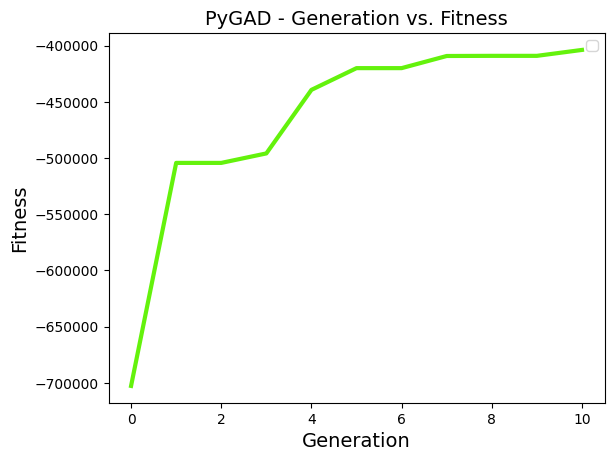

1354
1354
Iteration
0.07715593084411644
final std:
0.07669764684121408


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.014603249008768292
Iteration
0.013647266573288559
final std:
0.01341372928589282
Iteration
0.010692914275555462
Iteration
0.009090815679711806
final std:
0.008925289979294287
Iteration
0.010692914275555462
Iteration
0.009090815679711806
final std:
0.008925289979294287
Iteration
0.11409963477011383
final std:
0.11349042670565862
Iteration
0.010692914275555462
Iteration
0.009090815679711806
final std:
0.008925289979294287
Iteration
0.06505536032255019
final std:
0.06433957515684718


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357
1357


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


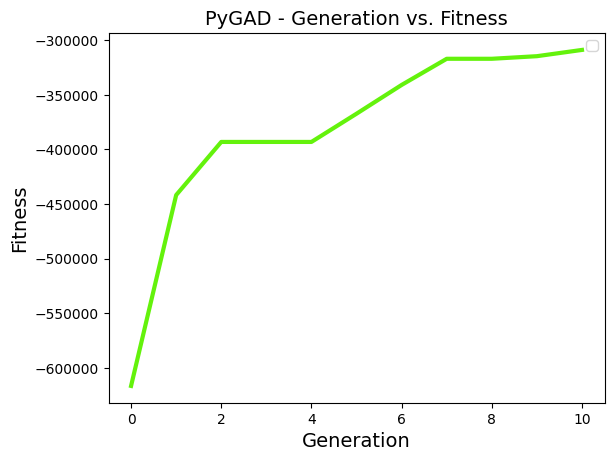

1357
1357
Iteration
0.07648412552728127
final std:
0.07596413700561955


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.014152266108325741
Iteration
0.013090119558298698
final std:
0.012671808280082424
Iteration
0.009338409352940762
Iteration
0.007790523689103794
final std:
0.007637996820624977
Iteration
0.009338409352940762
Iteration
0.007790523689103794
final std:
0.007637996820624977
Iteration
0.11386198003254866
final std:
0.1133735620130964
Iteration
0.009338409352940762
Iteration
0.007790523689103794
final std:
0.007637996820624977
Iteration
0.07366622280573475
final std:
0.07315882280462371


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


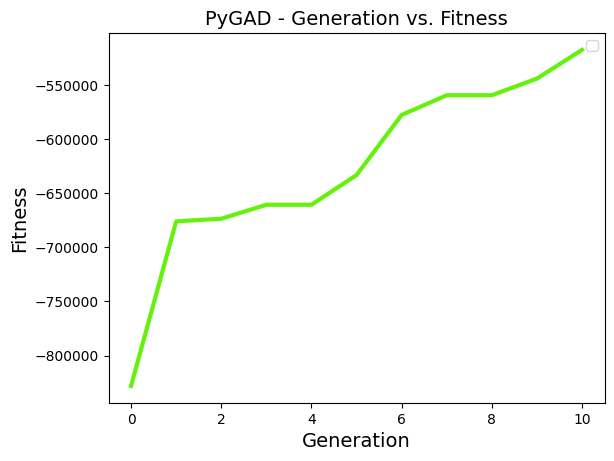

1353
1353
Iteration
0.07275952225182558
final std:
0.07210859840497041


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.013631664940351907
Iteration
0.012396747389750898
final std:
0.012063480651236342
Iteration
0.013016504369209375
Iteration
0.011779058908103282
final std:
0.011680816156240852
Iteration
0.013016504369209375
Iteration
0.011779058908103282
final std:
0.011680816156240852
Iteration
0.1137711940569368
final std:
0.11329172648801117
Iteration
0.013016504369209375
Iteration
0.011779058908103282
final std:
0.011680816156240852
Iteration
0.07466482147615575
final std:
0.07384071208021249


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


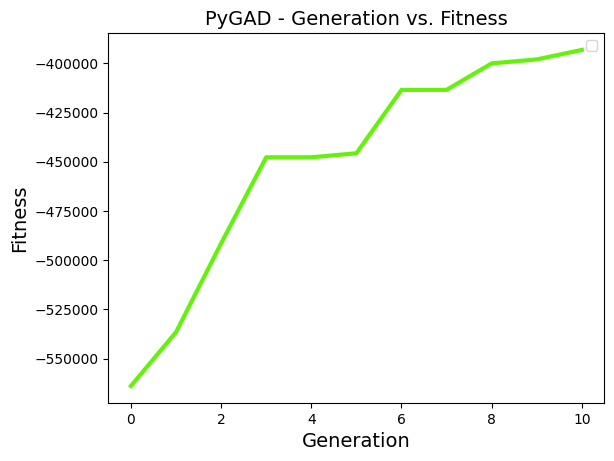

1350
1350
Iteration
0.06391296003904078
final std:
0.06301874460844312


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.014172962703707416
Iteration
0.012909152708502292
final std:
0.01249962876398093
Iteration
0.012360629982098963
Iteration
0.01075094441859478
final std:
0.010684981232174217
Iteration
0.012360629982098963
Iteration
0.01075094441859478
final std:
0.010684981232174217
Iteration
0.11488855035941405
final std:
0.11429796989336286
Iteration
0.012360629982098963
Iteration
0.01075094441859478
final std:
0.010684981232174217
Iteration
0.07379280246976583
final std:
0.07209406788663417


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


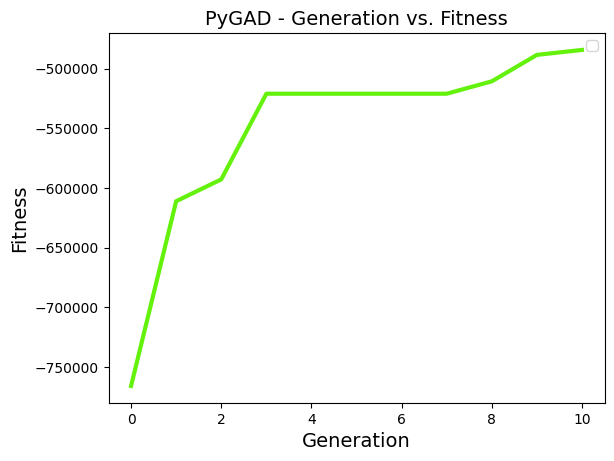

1349
1349
Iteration
0.0726872752752182
final std:
0.07186195105577015


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.01585923600767876
Iteration
0.013883496561350744
final std:
0.013608888719855676
Iteration
0.018609377816565693
Iteration
0.016587132870947742
final std:
0.016431834064487835
Iteration
0.018609377816565693
Iteration
0.016587132870947742
final std:
0.016431834064487835
Iteration
0.11699909703681892
final std:
0.11588273210750513
Iteration
0.018609377816565693
Iteration
0.016587132870947742
final std:
0.016431834064487835
Iteration
0.08592274989767094
final std:
0.08475980294412751


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


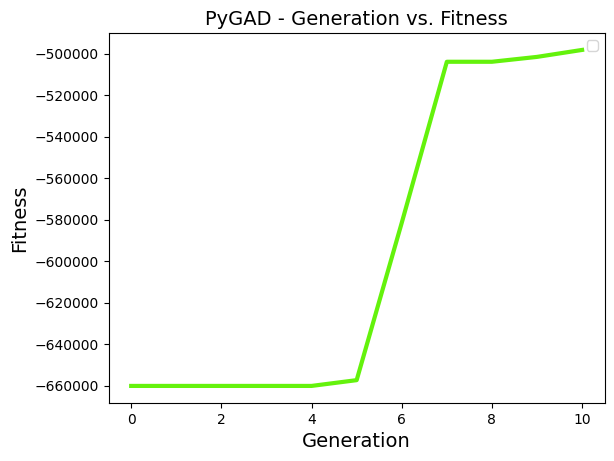

1364
1364
Iteration
0.09108909129571824
final std:
0.09016098470728208


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.015962942284424804
Iteration
0.014014848526924393
final std:
0.013828362750408649
Iteration
0.015558208592920654
Iteration
0.013017119436743062
final std:
0.01278164082582771
Iteration
0.015558208592920654
Iteration
0.013017119436743062
final std:
0.01278164082582771
Iteration
0.11085142139077457
final std:
0.10979062890106439
Iteration
0.015558208592920654
Iteration
0.013017119436743062
final std:
0.01278164082582771
Iteration
0.09413083840140289
final std:
0.09286328192950008


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


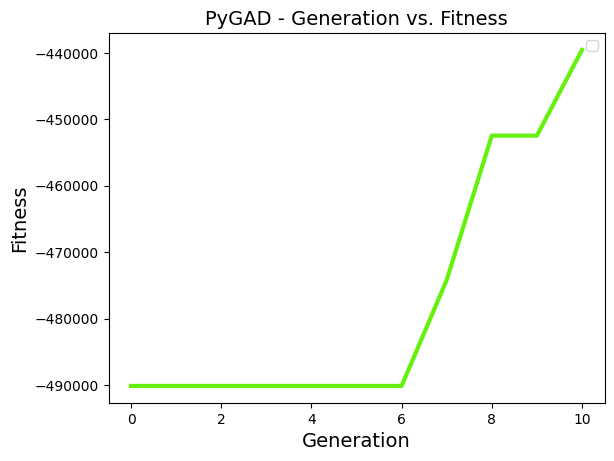

1348
1348
Iteration
0.09556123270284993
final std:
0.09485353445929685


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.013807127701982138
Iteration
0.012765055993304566
final std:
0.012205582898045348
Iteration
0.01517410556408589
Iteration
0.013799791082396026
final std:
0.013740157984573507
Iteration
0.01517410556408589
Iteration
0.013799791082396026
final std:
0.013740157984573507
Iteration
0.11301648702185593
final std:
0.11257781343629726
Iteration
0.01517410556408589
Iteration
0.013799791082396026
final std:
0.013740157984573507
Iteration
0.06751202039479112
final std:
0.06692552600718704


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


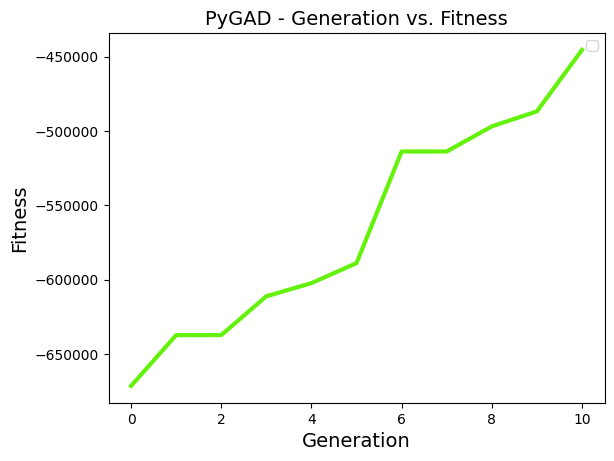

1349
1349
Iteration
0.06210303467578682
final std:
0.061594937875144105


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.014379016186499491
Iteration
0.013544511723136374
final std:
0.013057746896698166
Iteration
0.009450341381050905
Iteration
0.008147274373556168
final std:
0.007983002756305538
Iteration
0.009450341381050905
Iteration
0.008147274373556168
final std:
0.007983002756305538
Iteration
0.11468869480057525
final std:
0.11407492258758951
Iteration
0.009450341381050905
Iteration
0.008147274373556168
final std:
0.007983002756305538
Iteration
0.06727415645859869
final std:
0.06685053266470535


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


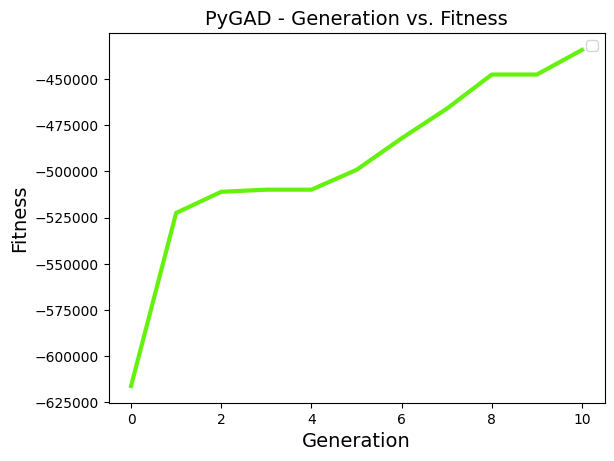

1354
1354
Iteration
0.08189508535559643
final std:
0.08135508279851916


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.016643895588260918
Iteration
0.014692139878674383
final std:
0.014469290372783201
Iteration
0.014882886642461257
Iteration
0.013228112246346995
final std:
0.013042446810308075
Iteration
0.014882886642461257
Iteration
0.013228112246346995
final std:
0.013042446810308075
Iteration
0.1165045458860689
final std:
0.11553499695795506
Iteration
0.014882886642461257
Iteration
0.013228112246346995
final std:
0.013042446810308075
Iteration
0.09624170769101241
final std:
0.0951958746215186


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


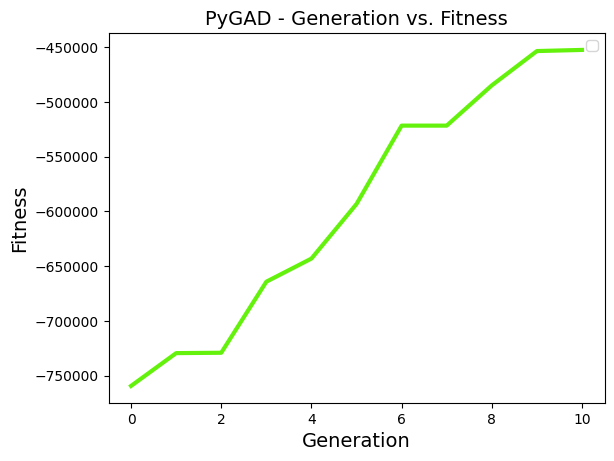

1376
1376
Iteration
0.09728854738704774
final std:
0.096389247835222


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.013646003494275718
Iteration
0.012625811127895625
final std:
0.012067491858445863
Iteration
0.016960168446728565
Iteration
0.01574155939868232
final std:
0.015707395753242676
Iteration
0.016960168446728565
Iteration
0.01574155939868232
final std:
0.015707395753242676
Iteration
0.11369501741172448
final std:
0.11322299269066481
Iteration
0.016960168446728565
Iteration
0.01574155939868232
final std:
0.015707395753242676
Iteration
0.06372114393750038
final std:
0.06306411115858494


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


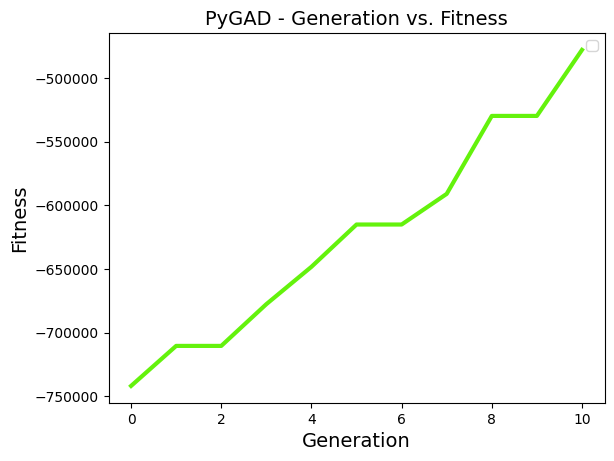

1349
1349
Iteration
0.07413083998572922
final std:
0.07340239457153118


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.01575874659401273
Iteration
0.01408830762766903
final std:
0.013850781908484718
Iteration
0.0144335700194202
Iteration
0.012819454302234294
final std:
0.012616455093318539
Iteration
0.0144335700194202
Iteration
0.012819454302234294
final std:
0.012616455093318539
Iteration
0.11701287068818332
final std:
0.11607023242856661
Iteration
0.0144335700194202
Iteration
0.012819454302234294
final std:
0.012616455093318539
Iteration
0.09333163717490735
final std:
0.09233510099451563


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376
1376


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


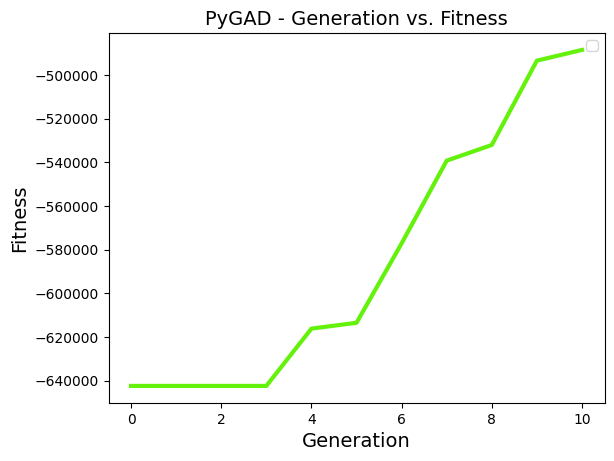

1376
1376
Iteration
0.09485697087077166
final std:
0.09398755995386716


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.013577854425800012
Iteration
0.012129012304539135
final std:
0.01187796949677044
Iteration
0.010395726761108438
Iteration
0.008091936220205527
final std:
0.00796214835525632
Iteration
0.010395726761108438
Iteration
0.008091936220205527
final std:
0.00796214835525632
Iteration
0.11430711193158678
final std:
0.11380481157334069
Iteration
0.010395726761108438
Iteration
0.008091936220205527
final std:
0.00796214835525632
Iteration
0.07378329061436087
final std:
0.07280069840089608


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


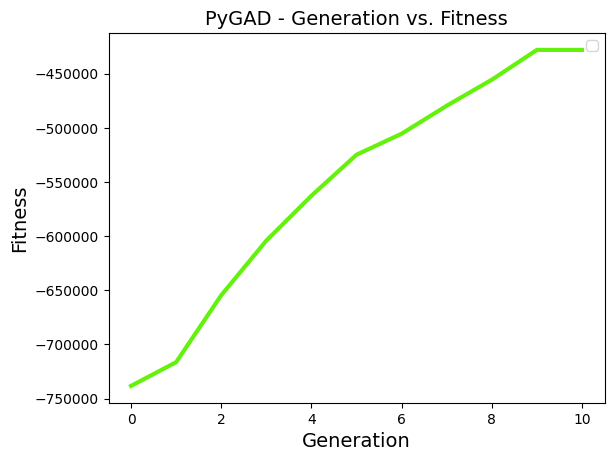

1350
1350
Iteration
0.07593107443856517
final std:
0.0751093473555897


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.01619257801621027
Iteration
0.014125115744373579
final std:
0.013775159445499103
Iteration
0.014171461101615136
Iteration
0.0125657502211633
final std:
0.012397191659745873
Iteration
0.014171461101615136
Iteration
0.0125657502211633
final std:
0.012397191659745873
Iteration
0.11593407868471141
final std:
0.1149641402122974
Iteration
0.014171461101615136
Iteration
0.0125657502211633
final std:
0.012397191659745873
Iteration
0.08373409671129554
final std:
0.08276978363550805


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


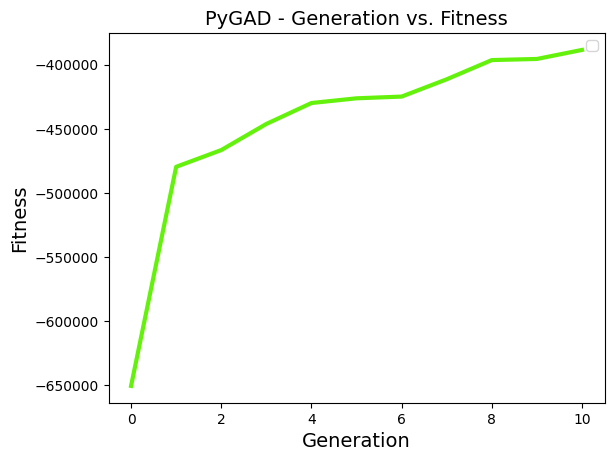

1365
1365
Iteration
0.09703935531977695
final std:
0.09613812426040211


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.012932497964561692
Iteration
0.011365194351362264
final std:
0.011159349713024689
Iteration
0.011618932894882833
Iteration
0.009725886421192197
final std:
0.009628588298661618
Iteration
0.011618932894882833
Iteration
0.009725886421192197
final std:
0.009628588298661618
Iteration
0.11470173902487953
final std:
0.11416048756442697
Iteration
0.011618932894882833
Iteration
0.009725886421192197
final std:
0.009628588298661618
Iteration
0.08036561247686662
final std:
0.07909513288180942


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


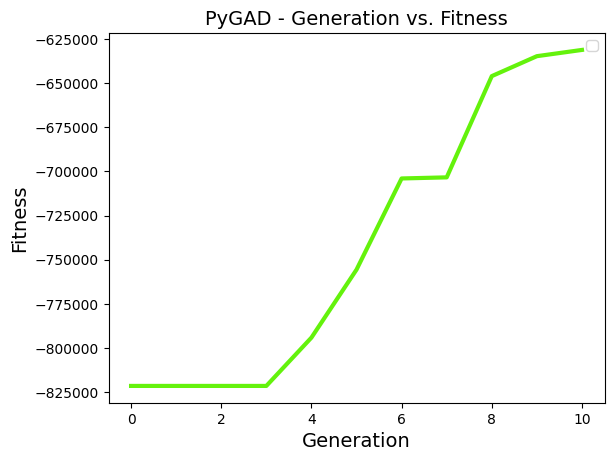

1347
1347
Iteration
0.06811332756497686
final std:
0.06744265286156337


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.013102527406122316
Iteration
0.011625060575165111
final std:
0.01131882631914887
Iteration
0.011781864381429029
Iteration
0.00977736307903288
final std:
0.009666079500757077
Iteration
0.011781864381429029
Iteration
0.00977736307903288
final std:
0.009666079500757077
Iteration
0.11660361745353899
final std:
0.11609843800600952
Iteration
0.011781864381429029
Iteration
0.00977736307903288
final std:
0.009666079500757077
Iteration
0.09031462116848633
final std:
0.08973652628943983


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


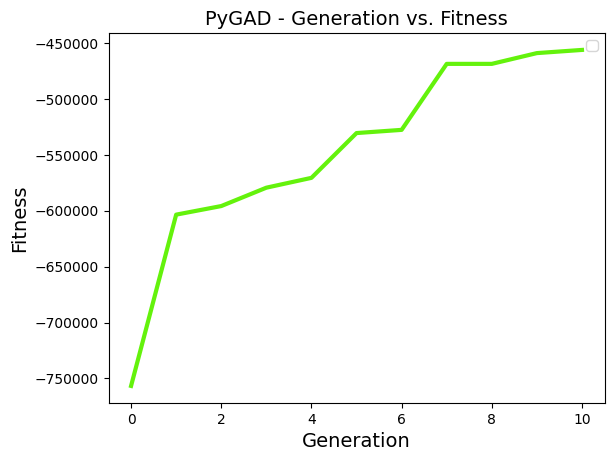

1347
1347
Iteration
0.07136797220795414
final std:
0.07071998487332443


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.013976565843225344
Iteration
0.012945326099624607
Iteration
0.012232555807397787
final std:
0.011723065288635568
Iteration
0.01471430164228256
Iteration
0.01323322498064823
final std:
0.013194333677112728
Iteration
0.01471430164228256
Iteration
0.01323322498064823
final std:
0.013194333677112728
Iteration
0.11353688255654744
final std:
0.11308615396554142
Iteration
0.01471430164228256
Iteration
0.01323322498064823
final std:
0.013194333677112728
Iteration
0.06859078566266016
final std:
0.06768274580595025


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


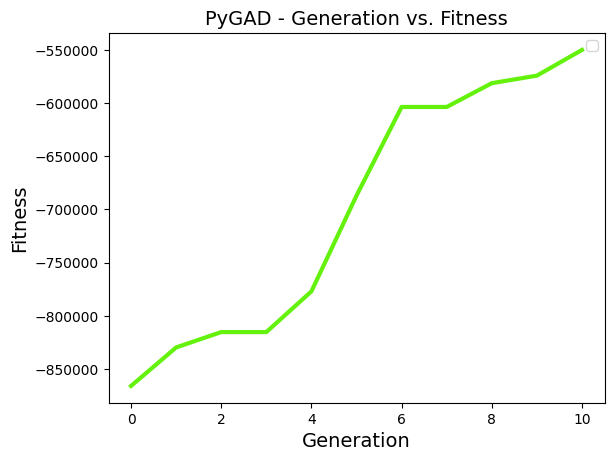

1349
1349
Iteration
0.07394121059686407
final std:
0.07289058453594523


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.01367848765488265
Iteration
0.012330209985193954
final std:
0.012179018357495425
Iteration
0.01107788532705561
Iteration
0.009273000422470567
final std:
0.008999050557137879
Iteration
0.01107788532705561
Iteration
0.009273000422470567
final std:
0.008999050557137879
Iteration
0.1153137831802736
final std:
0.1147539464031114
Iteration
0.01107788532705561
Iteration
0.009273000422470567
final std:
0.008999050557137879
Iteration
0.06681170440672347
final std:
0.0656720283012102


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


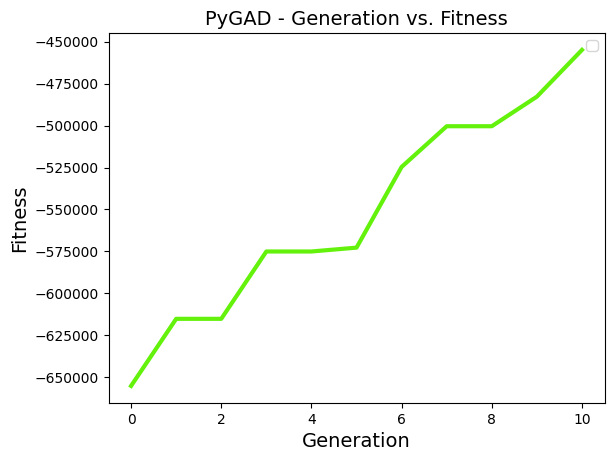

1350
1350
Iteration
0.06998238970736406
final std:
0.06940794104153676


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.012844627462759772
Iteration
0.011456033561665226
final std:
0.011061810058843177
Iteration
0.011447889467354116
Iteration
0.009591891864725437
final std:
0.009554604554612805
Iteration
0.011447889467354116
Iteration
0.009591891864725437
final std:
0.009554604554612805
Iteration
0.11688452220097359
final std:
0.11639273494243811
Iteration
0.011447889467354116
Iteration
0.009591891864725437
final std:
0.009554604554612805
Iteration
0.06980194846977907
final std:
0.06853045472314592


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


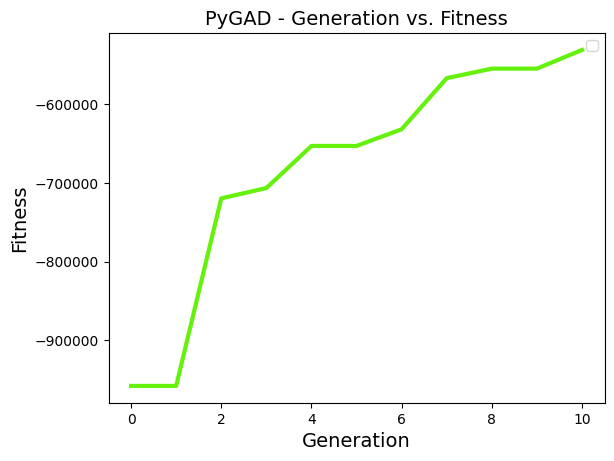

1349
1349
Iteration
0.0704628694673976
final std:
0.06981559523655691


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.01295237497952912
Iteration
0.011572686163105878
final std:
0.01122716607927476
Iteration
0.011194813295463058
Iteration
0.009217974279078996
final std:
0.00921545191797963
Iteration
0.011194813295463058
Iteration
0.009217974279078996
final std:
0.00921545191797963
Iteration
0.11526187884544842
final std:
0.11470441053379335
Iteration
0.011194813295463058
Iteration
0.009217974279078996
final std:
0.00921545191797963
Iteration
0.08816560066996994
final std:
0.08766521847175496


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


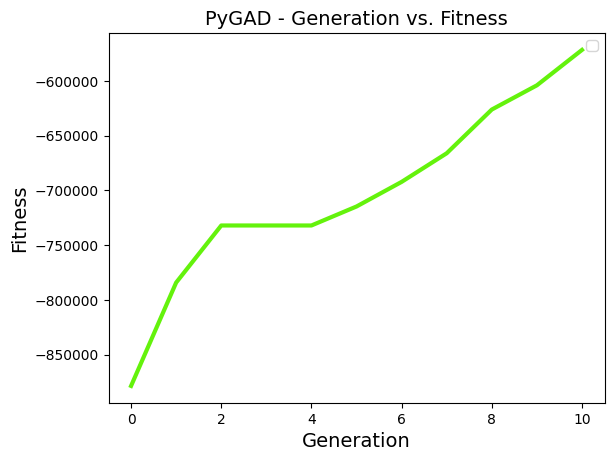

1349
1349
Iteration
0.07009311353816913
final std:
0.06888835661655208


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.01414043173833582
Iteration
0.01297630285621065
final std:
0.012400498772379613
Iteration
0.017885388533539763
Iteration
0.01638999957028971
final std:
0.016352312986476956
Iteration
0.017885388533539763
Iteration
0.01638999957028971
final std:
0.016352312986476956
Iteration
0.11337653646440311
final std:
0.112943275418273
Iteration
0.017885388533539763
Iteration
0.01638999957028971
final std:
0.016352312986476956
Iteration
0.07119262960328614
final std:
0.07056500528565898


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


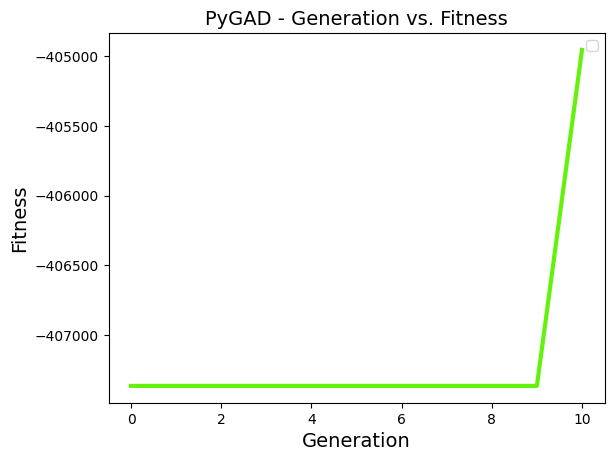

1352
1352
Iteration
0.06289720098398073
final std:
0.06239578933377944


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.012924230576642635
Iteration
0.011767494894454254
final std:
0.011449415810480831
Iteration
0.010037419445551242
Iteration
0.008345719433370317
final std:
0.008237380255510535
Iteration
0.010037419445551242
Iteration
0.008345719433370317
final std:
0.008237380255510535
Iteration
0.11507779799539845
final std:
0.11454826145488477
Iteration
0.010037419445551242
Iteration
0.008345719433370317
final std:
0.008237380255510535
Iteration
0.07019098142497347
final std:
0.06963057481572896


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


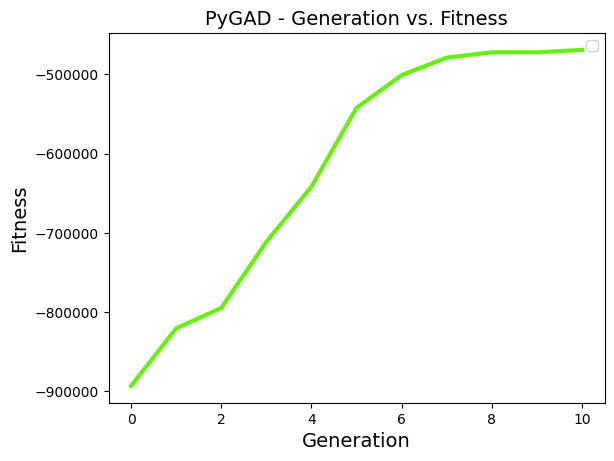

1352
1352
Iteration
0.0676717250660019
final std:
0.06721015867143491


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.013450069536430867
Iteration
0.012143761907032233
final std:
0.011715753619801678
Iteration
0.010185535866229055
Iteration
0.00819504118901704
final std:
0.008053037942474752
Iteration
0.010185535866229055
Iteration
0.00819504118901704
final std:
0.008053037942474752
Iteration
0.11310710157279878
final std:
0.11252611527665737
Iteration
0.010185535866229055
Iteration
0.00819504118901704
final std:
0.008053037942474752
Iteration
0.07869248135280969
final std:
0.07811487009144047


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


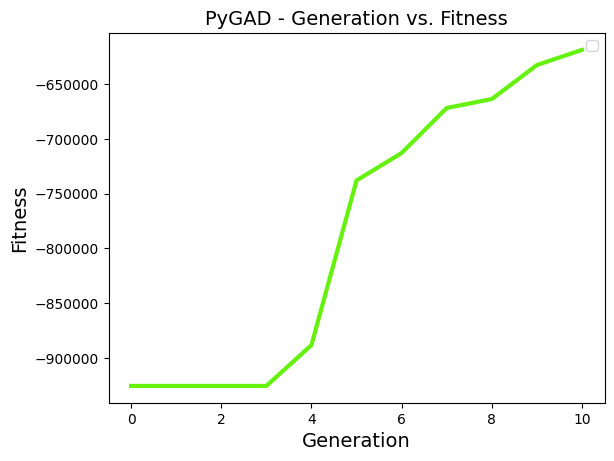

1348
1348
Iteration
0.07728471270783567
final std:
0.0766353772049057


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.013589144744727714
Iteration
0.012332223128038606
final std:
0.011959781215623935
Iteration
0.009856503842488458
Iteration
0.00810320172766225
final std:
0.008044000020337536
Iteration
0.009856503842488458
Iteration
0.00810320172766225
final std:
0.008044000020337536
Iteration
0.1149337935138771
final std:
0.11445987029223217
Iteration
0.009856503842488458
Iteration
0.00810320172766225
final std:
0.008044000020337536
Iteration
0.07157080443268524
final std:
0.07068557766222465


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


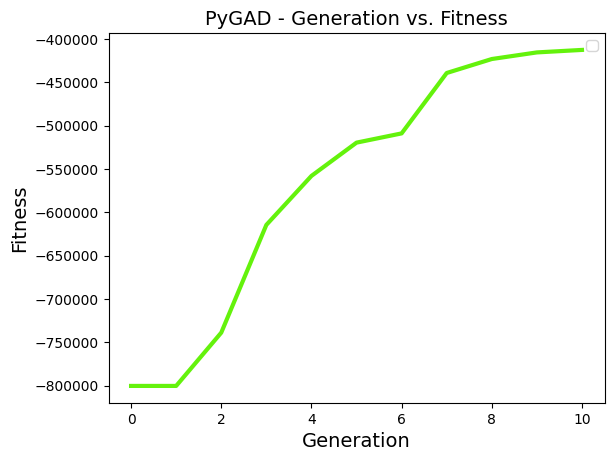

1354
1354
Iteration
0.08458103037527923
final std:
0.08424427961756034


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.014017109054175858
Iteration
0.013075444894044814
final std:
0.012702812721564847
Iteration
0.011811974031913247
Iteration
0.010134595915092384
final std:
0.010002684405138103
Iteration
0.011811974031913247
Iteration
0.010134595915092384
final std:
0.010002684405138103
Iteration
0.11438168528925136
final std:
0.11382762818683267
Iteration
0.011811974031913247
Iteration
0.010134595915092384
final std:
0.010002684405138103
Iteration
0.08721060338720216
final std:
0.08656213870936091


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


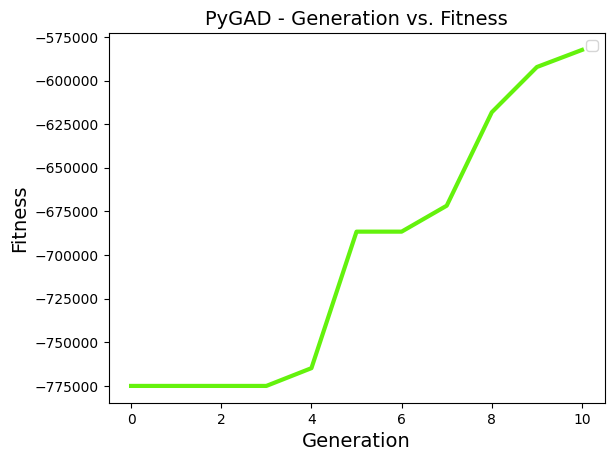

1354
1354
Iteration
0.08155712250080048
final std:
0.08121564457177852


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.016222990160852834
Iteration
0.014246861487613305
final std:
0.013970498004808846
Iteration
0.015202010517769659
Iteration
0.013484606016966506
final std:
0.013315186733235566
Iteration
0.015202010517769659
Iteration
0.013484606016966506
final std:
0.013315186733235566
Iteration
0.11381932052963074
final std:
0.11276043359220718
Iteration
0.015202010517769659
Iteration
0.013484606016966506
final std:
0.013315186733235566
Iteration
0.10203741133797639
final std:
0.10097437770199823


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


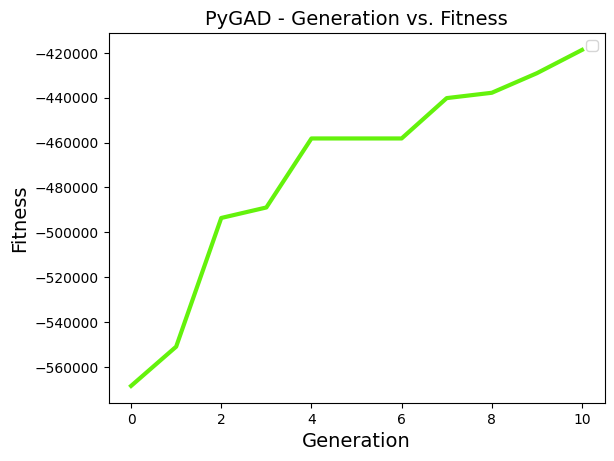

1367
1367
Iteration
0.08152721672749204
final std:
0.079848310861236


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.01286003983934468
Iteration
0.011557381633179506
final std:
0.011147992005050428
Iteration
0.011169882278334048
Iteration
0.009540959351090674
final std:
0.009404935340143005
Iteration
0.011169882278334048
Iteration
0.009540959351090674
final std:
0.009404935340143005
Iteration
0.11579508714286091
final std:
0.1152026615830393
Iteration
0.011169882278334048
Iteration
0.009540959351090674
final std:
0.009404935340143005
Iteration
0.08274498872721675
final std:
0.08223558610333764


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


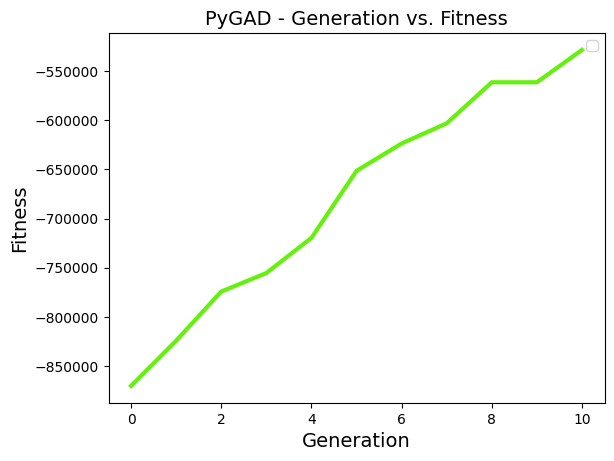

1349
1349
Iteration
0.08472139953720345
final std:
0.08441070478574496


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.013438069974426816
Iteration
0.012146859693805948
final std:
0.011868859587735205
Iteration
0.011704384976782896
Iteration
0.009817696412457815
final std:
0.009696815719969307
Iteration
0.011704384976782896
Iteration
0.009817696412457815
final std:
0.009696815719969307
Iteration
0.11366755195551874
final std:
0.11318446972450882
Iteration
0.011704384976782896
Iteration
0.009817696412457815
final std:
0.009696815719969307
Iteration
0.07963669565699005
final std:
0.07825923205513251


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


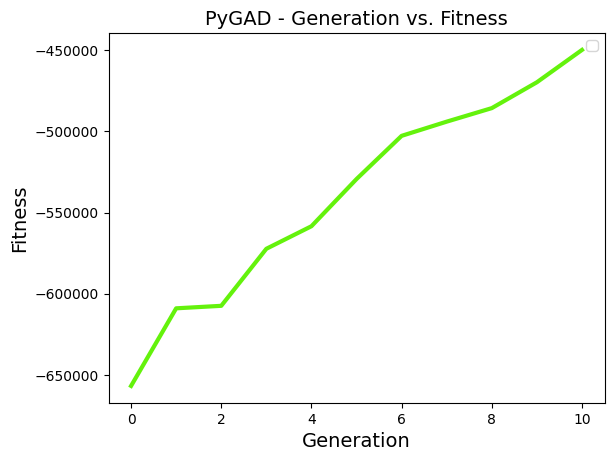

1350
1350
Iteration
0.07990281701868975
final std:
0.0794269834887574


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.013559878048350687
Iteration
0.01244067022754792
final std:
0.012053921831895279
Iteration
0.013301148512339012
Iteration
0.011834153189986391
final std:
0.011746487547336988
Iteration
0.013301148512339012
Iteration
0.011834153189986391
final std:
0.011746487547336988
Iteration
0.11454050356939526
final std:
0.11405603405024706
Iteration
0.013301148512339012
Iteration
0.011834153189986391
final std:
0.011746487547336988
Iteration
0.08650363644925406
final std:
0.08587314458356822


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


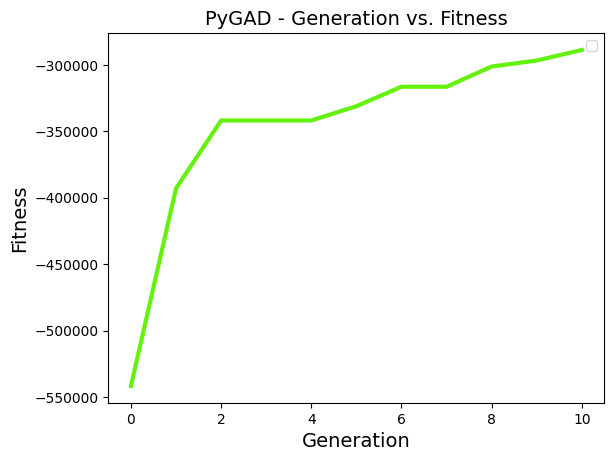

1355
1355
Iteration
0.06702999714303456
final std:
0.06616153976667447


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.014270685096582568
Iteration
0.01335096317667692
final std:
0.012929835823978124
Iteration
0.011809358556720712
Iteration
0.010165877673051603
final std:
0.010005253862913215
Iteration
0.011809358556720712
Iteration
0.010165877673051603
final std:
0.010005253862913215
Iteration
0.11439993000579801
final std:
0.11381203498724748
Iteration
0.011809358556720712
Iteration
0.010165877673051603
final std:
0.010005253862913215
Iteration
0.07679130285330901
final std:
0.07603459755343858


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


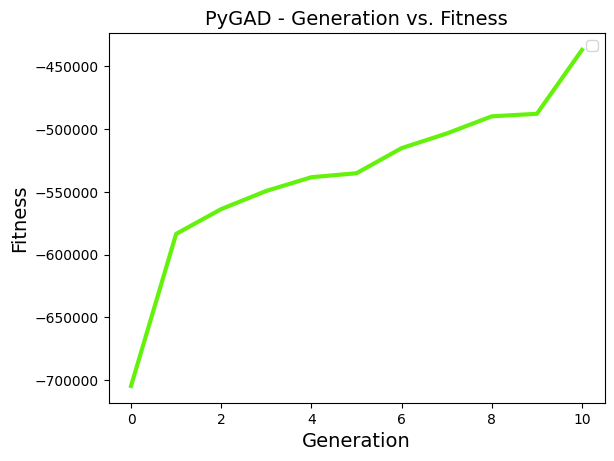

1354
1354
Iteration
0.06813549638139495
final std:
0.06748012183702752


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.01604792236855692
Iteration
0.014067788337803117
final std:
0.013759765586044652
Iteration
0.014512014379818809
Iteration
0.012958087623336171
final std:
0.012787779164098319
Iteration
0.014512014379818809
Iteration
0.012958087623336171
final std:
0.012787779164098319
Iteration
0.11643815797370481
final std:
0.11542767469688313
Iteration
0.014512014379818809
Iteration
0.012958087623336171
final std:
0.012787779164098319
Iteration
0.08329234334068869
final std:
0.08235439524960352


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


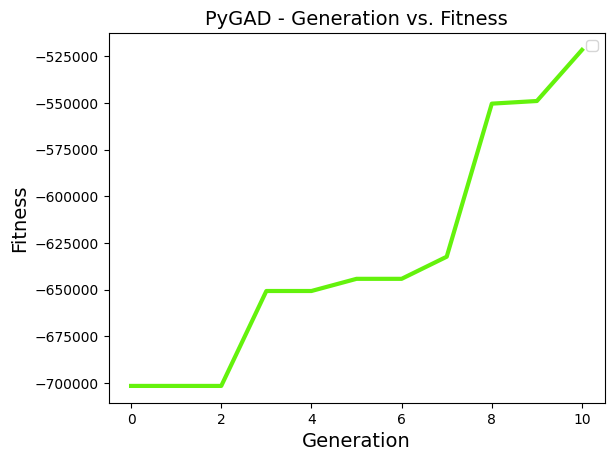

1364
1364
Iteration
0.08547567087421316
final std:
0.0845742460364101


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.016018182087553606
Iteration
0.013808289991313047
final std:
0.01352865586465908
Iteration
0.01639563860987758
Iteration
0.014069506898054142
final std:
0.013903465916414694
Iteration
0.01639563860987758
Iteration
0.014069506898054142
final std:
0.013903465916414694
Iteration
0.11294438073660969
final std:
0.1118893525657192
Iteration
0.01639563860987758
Iteration
0.014069506898054142
final std:
0.013903465916414694
Iteration
0.09718940975790506
final std:
0.09617853127935029


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


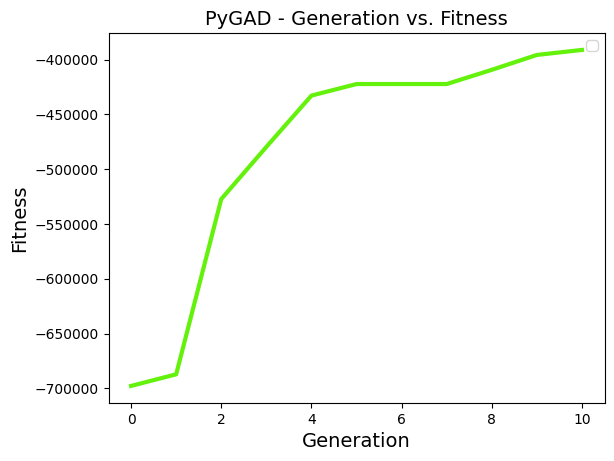

1352
1352
Iteration
0.09868161741514998
final std:
0.09799801996599754


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.013906522159665776
Iteration
0.012836385205959032
final std:
0.012311489493513673
Iteration
0.014339883375097255
Iteration
0.012963180929461336
final std:
0.012918180739581444
Iteration
0.014339883375097255
Iteration
0.012963180929461336
final std:
0.012918180739581444
Iteration
0.1037346338285062
final std:
0.10328198403148954
Iteration
0.014339883375097255
Iteration
0.012963180929461336
final std:
0.012918180739581444
Iteration
0.07432235341404679
final std:
0.07380734898707862


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


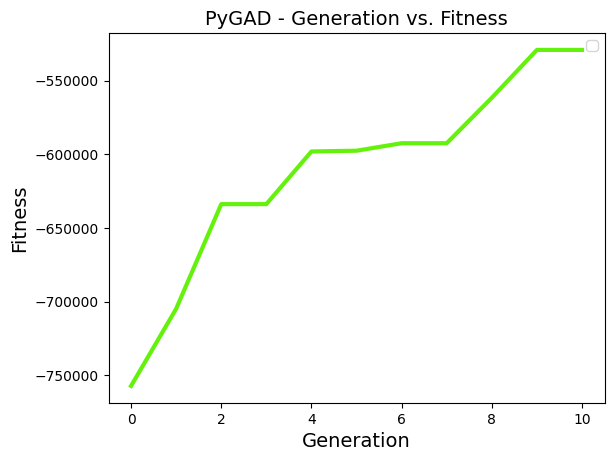

1354
1354
Iteration
0.08903092809960515
final std:
0.08866501660048304


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.01613233537786606
Iteration
0.013982963236997058
final std:
0.01363559483102668
Iteration
0.015600368265244382
Iteration
0.013615086502117608
final std:
0.013423740062389009
Iteration
0.015600368265244382
Iteration
0.013615086502117608
final std:
0.013423740062389009
Iteration
0.11362633526820634
final std:
0.11279622875270422
Iteration
0.015600368265244382
Iteration
0.013615086502117608
final std:
0.013423740062389009
Iteration
0.09077761368732903
final std:
0.08972795645388429


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


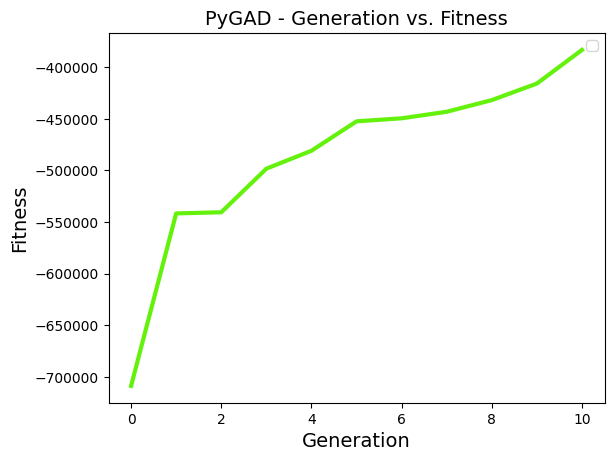

1375
1375
Iteration
0.08119964441794687
final std:
0.08042061961386648


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.022504614909017062
Iteration
0.021072393679970037
final std:
0.02076175579601137
Iteration
0.015348094735327724
Iteration
0.013495340443086855
final std:
0.013306659248852945
Iteration
0.015348094735327724
Iteration
0.013495340443086855
final std:
0.013306659248852945
Iteration
0.1128610909242103
final std:
0.11185792636527093
Iteration
0.015348094735327724
Iteration
0.013495340443086855
final std:
0.013306659248852945
Iteration
0.09364889412314882
final std:
0.09257794457000858


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


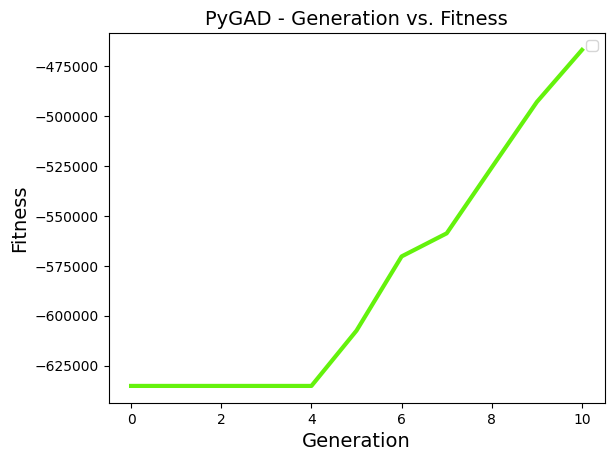

1358
1358
Iteration
0.09546095047606579
final std:
0.09469569342369427


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.01383971883311344
Iteration
0.012605569314189437
final std:
0.012353912197880268
Iteration
0.012943495947213762
Iteration
0.0106751070656028
final std:
0.010683582807793792
Iteration
0.012943495947213762
Iteration
0.0106751070656028
final std:
0.010683582807793792
Iteration
0.11516647344972714
final std:
0.1146793418392626
Iteration
0.012943495947213762
Iteration
0.0106751070656028
final std:
0.010683582807793792
Iteration
0.062079110915105935
final std:
0.0611348098363902


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


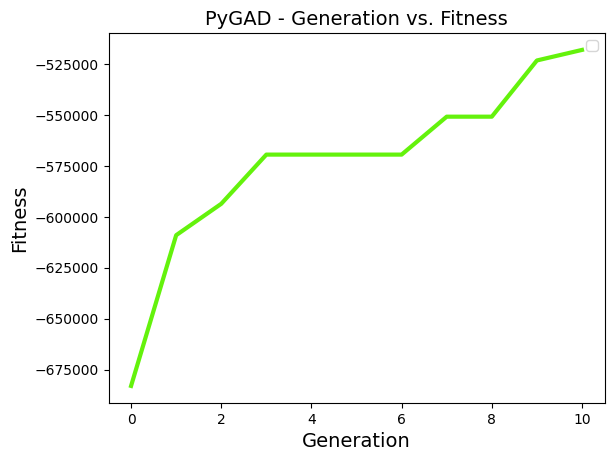

1352
1352
Iteration
0.08044313574382436
final std:
0.07993948854331673


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.013562235240375435
Iteration
0.012442794971900982
final std:
0.01207741257175721
Iteration
0.01541412512722086
Iteration
0.014559882843020587
final std:
0.014498458887060152
Iteration
0.01541412512722086
Iteration
0.014559882843020587
final std:
0.014498458887060152
Iteration
0.11329904804361055
final std:
0.1128352208103044
Iteration
0.01541412512722086
Iteration
0.014559882843020587
final std:
0.014498458887060152
Iteration
0.07414487525921254
final std:
0.07341026129386119


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


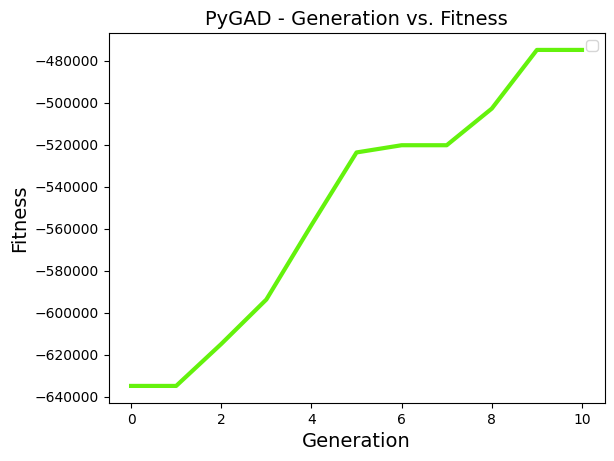

1352
1352
Iteration
0.0675596851634724
final std:
0.06697377259996101


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.01376456598264264
Iteration
0.01288661715775047
final std:
0.01247653688369738
Iteration
0.015511704002529113
Iteration
0.014519997993301158
final std:
0.0144858320011332
Iteration
0.015511704002529113
Iteration
0.014519997993301158
final std:
0.0144858320011332
Iteration
0.11468667781096652
final std:
0.11424697517680431
Iteration
0.015511704002529113
Iteration
0.014519997993301158
final std:
0.0144858320011332
Iteration
0.07638755601985198
final std:
0.07598547857153293


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


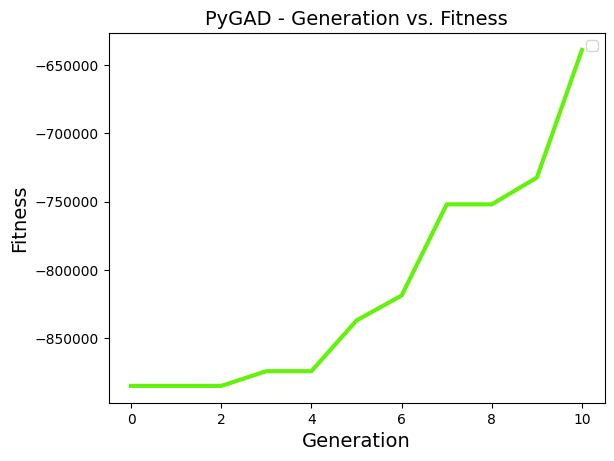

1350
1350
Iteration
0.08586798302162642
final std:
0.0852364026934598


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.014425423501882379
Iteration
0.01349549943689216
final std:
0.013108837715458507
Iteration
0.011977266455745025
Iteration
0.010379341570549105
final std:
0.010230202932804536
Iteration
0.011977266455745025
Iteration
0.010379341570549105
final std:
0.010230202932804536
Iteration
0.11432092566350296
final std:
0.11376048277022743
Iteration
0.011977266455745025
Iteration
0.010379341570549105
final std:
0.010230202932804536
Iteration
0.08926991071869203
final std:
0.08874303150974176


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


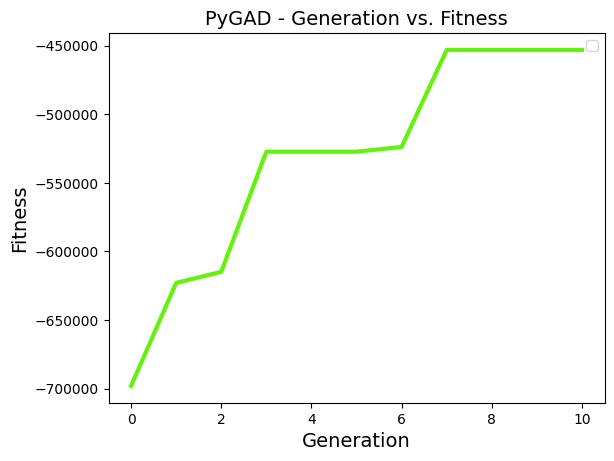

1354
1354
Iteration
0.07766601909668075
final std:
0.07725960185119593


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.014427443926118147
Iteration
0.013516032656072067
final std:
0.013126403932534421
Iteration
0.01177599014612673
Iteration
0.010138485536781424
final std:
0.009994846218137147
Iteration
0.01177599014612673
Iteration
0.010138485536781424
final std:
0.009994846218137147
Iteration
0.11430170208743858
final std:
0.11375546215488205
Iteration
0.01177599014612673
Iteration
0.010138485536781424
final std:
0.009994846218137147
Iteration
0.07118969064923868
final std:
0.0702681341592347


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


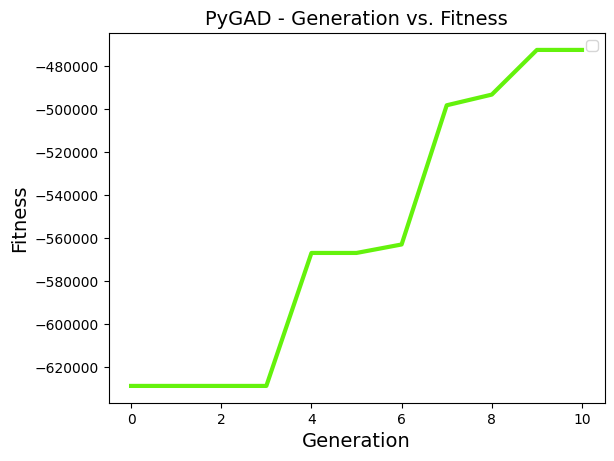

1354
1354
Iteration
0.07416164014159514
final std:
0.0736738945405564


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.016115814143857644
Iteration
0.01387694151862403
final std:
0.013503310985150743
Iteration
0.014880637998336435
Iteration
0.01333201345266111
final std:
0.013114650613205055
Iteration
0.014880637998336435
Iteration
0.01333201345266111
final std:
0.013114650613205055
Iteration
0.11451432503820251
final std:
0.11349074031115422
Iteration
0.014880637998336435
Iteration
0.01333201345266111
final std:
0.013114650613205055
Iteration
0.07885404799830235
final std:
0.07796685855173459


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


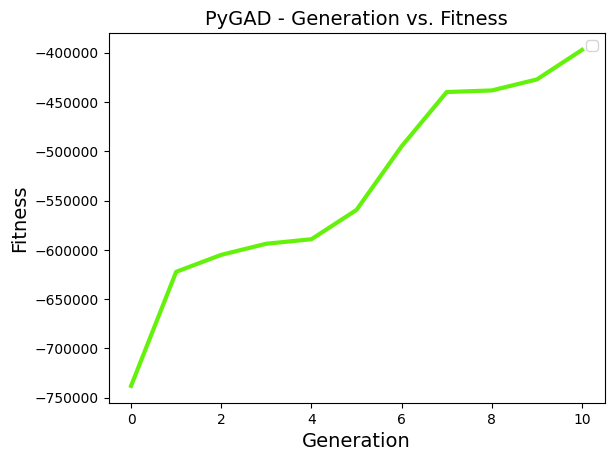

1375
1375
Iteration
0.09203089256659415
final std:
0.09127521738951301


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.013733960190252466
Iteration
0.012650000655535946
final std:
0.012167786868922675
Iteration
0.0128778398039328
Iteration
0.011817628229269227
final std:
0.011767121265860303
Iteration
0.0128778398039328
Iteration
0.011817628229269227
final std:
0.011767121265860303
Iteration
0.11473291167580549
final std:
0.1143081511881986
Iteration
0.0128778398039328
Iteration
0.011817628229269227
final std:
0.011767121265860303
Iteration
0.06826632967580576
final std:
0.0675740927889135


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


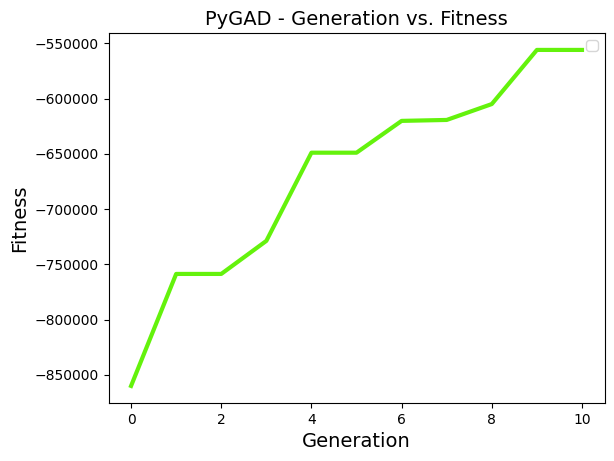

1349
1349
Iteration
0.08213002005291206
final std:
0.08138799720235197


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.012947304286073782
Iteration
0.011535494236464622
final std:
0.011194924591471497
Iteration
0.01025559801543006
Iteration
0.008201172570221673
final std:
0.008083253656002976
Iteration
0.01025559801543006
Iteration
0.008201172570221673
final std:
0.008083253656002976
Iteration
0.11975869390628417
final std:
0.11927831985004415
Iteration
0.01025559801543006
Iteration
0.008201172570221673
final std:
0.008083253656002976
Iteration
0.07852292451990386
final std:
0.07793606907381588


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


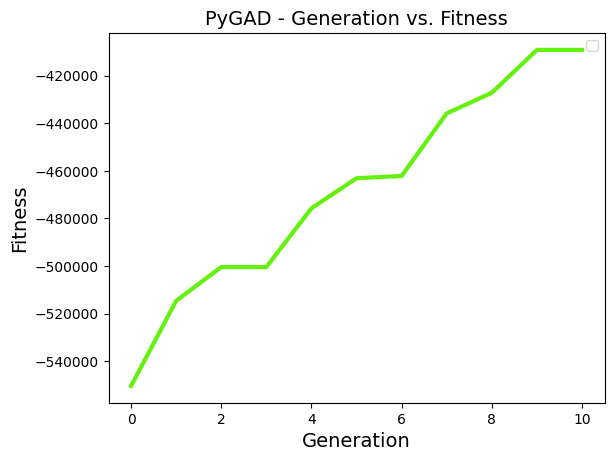

1349
1349
Iteration
0.07053814599172484
final std:
0.06972135056585928


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.012928142104106534
Iteration
0.011331758338371863
final std:
0.011104631095215525
Iteration
0.010087502632839893
Iteration
0.008053525599050157
final std:
0.007987745490430447
Iteration
0.010087502632839893
Iteration
0.008053525599050157
final std:
0.007987745490430447
Iteration
0.1156475068181202
final std:
0.11511080873949588
Iteration
0.010087502632839893
Iteration
0.008053525599050157
final std:
0.007987745490430447
Iteration
0.0784114965892709
final std:
0.07728795112627057


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


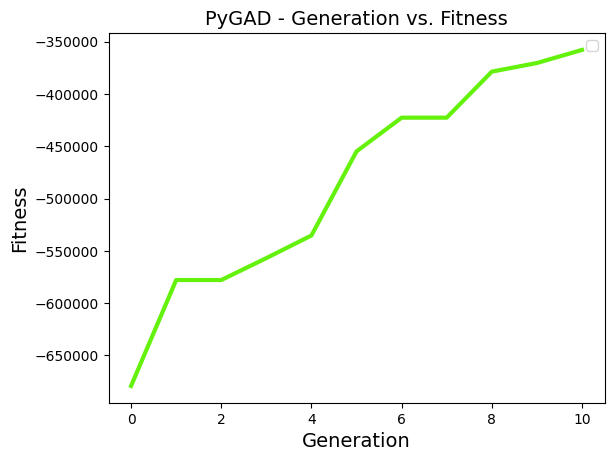

1350
1350
Iteration
0.07418345373036904
final std:
0.073762191884767


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.013327739929015122
Iteration
0.011994404845524612
final std:
0.01174003600959951
Iteration
0.011707723248015499
Iteration
0.009880714450982517
final std:
0.009763371275866737
Iteration
0.011707723248015499
Iteration
0.009880714450982517
final std:
0.009763371275866737
Iteration
0.11389703934447122
final std:
0.11339173259498268
Iteration
0.011707723248015499
Iteration
0.009880714450982517
final std:
0.009763371275866737
Iteration
0.07319860050978393
final std:
0.07260100884322582


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


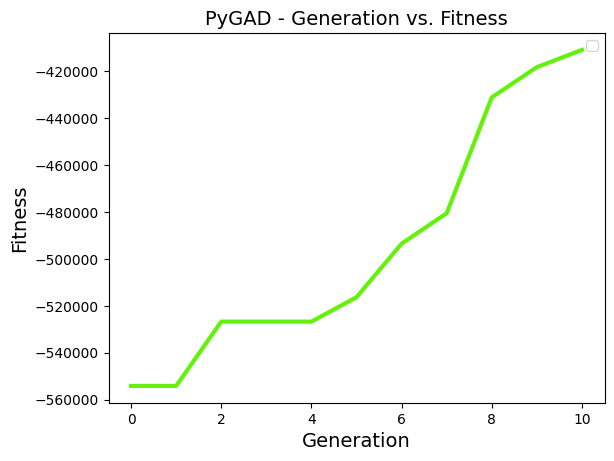

1352
1352
Iteration
0.07683378285299569
final std:
0.07543300761931954


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.012670892664573398
Iteration
0.011133978574126176
final std:
0.010848885947553184
Iteration
0.009131613996450676
Iteration
0.007417177927797778
final std:
0.0073134945452480475
Iteration
0.009131613996450676
Iteration
0.007417177927797778
final std:
0.0073134945452480475
Iteration
0.11493508942922359
final std:
0.11434954093821001
Iteration
0.009131613996450676
Iteration
0.007417177927797778
final std:
0.0073134945452480475
Iteration
0.07428478316693006
final std:
0.07367644412328159


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347
1347


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


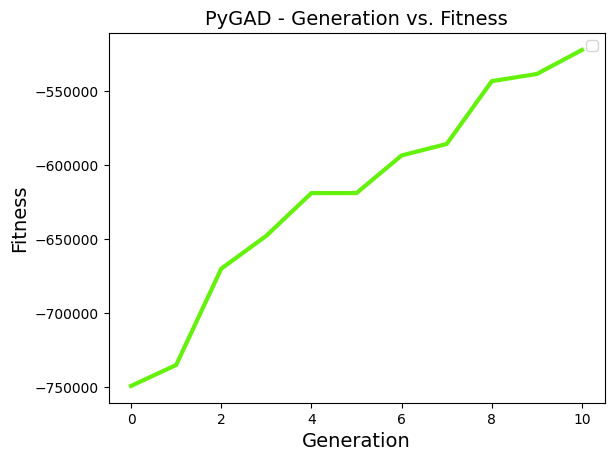

1347
1347
Iteration
0.07236663449331697
final std:
0.07174613956655193


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.015961991377445733
Iteration
0.013867225065402153
final std:
0.013533396534524447
Iteration
0.01859168278925866
Iteration
0.016587699738445375
final std:
0.016295460531864887
Iteration
0.01859168278925866
Iteration
0.016587699738445375
final std:
0.016295460531864887
Iteration
0.11577873127086184
final std:
0.11469777500337351
Iteration
0.01859168278925866
Iteration
0.016587699738445375
final std:
0.016295460531864887
Iteration
0.09218044865618082
final std:
0.09098329416833202


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


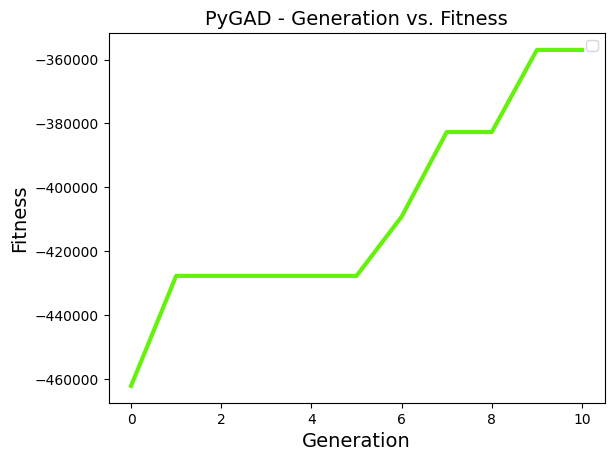

1375
1375
Iteration
0.10453295892674092
final std:
0.10401739560899445


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.013404313492079479
Iteration
0.012098778800344991
final std:
0.011669368592301924
Iteration
0.010179745426374547
Iteration
0.008196884734577626
final std:
0.008047866256978745
Iteration
0.010179745426374547
Iteration
0.008196884734577626
final std:
0.008047866256978745
Iteration
0.11311325825698573
final std:
0.11253653146578313
Iteration
0.010179745426374547
Iteration
0.008196884734577626
final std:
0.008047866256978745
Iteration
0.06812352164120422
final std:
0.06715128367461631


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


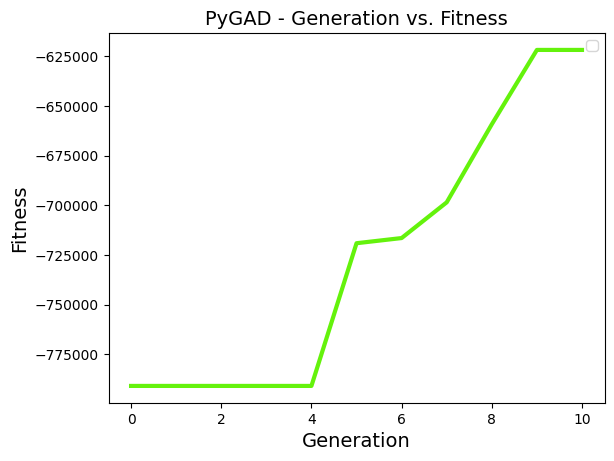

1349
1349
Iteration
0.07694452113828269
final std:
0.0761518529931844


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.012971427227295461
Iteration
0.011606895417134564
final std:
0.011200011178014946
Iteration
0.011031319965196037
Iteration
0.009184147549858804
final std:
0.009084003103170795
Iteration
0.011031319965196037
Iteration
0.009184147549858804
final std:
0.009084003103170795
Iteration
0.11563524392888949
final std:
0.11505872319247071
Iteration
0.011031319965196037
Iteration
0.009184147549858804
final std:
0.009084003103170795
Iteration
0.08801810493070826
final std:
0.08661693245341552


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


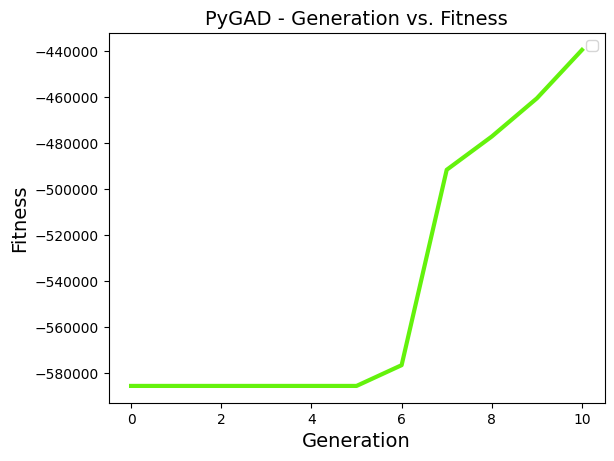

1349
1349
Iteration
0.06311657113247163
final std:
0.06244920515393009


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.012740413320858898
Iteration
0.011189891748949523
final std:
0.011009478507641071
Iteration
0.013098245114989289
Iteration
0.01135423532153277
final std:
0.011445142122718289
Iteration
0.013098245114989289
Iteration
0.01135423532153277
final std:
0.011445142122718289
Iteration
0.11493639358963613
final std:
0.11436688089321365
Iteration
0.013098245114989289
Iteration
0.01135423532153277
final std:
0.011445142122718289
Iteration
0.0749791451508952
final std:
0.07410334432283594


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


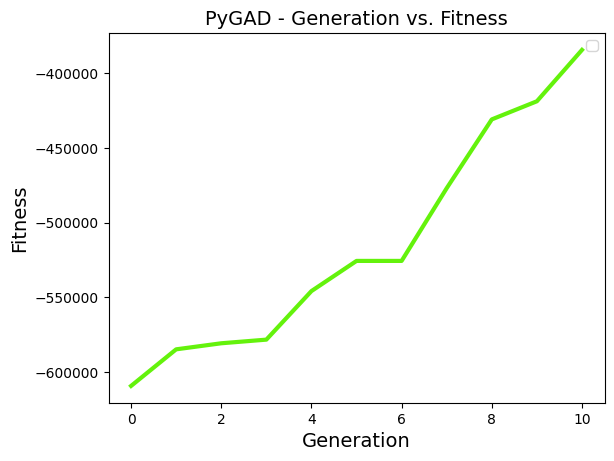

1348
1348
Iteration
0.06897778894690468
final std:
0.06843918734500516


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.015967125392248347
Iteration
0.014004852884491922
final std:
0.013702819982766604
Iteration
0.014108649406466243
Iteration
0.01248512418698266
final std:
0.012278654250279467
Iteration
0.014108649406466243
Iteration
0.01248512418698266
final std:
0.012278654250279467
Iteration
0.1165753835854087
final std:
0.11555296260109404
Iteration
0.014108649406466243
Iteration
0.01248512418698266
final std:
0.012278654250279467
Iteration
0.09804894058020613
final std:
0.09722720136136308


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364
1364


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


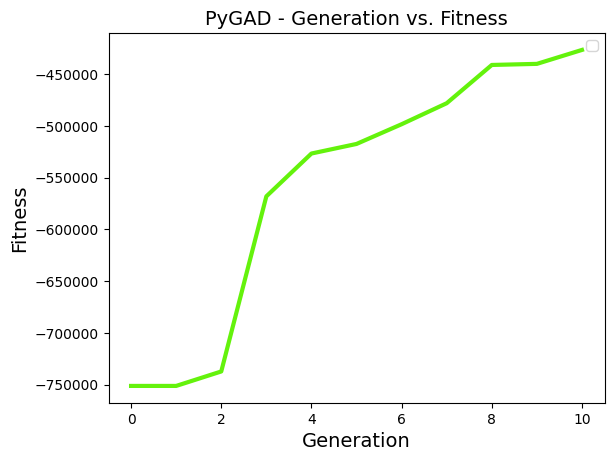

1364
1364
Iteration
0.0993756398534865
final std:
0.09842213478109514


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.0160148733713602
Iteration
0.013791446620171512
final std:
0.013409961965340236
Iteration
0.01473103480467312
Iteration
0.01353103558116624
final std:
0.013368493071968014
Iteration
0.01473103480467312
Iteration
0.01353103558116624
final std:
0.013368493071968014
Iteration
0.11542161488018757
final std:
0.11448883423874691
Iteration
0.01473103480467312
Iteration
0.01353103558116624
final std:
0.013368493071968014
Iteration
0.07876696318727469
final std:
0.07772470146929353


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367
1367


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


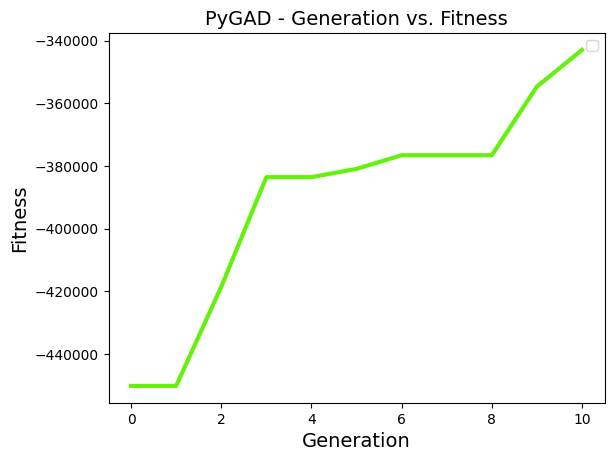

1367
1367
Iteration
0.08067963201300765
final std:
0.0800351512643152


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.013377011630471322
Iteration
0.012165154738770311
final std:
0.011634005483690408
Iteration
0.01335906859837439
Iteration
0.011457750289099289
final std:
0.011363001446007642
Iteration
0.01335906859837439
Iteration
0.011457750289099289
final std:
0.011363001446007642
Iteration
0.11324693334164194
final std:
0.11266347228340845
Iteration
0.01335906859837439
Iteration
0.011457750289099289
final std:
0.011363001446007642
Iteration
0.06673030615229787
final std:
0.06619205383613223


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


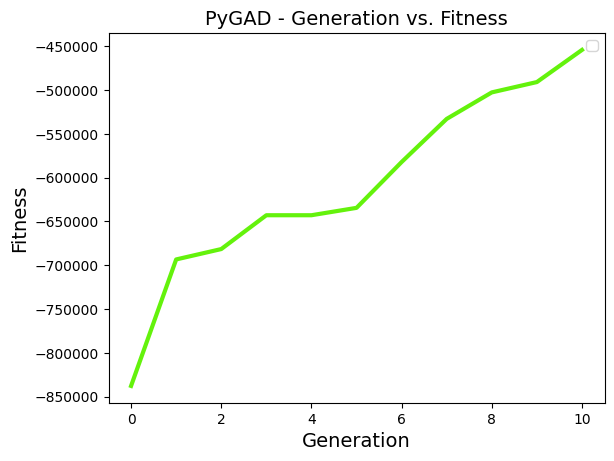

1348
1348
Iteration
0.06953036275779664
final std:
0.06871414867333116


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.013490521877188275
Iteration
0.01237883589252912
final std:
0.011846404190036353
Iteration
0.008810497873444798
Iteration
0.007328542322452798
final std:
0.007196176685876719
Iteration
0.008810497873444798
Iteration
0.007328542322452798
final std:
0.007196176685876719
Iteration
0.11490504545829137
final std:
0.11445503242707643
Iteration
0.008810497873444798
Iteration
0.007328542322452798
final std:
0.007196176685876719
Iteration
0.07356591499988453
final std:
0.07297781373611756


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


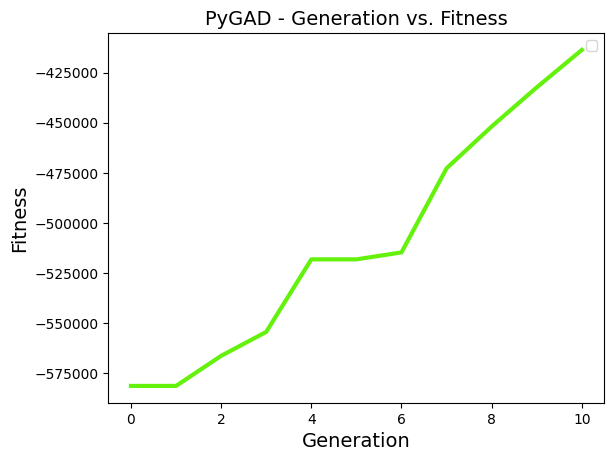

1354
1354
Iteration
0.07934708516195049
final std:
0.07889625535001042


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.013689101718590379
Iteration
0.012318990159518567
final std:
0.012288258704093048
Iteration
0.012865727831205475
Iteration
0.011320806870377207
final std:
0.011118940144732165
Iteration
0.012865727831205475
Iteration
0.011320806870377207
final std:
0.011118940144732165
Iteration
0.11552354627556007
final std:
0.11496951313747829
Iteration
0.012865727831205475
Iteration
0.011320806870377207
final std:
0.011118940144732165
Iteration
0.076369119243332
final std:
0.07540692032721989


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


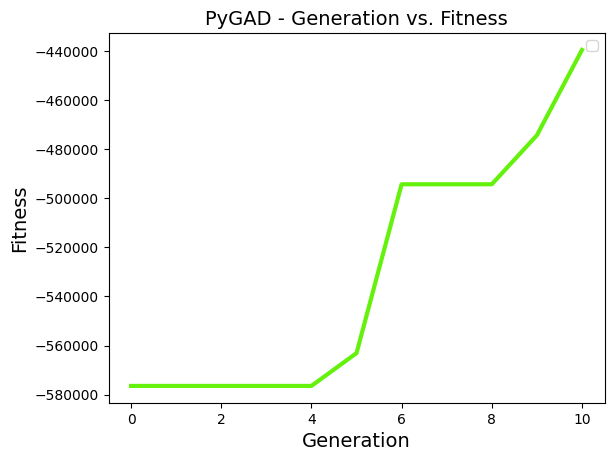

1350
1350
Iteration
0.07964997788219051
final std:
0.0790863294142938


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.016018087179945274
Iteration
0.0139862291138062
final std:
0.013704729822340701
Iteration
0.015308283376410077
Iteration
0.01343081132556324
final std:
0.013264242417467159
Iteration
0.015308283376410077
Iteration
0.01343081132556324
final std:
0.013264242417467159
Iteration
0.11482752250225074
final std:
0.11382062480792014
Iteration
0.015308283376410077
Iteration
0.01343081132556324
final std:
0.013264242417467159
Iteration
0.08630159970854788
final std:
0.08526395930092788


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


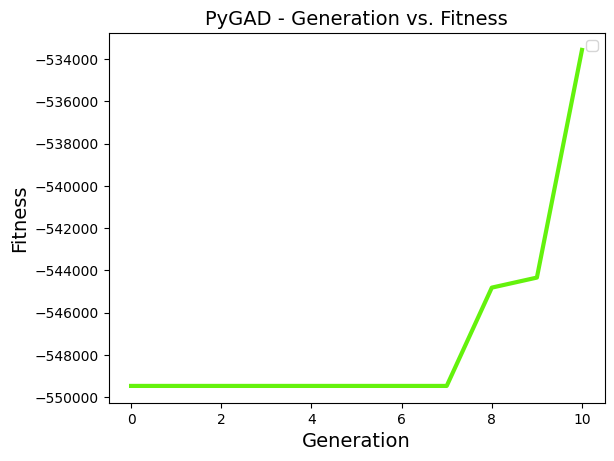

1358
1358
Iteration
0.10715548550522917
final std:
0.10605295440469747


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.013866049631616594
Iteration
0.012793471811732201
final std:
0.012193731216263383
Iteration
0.01696132877051775
Iteration
0.01572294688932786
final std:
0.015681581617718234
Iteration
0.01696132877051775
Iteration
0.01572294688932786
final std:
0.015681581617718234
Iteration
0.11451225639506014
final std:
0.11403679717350301
Iteration
0.01696132877051775
Iteration
0.01572294688932786
final std:
0.015681581617718234
Iteration
0.07337920528875631
final std:
0.07232747076861787


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


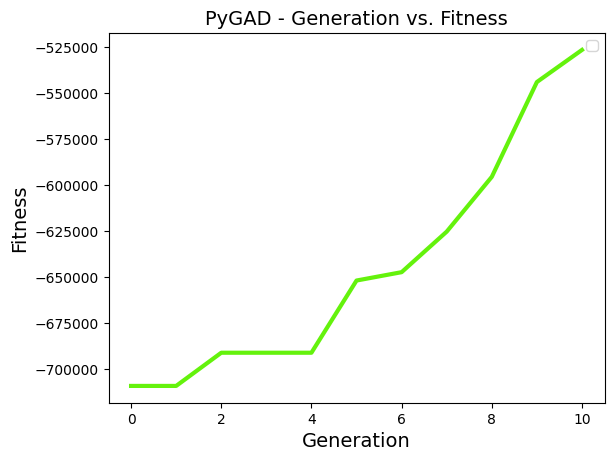

1354
1354
Iteration
0.07838144162247761
final std:
0.07762146555143294


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.01601582144068975
Iteration
0.01401741128205491
final std:
0.013765882759921274
Iteration
0.016941844871766795
Iteration
0.015042807946636308
final std:
0.014950439246041447
Iteration
0.016941844871766795
Iteration
0.015042807946636308
final std:
0.014950439246041447
Iteration
0.11465271690220355
final std:
0.1136882983144261
Iteration
0.016941844871766795
Iteration
0.015042807946636308
final std:
0.014950439246041447
Iteration
0.09050035647236342
final std:
0.08958660666333963


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358
1358


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


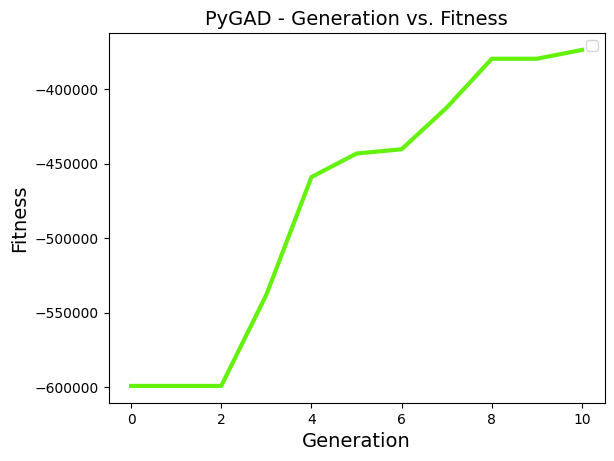

1358
1358
Iteration
0.07821601229309394
final std:
0.07729826170660936


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.013955426204898255
Iteration
0.012964815598856854
final std:
0.012567797348377539
Iteration
0.009732476080880723
Iteration
0.008186250623696913
final std:
0.007981433352733217
Iteration
0.009732476080880723
Iteration
0.008186250623696913
final std:
0.007981433352733217
Iteration
0.1148445872692312
final std:
0.11428704994707652
Iteration
0.009732476080880723
Iteration
0.008186250623696913
final std:
0.007981433352733217
Iteration
0.07293687980909479
final std:
0.07223147134666447


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


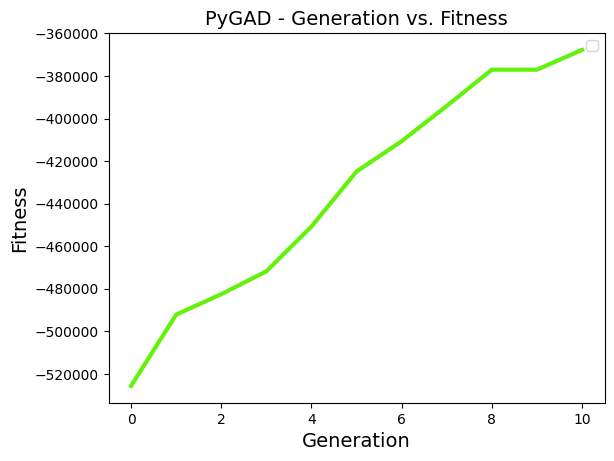

1354
1354
Iteration
0.07288285392804292
final std:
0.072322373187184


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.01598459583179085
Iteration
0.014032469549060313
final std:
0.013726313606466388
Iteration
0.01431256660089787
Iteration
0.012694530272276811
final std:
0.01248565025722861
Iteration
0.01431256660089787
Iteration
0.012694530272276811
final std:
0.01248565025722861
Iteration
0.11630148087061948
final std:
0.11528965516881057
Iteration
0.01431256660089787
Iteration
0.012694530272276811
final std:
0.01248565025722861
Iteration
0.09168050798545084
final std:
0.09077397799769087


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363
1363


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


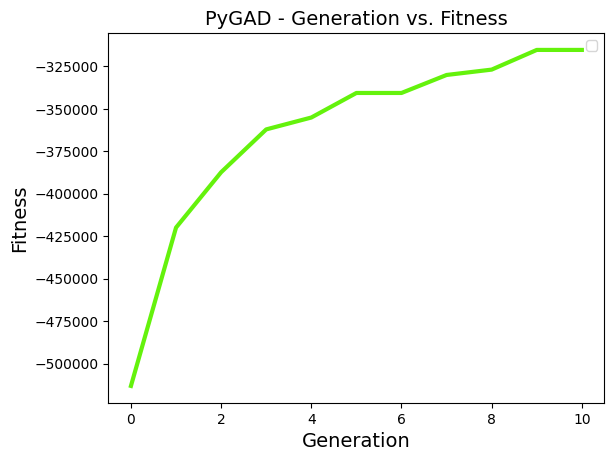

1363
1363
Iteration
0.08587041565327422
final std:
0.08539294795180452


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.01618304578120983
Iteration
0.01422134519314279
final std:
0.013943357617087523
Iteration
0.01665232786120629
Iteration
0.01532120961628737
final std:
0.015112421105882635
Iteration
0.01665232786120629
Iteration
0.01532120961628737
final std:
0.015112421105882635
Iteration
0.11643528780966299
final std:
0.11547490515942929
Iteration
0.01665232786120629
Iteration
0.01532120961628737
final std:
0.015112421105882635
Iteration
0.09740637047298423
final std:
0.09681080157158338


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


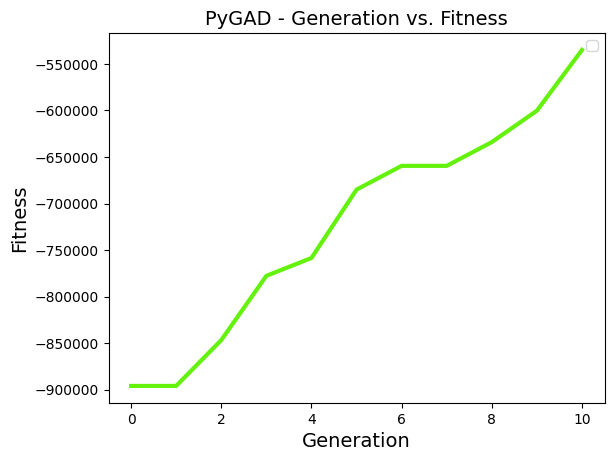

1375
1375
Iteration
0.0973132353593638
final std:
0.09621210589195188


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.016282026626187527
Iteration
0.01465309926460728
final std:
0.014450193411567318
Iteration
0.017128283905131103
Iteration
0.015195968146241906
final std:
0.014913030078873036
Iteration
0.017128283905131103
Iteration
0.015195968146241906
final std:
0.014913030078873036
Iteration
0.12170661915821107
final std:
0.12075044344136766
Iteration
0.017128283905131103
Iteration
0.015195968146241906
final std:
0.014913030078873036
Iteration
0.09436135164212564
final std:
0.09324234642115858


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


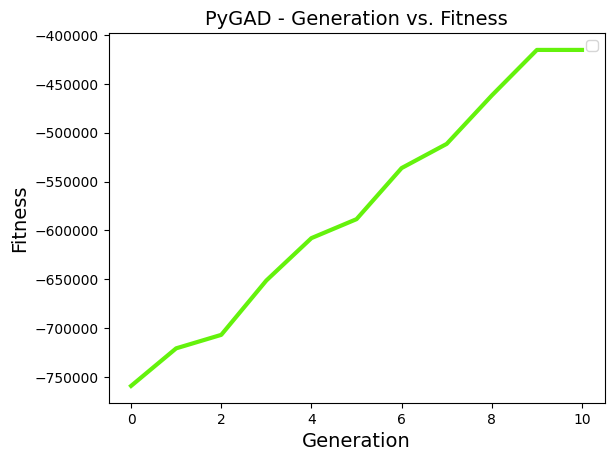

1377
1377
Iteration
0.08878099498683852
final std:
0.08773279369678295


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.013589788612042302
Iteration
0.012374667364274705
final std:
0.011934386320302926
Iteration
0.009700028287107152
Iteration
0.007868936115430072
final std:
0.00774229652860313
Iteration
0.009700028287107152
Iteration
0.007868936115430072
final std:
0.00774229652860313
Iteration
0.11484135903004021
final std:
0.11437973283845196
Iteration
0.009700028287107152
Iteration
0.007868936115430072
final std:
0.00774229652860313
Iteration
0.08755437858484555
final std:
0.08669962364396497


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


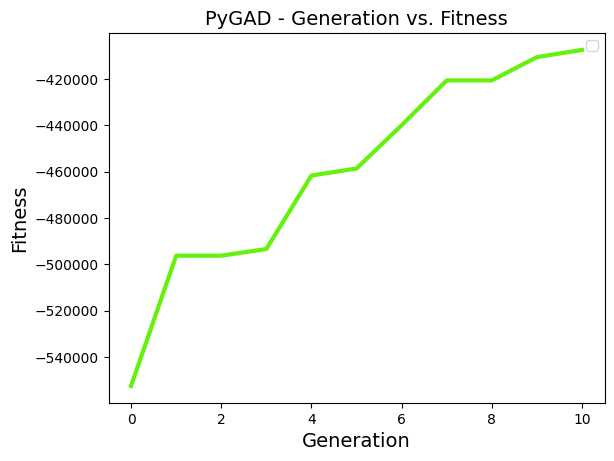

1354
1354
Iteration
0.0676553586862982
final std:
0.06662514318260093


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.014036544282439344
Iteration
0.013086692026621586
final std:
0.012689747943390202
Iteration
0.011798600779706864
Iteration
0.010135593282072145
final std:
0.010001871351730965
Iteration
0.011798600779706864
Iteration
0.010135593282072145
final std:
0.010001871351730965
Iteration
0.1143864660527371
final std:
0.11383630065484081
Iteration
0.011798600779706864
Iteration
0.010135593282072145
final std:
0.010001871351730965
Iteration
0.07992841776926886
final std:
0.07906553830925768


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


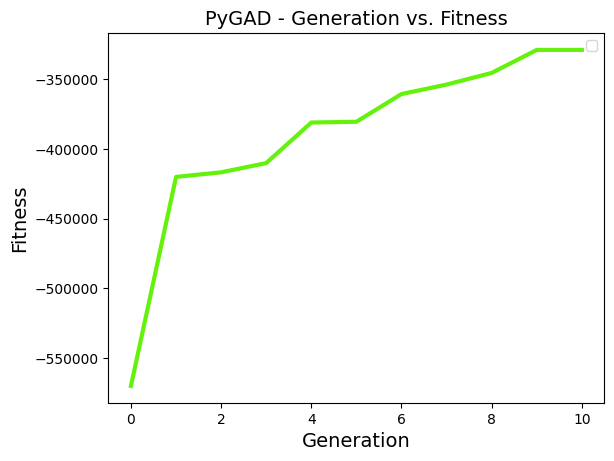

1354
1354
Iteration
0.07817362369619486
final std:
0.07780931329282283


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.020295595578045403
Iteration
0.018808232860328327
final std:
0.018621254211829422
Iteration
0.016219050810144086
Iteration
0.014082005061772379
final std:
0.013824246563413753
Iteration
0.016219050810144086
Iteration
0.014082005061772379
final std:
0.013824246563413753
Iteration
0.11207279259684783
final std:
0.11103814269056991
Iteration
0.016219050810144086
Iteration
0.014082005061772379
final std:
0.013824246563413753
Iteration
0.08629016141473426
final std:
0.08504040999878484


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352
1352


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


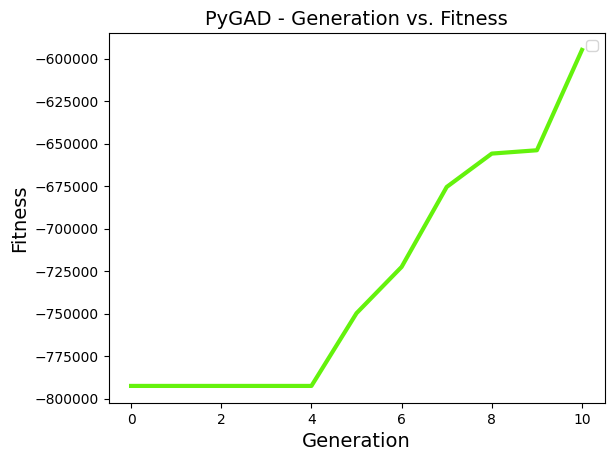

1352
1352
Iteration
0.11357275155904253
final std:
0.11286011055719841


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.01580881245878871
Iteration
0.013908096099079949
final std:
0.013592961068594048
Iteration
0.01583324083682056
Iteration
0.013869822641448565
final std:
0.013734658041404264
Iteration
0.01583324083682056
Iteration
0.013869822641448565
final std:
0.013734658041404264
Iteration
0.11242808915944243
final std:
0.11135873476722749
Iteration
0.01583324083682056
Iteration
0.013869822641448565
final std:
0.013734658041404264
Iteration
0.0778179694613102
final std:
0.07630932497337514


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


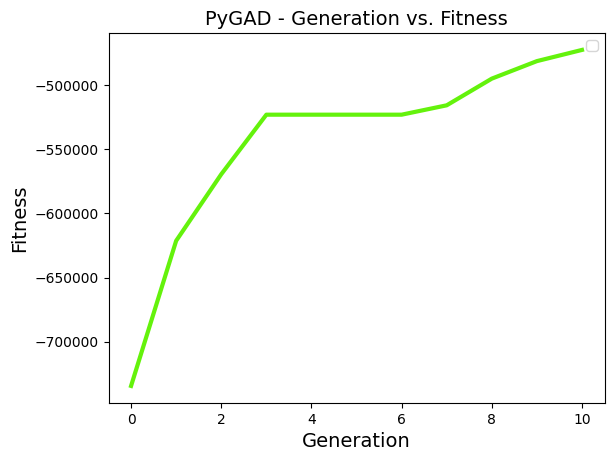

1353
1353
Iteration
0.08815193341005385
final std:
0.08731329239727013


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.013231706821708456
Iteration
0.012010056036333368
final std:
0.011568274150975342
Iteration
0.010099902637860994
Iteration
0.0081770428928019
final std:
0.008066621556802692
Iteration
0.010099902637860994
Iteration
0.0081770428928019
final std:
0.008066621556802692
Iteration
0.11463221362708324
final std:
0.11409646794705638
Iteration
0.010099902637860994
Iteration
0.0081770428928019
final std:
0.008066621556802692
Iteration
0.07597446197681866
final std:
0.07547147651638979


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


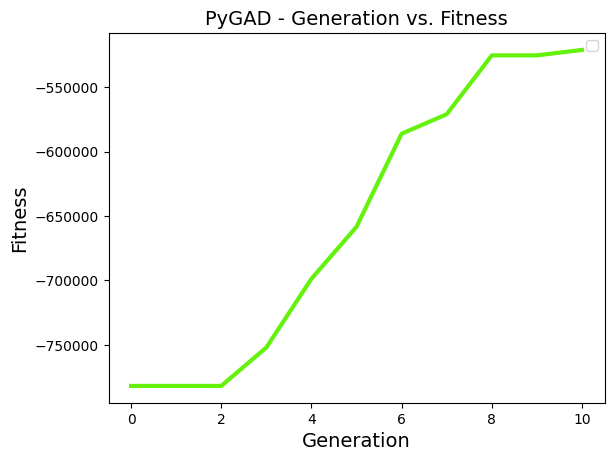

1351
1351
Iteration
0.07289199189704024
final std:
0.07190937506841978


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.013541086913680814
Iteration
0.012345854718394058
final std:
0.011894705623092333
Iteration
0.010763058634674524
Iteration
0.008731646675825155
final std:
0.00856565606688304
Iteration
0.010763058634674524
Iteration
0.008731646675825155
final std:
0.00856565606688304
Iteration
0.11363370830145986
final std:
0.11312840755417575
Iteration
0.010763058634674524
Iteration
0.008731646675825155
final std:
0.00856565606688304
Iteration
0.085424233176866
final std:
0.08497566035721572


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350
1350


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


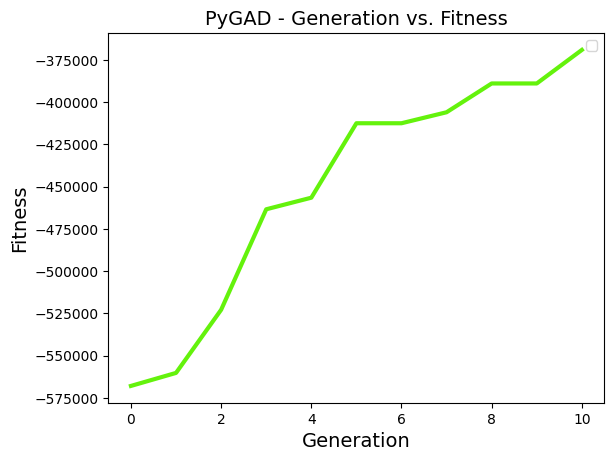

1350
1350
Iteration
0.06391844054213648
final std:
0.06361619189649603


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.013303794328941885
Iteration
0.011943185665451111
final std:
0.011706980743913875
Iteration
0.011531381424482156
Iteration
0.009794262489495872
final std:
0.009679928149649474
Iteration
0.011531381424482156
Iteration
0.009794262489495872
final std:
0.009679928149649474
Iteration
0.11335934578270576
final std:
0.11279423745522064
Iteration
0.011531381424482156
Iteration
0.009794262489495872
final std:
0.009679928149649474
Iteration
0.0709140288092761
final std:
0.07013582392738592


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351
1351


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


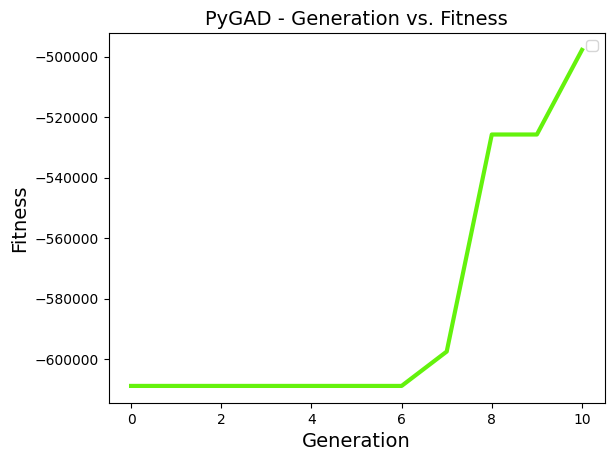

1351
1351
Iteration
0.08077698223525083
final std:
0.08026998511097841


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.01429844779195501
Iteration
0.013311554661685715
final std:
0.01298248861436722
Iteration
0.012537598081967367
Iteration
0.01128519703621751
final std:
0.011173500088031514
Iteration
0.012537598081967367
Iteration
0.01128519703621751
final std:
0.011173500088031514
Iteration
0.11495205416480873
final std:
0.1144181649274693
Iteration
0.012537598081967367
Iteration
0.01128519703621751
final std:
0.011173500088031514
Iteration
0.0783174086110295
final std:
0.07774210634391092


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


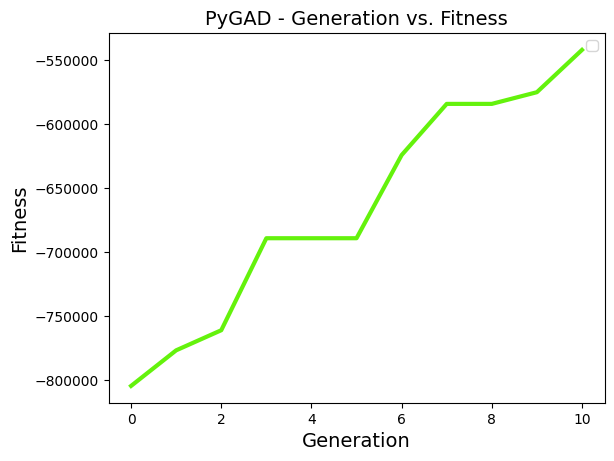

1354
1354
Iteration
0.07119320174451153
final std:
0.07021562195858533


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.01287404677715856
Iteration
0.011485516609849285
final std:
0.011123485373640411
Iteration
0.010000462991700173
Iteration
0.007847271248968673
final std:
0.007708229788134211
Iteration
0.010000462991700173
Iteration
0.007847271248968673
final std:
0.007708229788134211
Iteration
0.1161565305473937
final std:
0.11565351324510584
Iteration
0.010000462991700173
Iteration
0.007847271248968673
final std:
0.007708229788134211
Iteration
0.07851138576266015
final std:
0.07787038026601577


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


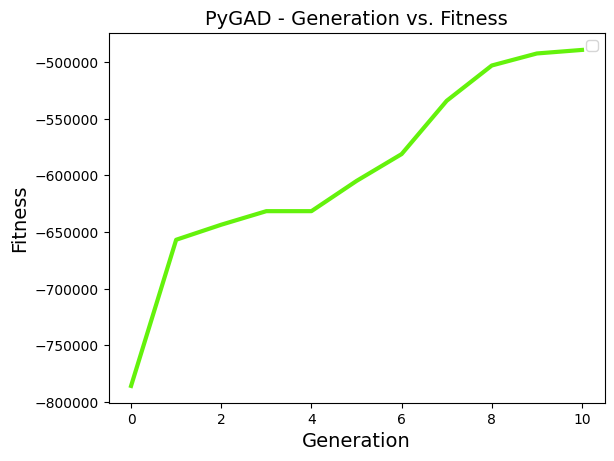

1348
1348
Iteration
0.07374988792720026
final std:
0.0734428890929487


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.015979374941343074
Iteration
0.014099543479691104
final std:
0.013860688524619512
Iteration
0.015505738427368116
Iteration
0.013132739161291714
final std:
0.012910609046882527
Iteration
0.015505738427368116
Iteration
0.013132739161291714
final std:
0.012910609046882527
Iteration
0.11075670159587589
final std:
0.10970265327310776
Iteration
0.015505738427368116
Iteration
0.013132739161291714
final std:
0.012910609046882527
Iteration
0.08339455240786912
final std:
0.08224944316981177


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348
1348


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


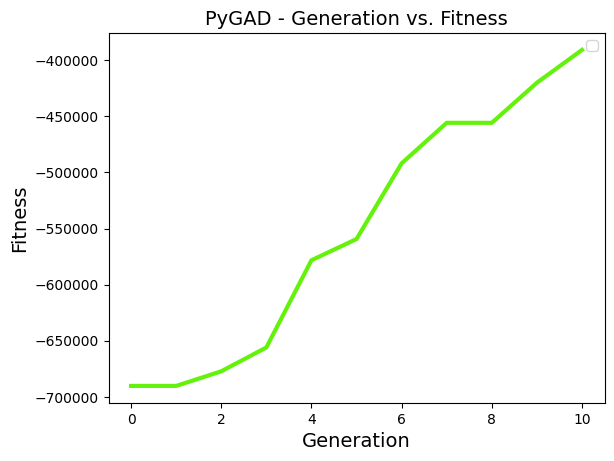

1348
1348
Iteration
0.09506474006482428
final std:
0.09441829873424919


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.015866685447746127
Iteration
0.013748534231149098
final std:
0.013429747603401775
Iteration
0.017282709585660905
Iteration
0.015369295682746947
final std:
0.015152763158814956
Iteration
0.017282709585660905
Iteration
0.015369295682746947
final std:
0.015152763158814956
Iteration
0.1142575011120054
final std:
0.1132475451666023
Iteration
0.017282709585660905
Iteration
0.015369295682746947
final std:
0.015152763158814956
Iteration
0.07627284547089935
final std:
0.07495803783140972


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377
1377


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


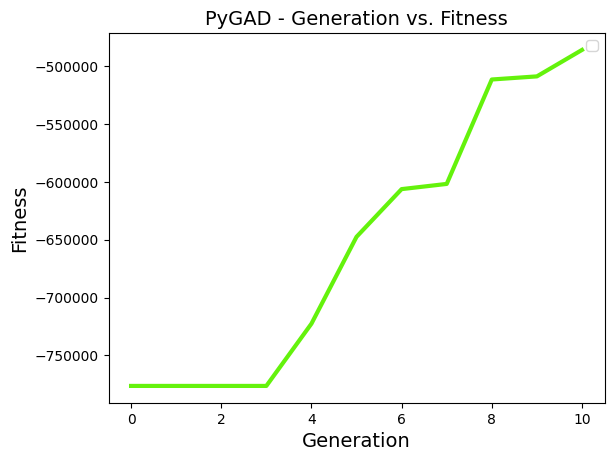

1377
1377
Iteration
0.08728712245857322
final std:
0.0861188686531053


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.013520517339901382
Iteration
0.012017863678572308
final std:
0.011957592739217359
Iteration
0.01321859872590476
Iteration
0.011786957755368978
final std:
0.011810585581290663
Iteration
0.01321859872590476
Iteration
0.011786957755368978
final std:
0.011810585581290663
Iteration
0.11359991832321889
final std:
0.11302492301819368
Iteration
0.01321859872590476
Iteration
0.011786957755368978
final std:
0.011810585581290663
Iteration
0.07018043269520295
final std:
0.06946163036022414


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349
1349


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


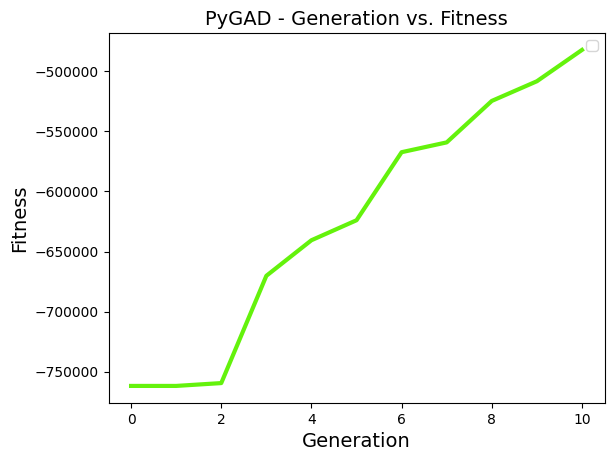

1349
1349
Iteration
0.06982743097624751
final std:
0.0694542564444998


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.01375234129981195
Iteration
0.012669075022946
final std:
0.012130085872390317
Iteration
0.015827808730634014
Iteration
0.01466079971436946
final std:
0.014603974834201177
Iteration
0.015827808730634014
Iteration
0.01466079971436946
final std:
0.014603974834201177
Iteration
0.11591410616740876
final std:
0.11542429793476587
Iteration
0.015827808730634014
Iteration
0.01466079971436946
final std:
0.014603974834201177
Iteration
0.08010145073601126
final std:
0.07956271975041047


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


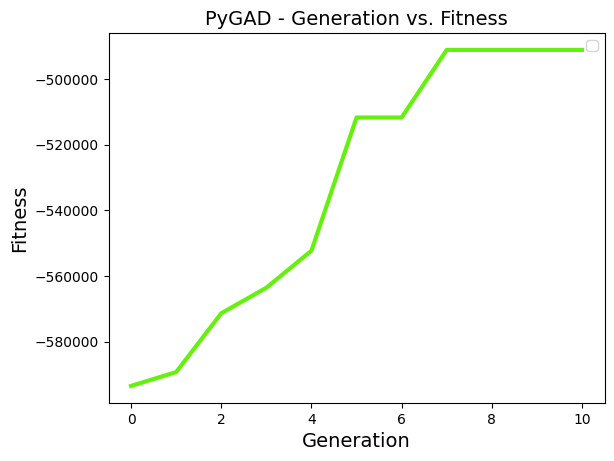

1354
1354
Iteration
0.0751259816307242
final std:
0.07452873670937361


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.01427491581579338
Iteration
0.013411238321714855
final std:
0.012930651230736119
Iteration
0.009592733858114513
Iteration
0.008321057593835477
final std:
0.008189266216684908
Iteration
0.009592733858114513
Iteration
0.008321057593835477
final std:
0.008189266216684908
Iteration
0.1139837032594238
final std:
0.11345822621345342
Iteration
0.009592733858114513
Iteration
0.008321057593835477
final std:
0.008189266216684908
Iteration
0.0758878272173214
final std:
0.07540049990293532


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353
1353


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


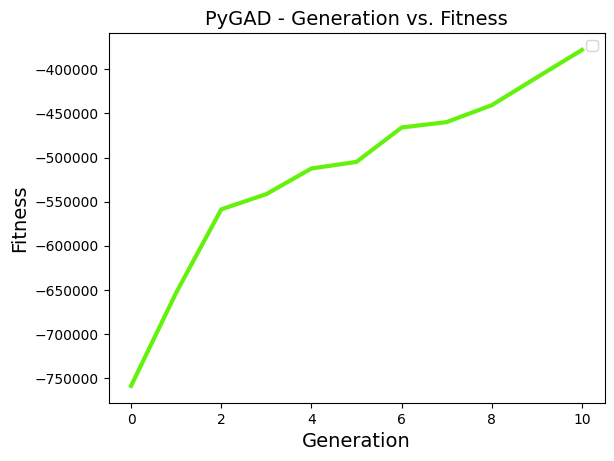

1353
1353
Iteration
0.07384586696870636
final std:
0.0735366668679979


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.013902875862233965
Iteration
0.01275728052934118
final std:
0.012164084666919582
Iteration
0.013077359172199559
Iteration
0.011746270466258797
final std:
0.01167563330405548
Iteration
0.013077359172199559
Iteration
0.011746270466258797
final std:
0.01167563330405548
Iteration
0.11408535509183845
final std:
0.11364559400567402
Iteration
0.013077359172199559
Iteration
0.011746270466258797
final std:
0.01167563330405548
Iteration
0.06575310785864116
final std:
0.06505161056746712


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


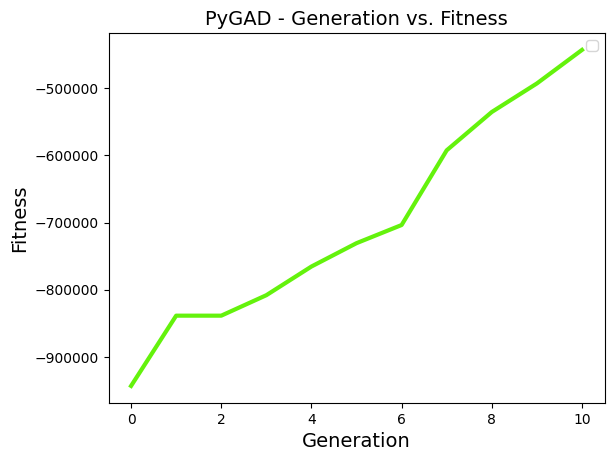

1354
1354
Iteration
0.0669020494568828
final std:
0.06648002354377679


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.01599365165817144
Iteration
0.014016854223958337
final std:
0.013661024459823576
Iteration
0.016708121150380163
Iteration
0.015359565247455855
final std:
0.015197154127311954
Iteration
0.016708121150380163
Iteration
0.015359565247455855
final std:
0.015197154127311954
Iteration
0.11726211195252174
final std:
0.11627324261871891
Iteration
0.016708121150380163
Iteration
0.015359565247455855
final std:
0.015197154127311954
Iteration
0.086989568149984
final std:
0.08588241330557844


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375
1375


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


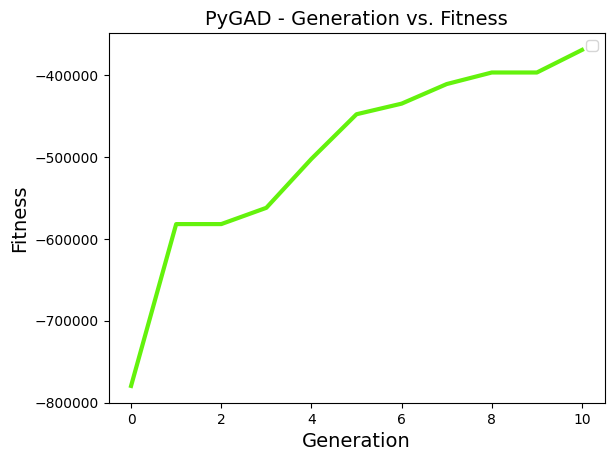

1375
1375
Iteration
0.08711736877010644
final std:
0.0863082028612608


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.016069088829845687
Iteration
0.014136974269453062
final std:
0.013891131794884284
Iteration
0.016203490321112925
Iteration
0.01448391658664473
final std:
0.014325040396375593
Iteration
0.016203490321112925
Iteration
0.01448391658664473
final std:
0.014325040396375593
Iteration
0.11392103549777208
final std:
0.11282795005235295
Iteration
0.016203490321112925
Iteration
0.01448391658664473
final std:
0.014325040396375593
Iteration
0.09613262755046059
final std:
0.09492439917788262


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365
1365


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


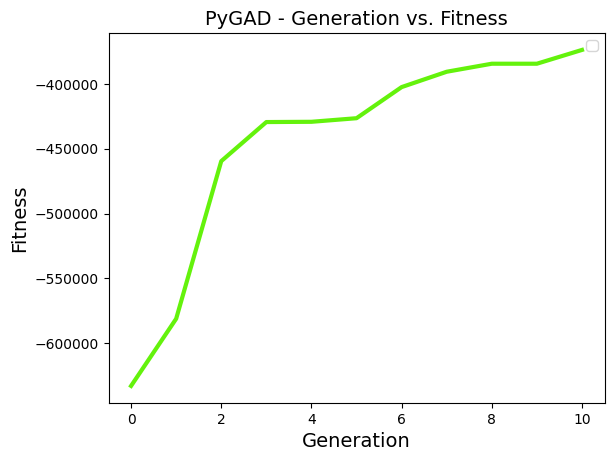

1365
1365
Iteration
0.08942654098562362
final std:
0.08882216505404696


/tmp/ipykernel_6118/3094460721.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validators_data['stakers'] = validators_data['stakers'].str.split(',')
/tmp/ipykernel_6118/3094460721.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  amount_matrix = amount_matrix.iloc[:].applymap(
/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


Iteration
0.01384234353805013
Iteration
0.012706815996541889
final std:
0.012179950915225831
Iteration
0.015984140040520258
Iteration
0.014825695505871176
final std:
0.01477212310861222
Iteration
0.015984140040520258
Iteration
0.014825695505871176
final std:
0.01477212310861222
Iteration
0.1157652814337248
final std:
0.11527515329906818
Iteration
0.015984140040520258
Iteration
0.014825695505871176
final std:
0.01477212310861222
Iteration
0.07716763551409504
final std:
0.07632519814222644


/tmp/ipykernel_6118/1774455113.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355
1355


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


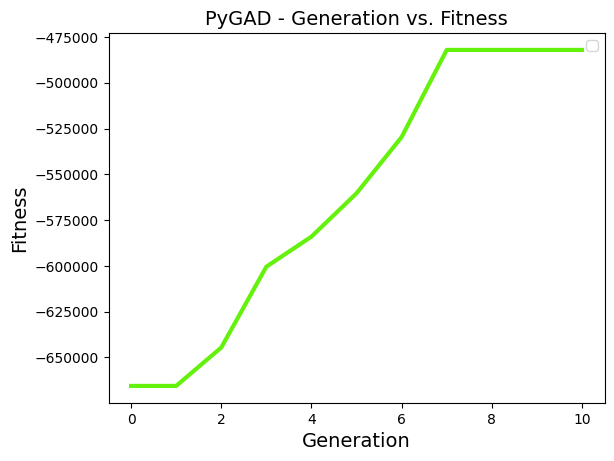

1355
1355
Iteration
0.06714193161501249
final std:
0.06670194342191353


In [106]:
solutions_df, solutions_kpis = get_anaysis_data()

In [107]:
solutions_df

random solution  solve total amount v1  solve total amount v2  \
0      45882.613935           90514.842857           92703.163983   
1      66394.813769           91543.738691           97501.312199   
2      65566.788899           74253.539662           97112.499896   
3      77215.245498           90343.426322           97697.596968   
4      49997.767801           76769.202274          101855.944181   
..              ...                    ...                    ...   
95     62227.727371           91602.664624          102952.221311   
96     68904.172830           91178.739263           96861.983039   
97     61001.865920           80799.445434          108302.147101   
98     66857.878820           80345.553609           98861.970911   
99     53493.735892           90108.659449           94346.572317   

    solve variance only  solve assignment only  solve custom greedy  \
0          92703.163983           12179.360921         92703.163983   
1          97501.312199           11584.777847         97501.312199   
2          97112.499896           12268.663166         97112.499896   
3          97697.596968            9459.435872         97697.596968   
4         101855.944181           14099.564310        101855.944181   
..                  ...                    ...                  ...   
95        102952.221311           12398.915531        102952.221311   
96         96861.983039           13509.643280         96861.983039   
97        108302.147101           12404.425052        108302.147101   
98         98861.970911           13493.197179         98861.970911   
99         94346.572317            8384.196947         94346.572317   

    solve genetic  ref solution  
0    75432.885383           0.0  
1    73549.207099           0.0  
2    78444.723939           0.0  
3    94731.898328           0.0  
4    60031.057526           0.0  
..            ...           ...  
95   93863.534432           0.0  
96   78759.796614           0.0  
97   96150.376974           0.0  
98   79612.753323           0.0  
99   68455.601959           0.0  

[100 rows x 8 columns]

In [109]:
solutions_df.to_csv("100_eras_anaysis.csv")

In [113]:
method_names = ['Random', 'Total Amount', 'Total Amount 2', 'STD Dev', 'Assignment', 'Combined', 'Genentic', 'Reference']
pd.DataFrame(solutions_kpis, columns=method_names).to_csv("100_eras_anaysis_kpis.csv")

In [114]:
solutions_kpis_array = np.array(solutions_kpis)
averaged_kpis = solutions_kpis_array.mean(axis=0)

columns = ['Amount', 'STD Dev', 'Assignment']
method_names = ['Random', 'Total Amount', 'Total Amount 2', 'STD Dev', 'Assignment', 'Combined', 'Genentic', 'Reference']

solutions_kpis_df = pd.DataFrame(
    averaged_kpis, 
    columns=columns, 
    index=method_names
)

solutions_kpis_df[['STD Dev', 'Assignment']] *= -1

solutions_kpis_df

Amount   STD Dev  Assignment
Random          13.709524  0.080170    13183.98
Total Amount    14.076790  0.013716    18743.24
Total Amount 2  14.487240  0.011766    21318.56
STD Dev         14.487240  0.011766    21318.56
Assignment      16.078660  0.113953     3682.27
Combined        14.487240  0.011766    21318.56
Genentic        13.211940  0.080133    17693.81
Reference       15.620604  0.021862     1146.00

In [118]:
avg_solutions = solutions_df.mean()
pd.DataFrame(avg_solutions)

0
random solution         60199.748276
solve total amount v1   87993.910923
solve total amount v2  100868.456722
solve variance only    100868.456722
solve assignment only   12682.510607
solve custom greedy    100868.456722
solve genetic           82751.384676
ref solution                0.000000

### Analtsis of above data

In [17]:
eras_calc_target = pd.read_csv("100_eras_anaysis.csv")
eras_calc_target = eras_calc_target.drop(columns=["Index", "ref solution"])

eras_kpis = pd.read_csv("100_eras_anaysis_kpis.csv")
eras_kpis = eras_kpis.drop(columns=["Index"])

### Ranks

In [33]:
ranked_df = eras_calc_target.rank(axis=1)
average_rank = ranked_df.mean(axis=0)
pd.DataFrame(average_rank, columns=['avg rank']).sort_values(by='avg rank')


avg rank
solve assignment only      1.00
random solution            2.05
solve genetic              3.45
solve total amount v1      3.68
solve total amount v2      5.94
solve variance only        5.94
solve custom greedy        5.94

### Friedmana + posthoc Nemenyi
#### Friedman value - This statistic indicates the degree of variance among the groups being compared. 
#### Nemenyi - pairwaise comparision, lower the value the more significant is connection between pairs (like p-value < 0.05 is signigicant diffrence)

In [58]:
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp

data_for_friedman = eras_calc_target.iloc[:, :].values
friedman_stat, p_value = friedmanchisquare(*data_for_friedman.T)

print("Friedman Test Statistic:", friedman_stat)
print("Friedman Test p-value:", p_value)

if p_value < 0.05:
    # Perform Nemenyi post-hoc test
    nemenyi_results = sp.posthoc_nemenyi_friedman(data_for_friedman)
    print("\nNemenyi Post-Hoc Test Results:")
    print(nemenyi_results)
else:
    print("No significant differences found; post-hoc analysis not performed.")

Friedman Test Statistic: 565.3430769230771
Friedman Test p-value: 6.948924361181051e-119

Nemenyi Post-Hoc Test Results:
          0             1             2             3             4  \
0  1.000000  1.986888e-06  0.000000e+00  0.000000e+00  1.054784e-02   
1  0.000002  1.000000e+00  2.912004e-12  2.912004e-12  1.110223e-16   
2  0.000000  2.912004e-12  1.000000e+00  1.000000e+00  0.000000e+00   
3  0.000000  2.912004e-12  1.000000e+00  1.000000e+00  0.000000e+00   
4  0.010548  1.110223e-16  0.000000e+00  0.000000e+00  1.000000e+00   
5  0.000000  2.912004e-12  1.000000e+00  1.000000e+00  0.000000e+00   
6  0.000094  9.891327e-01  7.549517e-15  7.549517e-15  2.242651e-14   

              5             6  
0  0.000000e+00  9.373433e-05  
1  2.912004e-12  9.891327e-01  
2  1.000000e+00  7.549517e-15  
3  1.000000e+00  7.549517e-15  
4  0.000000e+00  2.242651e-14  
5  1.000000e+00  7.549517e-15  
6  7.549517e-15  1.000000e+00  


### Percentage Comparison

In [79]:
parsed_kpis = eras_kpis.applymap(lambda x: np.array(eval(x)) if isinstance(x, str) else np.array([0, 0, 0]))

# Perform percentage comparison row by row using vectorized operations
kpi_1_matrix, kpi_2_matrix, kpi_3_matrix = [], [], []

for index, row in enumerate(parsed_kpis.values):
    baseline = row[7]  # Reference column values
    kpi_1 = [abs((val[0] - baseline[0]) / baseline[0]) * 100 for i, val in enumerate(row)]
    kpi_2 = [abs((val[1] - baseline[1]) / baseline[1]) * 100 for i, val in enumerate(row)]
    kpi_3 = [abs((val[2] - baseline[2]) / baseline[2]) * 100 for i, val in enumerate(row)]

    kpi_1_matrix.append(kpi_1)
    kpi_2_matrix.append(kpi_2)
    kpi_3_matrix.append(kpi_3)

# Convert the matrices into DataFrames
kpi_1_df = pd.DataFrame(kpi_1_matrix, columns=eras_kpis.columns)
kpi_2_df = pd.DataFrame(kpi_2_matrix, columns=eras_kpis.columns)
kpi_3_df = pd.DataFrame(kpi_3_matrix, columns=eras_kpis.columns)

# Display the DataFrames in the console
print("KPI 1 (Amount) Percentage Comparison:\n")
display(kpi_1_df)
print("\nKPI 2 (STD) Percentage Comparison:\n")
display(kpi_2_df)
print("\nKPI 3 (Assignemnt) Percentage Comparison:\n")
display(kpi_3_df)

KPI 1 (Amount) Percentage Comparison:



/tmp/ipykernel_6979/1599993895.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  parsed_kpis = eras_kpis.applymap(lambda x: np.array(eval(x)) if isinstance(x, str) else np.array([0, 0, 0]))


Random  Total Amount  Total Amount 2    STD Dev  Assignment   Combined  \
0    3.280762      7.065255        4.625389   4.625389    8.074636   4.625389   
1    6.613843      5.455696        1.917091   1.917091    5.041884   1.917091   
2   22.453983     14.159434       13.076544  13.076544    3.383356  13.076544   
3    7.261615      5.001167        3.795041   3.795041    7.554510   3.795041   
4   18.177300     14.854277       11.449461  11.449461    4.279050  11.449461   
..        ...           ...             ...        ...         ...        ...   
95   3.564214      3.889880        3.252459   3.252459   11.330082   3.252459   
96   5.745507      5.456590        2.900121   2.900121    6.037061   2.900121   
97  17.315812     15.109292       12.705900  12.705900    4.157327  12.705900   
98  18.326729     16.267155       12.522797  12.522797    2.892278  12.522797   
99   5.026745      5.340318        2.297314   2.297314    9.346006   2.297314   

     Genentic  Reference  
0   11.107743        0.0  
1   13.083803        0.0  
2   25.482812        0.0  
3    9.687605        0.0  
4   16.380339        0.0  
..        ...        ...  
95  12.039069        0.0  
96   6.644445        0.0  
97  26.208343        0.0  
98  23.453702        0.0  
99   7.815758        0.0  

[100 rows x 8 columns]


KPI 2 (STD) Percentage Comparison:



Random  Total Amount  Total Amount 2    STD Dev  Assignment  \
0   377.146867     32.266150       54.832662  54.832662  488.558839   
1   285.803578     29.592732       18.465093  18.465093  489.220724   
2   225.794412     36.141865       49.340115  49.340115  317.781293   
3   272.423048     31.756363       39.875283  39.875283  492.261264   
4   279.044248     44.700157       44.630943  44.630943  350.667812   
..         ...           ...             ...        ...         ...   
95  292.712972     26.521706       56.896976  56.896976  490.087317   
96  238.976940     29.811394       38.440077  38.440077  491.340191   
97  221.167472     47.935058       42.324510  42.324510  333.658537   
98  255.171737     47.186931       45.969536  45.969536  320.717546   
99  297.658480     29.880790       22.825822  22.825822  499.531652   

     Combined    Genentic  Reference  
0   54.832662  272.625336        0.0  
1   18.465093  236.707239        0.0  
2   49.340115  253.209187        0.0  
3   39.875283  259.736537        0.0  
4   44.630943  285.958576        0.0  
..        ...         ...        ...  
95  56.896976  282.887597        0.0  
96  38.440077  246.078614        0.0  
97  42.324510  222.419631        0.0  
98  45.969536  231.604152        0.0  
99  22.825822  247.582464        0.0  

[100 rows x 8 columns]


KPI 3 (Assignemnt) Percentage Comparison:



Random  Total Amount  Total Amount 2      STD Dev  Assignment  \
0    800.698080   1579.581152     1617.801047  1617.801047  212.565445   
1   1158.638743   1597.556719     1701.570681  1701.570681  202.181501   
2   1143.891798   1295.636998     1694.589878  1694.589878  214.048866   
3   1347.469459   1576.614311     1704.973822  1704.973822  165.095986   
4    872.251309   1339.528796     1777.399651  1777.399651  245.986038   
..          ...           ...             ...          ...         ...   
95  1085.951134   1598.603839     1796.684119  1796.684119  216.404887   
96  1202.443281   1591.186736     1690.401396  1690.401396  235.776614   
97  1064.310646   1409.860384     1889.877836  1889.877836  216.404887   
98  1166.492147   1401.919721     1725.130890  1725.130890  235.427574   
99   933.507853   1572.513089     1646.509599  1646.509599  146.335079   

       Combined     Genentic  Reference  
0   1617.801047  1316.317627        0.0  
1   1701.570681  1283.420593        0.0  
2   1694.589878  1368.586387        0.0  
3   1704.973822  1653.141361        0.0  
4   1777.399651  1047.382199        0.0  
..          ...          ...        ...  
95  1796.684119  1637.958115        0.0  
96  1690.401396  1374.432810        0.0  
97  1889.877836  1677.574171        0.0  
98  1725.130890  1389.005236        0.0  
99  1646.509599  1194.589878        0.0  

[100 rows x 8 columns]